# Clast-tracker tutorial

1. Creating a ClastCollection
2. Principle and equations of the clast-tracker
3. Running a landscape evolution model with a clast-tracker

In [1]:
# Import necessary tools
import numpy as np
from landlab.item_collection.clast_collection_DR2 import ClastCollection
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, LinearDiffuser
from landlab.plot import imshow_grid
from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, legend


## 1. Creating a ClastCollection
Create a Raster grid, with a slope S towards the open south (bottom) boundary:

In [2]:
# Grid
dx = 1.
dy = 1.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.1
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)


Create a set of clasts: instantiate ClastCollection on the grid, specify initial position (x, y, elev, anywhere on or below the grid surface) and size of each clast.


In [3]:
# Clasts:
nb_clast = 100
initial_x = np.random.uniform(low=grid.x_of_node[0]+dx/2, high=grid.x_of_node[-1]-dx/2, size=nb_clast) 
initial_y = np.random.uniform(low=grid.y_of_node[0]+dy/2, high=grid.y_of_node[-1]-dy/2, size=nb_clast)
initial_rad = 0.5

CC = ClastCollection(grid,
                     clast_x=initial_x,
                     clast_y=initial_y,
                     clast_elev=np.ones(nb_clast),
                     clast_radius=np.ones(nb_clast)*initial_rad)

# clasts are randomly distributed within the core part of the grid. 

ClastCollection is a type of [DataRecord](link_to_DR_tutorial) that has a specific format and its own methods.
Thus, when instantiating ClastCollection, an xarray.Dataset is created that contains all information about clasts.

This dataset has two  dimensions, `item_id` and `time`, each variable has one or both of these as dimensions.

Each clast is assigned to the cell on (or below) which it currently stands, recorded in the variables `grid_element` (always cell) and `element_id`. These variable vary along both dimensions `item_id` and `time` (one value for each clast and for each time step). Additionally, the 3-d position of each clast is recorded for each clast, at each time step in the variables `clast__x`, `clast__y`, `clast__elev`.

The initial radius is recorded for each clast (`clast__initial_radius`, varies with `item_id`) and the evolution of the radius with time is recorded in the `clast__radius` variable (which has both dimensions `item_id` and `time`).

The variable `hop_length` records the distance travelled by each clast at each timestep, and the `total_travelled_dist` is the cumulative sum through time for each clast.

All other variables are used by the ClastCollection method `clast_solver_Exponential` to move the clast on the grid.

In [4]:
CC

<xarray.ClastCollection>
Dimensions:                  (item_id: 100, time: 1)
Coordinates:
  * time                     (time) float64 0.0
  * item_id                  (item_id) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
Data variables:
    grid_element             (item_id, time) object 'cell' 'cell' 'cell' ...
    element_id               (item_id, time) int64 5 4 7 8 0 6 5 6 7 5 6 5 4 ...
    clast__x                 (item_id, time) float64 3.024 1.606 1.865 2.605 ...
    clast__y                 (item_id, time) float64 1.693 1.543 2.937 2.512 ...
    clast__elev              (item_id, time) float64 0.2 0.2 0.3 0.3 0.1 0.3 ...
    clast__node              (item_id) int64 13 12 17 18 6 16 13 16 17 13 16 ...
    clast__initial_radius    (item_id) float64 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
    clast__radius            (item_id, time) float64 0.5 0.5 0.5 0.5 0.5 0.5 ...
    lambda_0                 (item_id) float64 nan nan nan nan nan nan nan ...
    lambda_mean              (item_id) floa

Note that we had set the initial elevation to be 1m for all clasts: as this is above the elevation of the topographic surface, the clasts are 'snapped' back to the topography (their elevation is set to the elevation of the cell they are in).

In [5]:
# First clast in the collection:
CC['clast__elev'][0].values[0] == grid.at_node['topographic__elevation'][CC['clast__node'][0]]


True

Create a plot of the grid's initial topography and initial clast positions

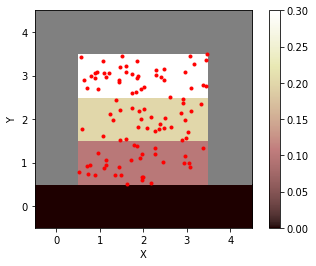

In [6]:
%matplotlib inline
imshow_grid(grid, grid.at_node['topographic__elevation'], color_for_closed='gray')
plot(CC['clast__x'], CC['clast__y'], 'or', markersize=3)



The grid is sloping to the south.

## 2. Principle and equations of the clast-tracker

`ClastCollection` has a method `clast_tracker` to move the clast on the surface of the grid.

We use a probabilistic approach to travel distances calculated at each time step to move the clasts over the landscape.

In practice, clasts are treated one after the other. The clasts are treated differently if they are on a hillslope or in a river (see [&sect; 2.1](#2.1-Hillslope-vs.-river)). The process to move a particular clast involves four steps:
- detachment ([&sect; 2.2](#2.2.-Detachment:-probability-of-disturbance))
- determination of travel azimuth ([&sect; 2.3](#2.3-Travel-direction/azimuth))
- determination of travel distance ([&sect; 2.4](#2.4-Travel-distance))
- deposition/burial ([&sect; 2.5](#2.5-Deposition/burial))



### 2.1 Hillslope vs. river

Particle travel speed is generally higher in a riverbed compared to a hillslope. To account for this, the rules for moving clasts must vary as a function of the location in the model domain. We define two characteristic regions within the model grid, 'hillslope' and 'river', with each cell belonging to only one category.    
A plot of the slope versus contributing drainage area typically displays a sharp transition between cells belonging to the hillslope, characterized by steeper slope and low contributing area, and cells belonging to the riverbed, with lower slopes and higher contributing area (see [Tucker and Bras, 1998](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98WR01474)). We thus use the drainage area/slope ratio to assign each grid cell to a defined category and accordingly apply a different rule for moving clasts depending on the type of cell they are in (see details below). The threshold slope/area value to assign cells to each category is user-defined.


### 2.2. Detachment: probability of disturbance

At the begginning of a time step, the clast can be at the surface of the model topographt or buried under it.

On each cell, we define the probability of disturbance of the soil at a time _t_ as:

$$
\begin{equation}
f_{m}(t) = N_{a}.e^{-N_{a}t}\tag{Eq.1}
\end{equation}
$$

with $N_{a}$ the distrubance frequency $[T^{-1}]$.  

The probability for a clast to be mobilized during a time step _&Delta;t_ is:

$$
\begin{equation}
P_{m}(\Delta t) = (1 - e^{-N_{a} \Delta t}) . e^{- \frac{h}{h*}} \tag{Eq.2}
\end{equation}
$$


with $h$ the clast depth below the topographic surface $[L]$ and $h*$ a characteristic depth $[L]$. 

The values of the disturbance frequency $N_{a}$ and of the characteristic depth $h*$ are defined by the user.

A clast is detached and mobile during a given time step when its probability to be mobilized exceeds ... *value*

**_how do we fix the value?_**

**_should it depend on clast radius?_**




Text(0.5,1,' Proba of detachment with clast depth \n for Na= 0.01 and h*= 5')

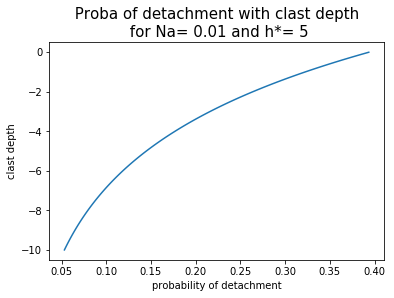

In [7]:
clast_depth = np.linspace(0,10,101)
disturb_fqcy=0.01
dt=50
h_star=5



proba_mobile = (1-np.exp(-disturb_fqcy * dt)) * np.exp(-clast_depth / h_star)

figure()
plot(proba_mobile, -clast_depth)
xlabel('probability of detachment')
ylabel('clast depth')
title(' Proba of detachment with clast depth \n for Na= %s and h*= %s' %(disturb_fqcy, h_star), size=15)

### 2.3 Travel direction/azimuth

#### 2.3.1 Direction of steepest slope: hillslope vs. river

First, the azimuth of the steepest slope is determined.  
On hillslope cells, the direction and dip of the steepest slope are calculated using the neighbor North/South and East/West cells (centered slope). (make a sketch)  
On river cells, the direction and dip of the steepest slope are calculated by a Flow Routing tool (e.g. FlowAccumulatorSteepest).

_**??? Explain why we use different methods: centered slope takes neighboring into account, more non-local. but can't use centered slope on river cells because uneven river banks make a mess... ???**_


#### 2.3.2 Deviation from direction of steepest slope

Clasts can be allowed to deviate from the direction of the steepest slope to allow for lateral spreading. For each clast, at each position $x$, we define a maximum angle of deviation from the azimuth of the steepest slope as:


$$
\begin{equation}
\theta_{max}(clast, x) = ... cos(S(x))...\lambda_{0}(clast)... \tag{Eq.3}
\end{equation}
$$

_**This eq. needs to be defined**_

where $S(x)$ is the local steepest slope and $\lambda_{0}(clast)$ is a characteristic length corresponding to the average distance between 'traps' or 'obstacles' (~roughness) on the surface that will stop the clast (also equals to the average particle motion on a horizontal surface, see below).  $\lambda_{0}(clast)$ depends on the clast size, and so does the maximum angle of deviation: larger clasts tend to deviate less from the azimuth of the steepest slope. 

This capability can be turned on/off by the user if they want spreading or not.

If the spreading option is on, the maximum angle of deviation is calculated for each clast and an angle is picked randomly in the interval $ [-\theta_{max}, \theta_{max}]$ (uniform distribution).


_(clast spreading only on hillslopes for now)_


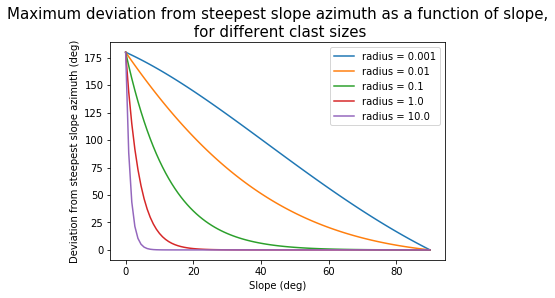

In [8]:
# Max angle

import matplotlib.pyplot as plt
kappa = 0.0001 # diffusion coefficient
disturbance_fqcy = 0.01 # Na

slope = np.linspace(0, np.pi/2, 100)

radi = [0.001, 0.01, 0.1, 1., 10.]

for i in radi:
    lambda_0 = kappa / (2 * i * disturbance_fqcy)

    max_deviation = np.pi * np.exp(-slope/np.sqrt(lambda_0)) * np.cos(slope)
    
    plot(slope * 180/np.pi, max_deviation * 180/np.pi, label="radius = %s" %i)
    xlabel('Slope (deg)')
    ylabel('Deviation from steepest slope azimuth (deg)')
    legend(loc='upper right')
    title('Maximum deviation from steepest slope azimuth as a function of slope,\n for different clast sizes', size=15)
    
  

Text(0.5,0.98,'Possible deviation angles for radius=0.01 \n (left)S=0.01°, (middle)S=45°, (right)S=80°')

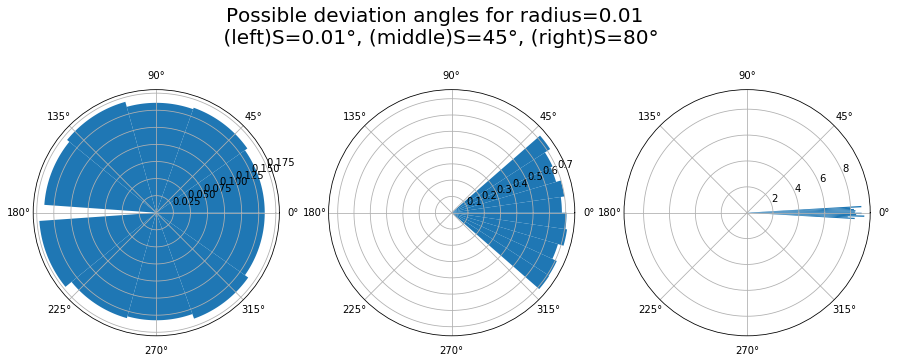

In [9]:
# Fixed radius, angles for different slopes

kappa = 0.0001 # diffusion coefficient
disturbance_fqcy = 0.01 # Na

slope = np.linspace(0, np.pi/2, 100)

radius = 0.01

lambda_0 = kappa / (2 * radius * disturbance_fqcy)

max_deviation = np.pi * np.exp(slope/(-np.sqrt(lambda_0))) * np.cos(slope)
   
# for radius = 0.01, plot angles for S=.01 deg, S=45 deg and S = 80 deg
draw_dev = np.random.uniform(low=-max_deviation[1],
                             high=max_deviation[1],
                            size=10000)
draw_dev2 = np.random.uniform(low=-max_deviation[50],
                                                  high=max_deviation[50],
                                                  size=10000)
draw_dev3 = np.random.uniform(low=-max_deviation[-10],
                                                  high=max_deviation[-10],
                                                  size=10000)
#radial plots
fig, ax = plt.subplots(1,3, subplot_kw=dict(polar=True), figsize=(15,6))
ax[0].hist(draw_dev, density=True)
ax[1].hist(draw_dev2, density=True)
ax[2].hist(draw_dev3, density=True)

fig.suptitle('Possible deviation angles for radius=0.01 \n (left)S=0.01°, (middle)S=45°, (right)S=80°', size=20)

Left: slope=0.01° --> clasts can go (almost) any direction  
Middle: slope=45° --> clasts preferentially go toward azimuth of steepest slope, +/- 40°  
Right, slope=80° --> clasts are mostly restricted to the direction of steepest slope, +/- a few degrees


## 2.4 Travel distance
[Furbish and Haff. 2010](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2009JF001576) and [Furbish and Roering 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrf.20071) provided a nonlocal formulation of the sediment flux involving a convolution of upslope and downslope surface geometry. Once motion is initiated, the distribution of particle travel distances is determined by the disentrainment (deposition) process.

The disentrainment rate $P_{r}(r;x')$ (=rate of deposition, $[L^{-1}]$) at a distance $r$ from the starting point $x’$ is be defined as ([Furbish and Haff. 2010](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2009JF001576)):



$$
\begin{equation}
P_{r}(r;x') = \frac{1}{\lambda_{0}} . \frac{S_{c} - S(x')}{S_{c} + S(x')} \tag{Eq.4}
\end{equation}
$$

with $ 0 \leq S(x') < S_{c}$


where $S_{c}$ is the critical slope (corresponding to critical slope introduced by Roering et al., 1999 , and friction angle introduced by Gabet, 2003 , for dry gravel). It corresponds to the magnitude of a slope beyond which particles in motion are not stopped, they continue moving downslope indefinitely.  
The characteristic length scale $\lambda_{0}$ characterizes the average particle motions on a horizontal surface ($S=0$) (defined below).  
$P_{r}(r;x')dr$ represents the probability that a particle will be disentrained (stop moving) within the interval $[r, r+dr]$, given that it travelled at least as far as $r$; it is thus a conditional probability.
Note that this formulation does not explicitly involve sediment momentum, but implicitly involves a friction-like behavior (e.g., Gabet, 2003) inasmuch as the dispersal length scale decreases with decreasing steepness.    
When $S(x') \rightarrow S_{c}$, $P_{r}(r;x') \rightarrow 0$ and the clast is not stopped. This results in clasts travelling long distances when the slope is steep.  

The probability distribution of the travel distribution can be expressed in terms of the disentrainment rate as follows:

$$
\begin{equation}
f_{r}(r;x') = P_{r}(r;x') . e^{-\int_0^r \! P_{r}(w;x') \, \mathrm{d}w} \tag{Eq.5}
\end{equation}
$$

The shape of the probability distribution depends on the local slope and must thus be evaluated in each point of the model, at each timestep (spatially and temporally variable).

The travel distance $r$ also depends on the characteristics of each clast and its mechanical properties as it interacts with the landscape surface. This is expressed in the formulation of the characteristic length $\lambda_{0}$, which we define as:
$$
\begin{equation} 
\lambda_{0} = \frac{\kappa}{2R.N_{a}} \tag{Eq.6}
\end{equation}
$$

where $\kappa$ is the diffusion coefficient $[L^{2}T^{-1}]$, $R$ is the clast radius $[L]$ and $N_{a}$ the distrubance frequency $[T^{-1}]$.

Evaluating Eq.5 thus yields the probability for a clast to travel a distance $\lambda$:

$$
\begin{equation}
f_{r}(\lambda) = \frac{1}{\overline{\lambda}} . e^{-\frac{1}{\overline{\lambda}}} \tag{Eq.7}
\end{equation}
$$  

with:
$$
\begin{equation}
\overline{\lambda} = \lambda_{0} . \frac{S_{c} + S}{S_{c} - S} \tag{Eq.8}
\end{equation}
$$

Text(0.5,1,'Slope= 0.5, Radius= 0.1')

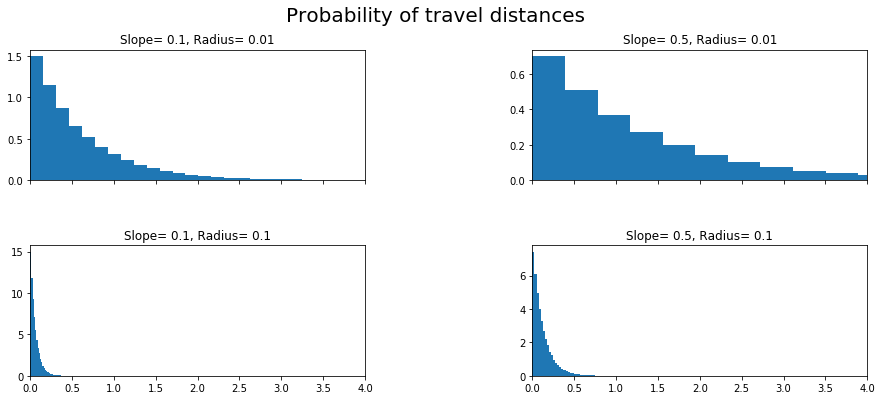

In [10]:
kappa = 0.0001 # diffusion coefficient
disturbance_fqcy = 0.01 # Na
criticial_slope = 1.2 # Sc


# Case 1 
radius_1 = 0.01 # clast radius in meters
slope_1 = 0.1

lambda_0_1 = kappa / (2 * radius_1 * disturbance_fqcy)
lambda_mean_1 = lambda_0_1 * ((criticial_slope + slope_1) / (criticial_slope - slope_1))
travel_distances_1 = np.random.exponential(scale=lambda_mean_1, size=100000)

# Case 2 
radius_2 = 0.01 # clast radius in meters
slope_2 = 0.5

lambda_0_2 = kappa / (2 * radius_2 * disturbance_fqcy)
lambda_mean_2 = lambda_0_2 * ((criticial_slope + slope_2) / (criticial_slope - slope_2))
travel_distances_2 = np.random.exponential(scale=lambda_mean_2, size=100000)

# Case 3
radius_3 = 0.1 # clast radius in meters
slope_3 = 0.1

lambda_0_3 = kappa / (2 * radius_3 * disturbance_fqcy)
lambda_mean_3 = lambda_0_3 * ((criticial_slope + slope_3) / (criticial_slope - slope_3))
travel_distances_3 = np.random.exponential(scale=lambda_mean_3, size=100000)

# Case 4
radius_4 = 0.1 # clast radius in meters
slope_4 = 0.5

lambda_0_4 = kappa / (2 * radius_4 * disturbance_fqcy)
lambda_mean_4 = lambda_0_4 * ((criticial_slope + slope_4) / (criticial_slope - slope_4))
travel_distances_4 = np.random.exponential(scale=lambda_mean_4, size=100000)


# Plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6), sharex=True)
ax0, ax1, ax2, ax3 = axes.flatten()
fig.suptitle('Probability of travel distances', size=20)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax0.hist(travel_distances_1, 50, density=True, histtype='bar')
ax0.set_title('Slope= %s, Radius= %s' %(slope_1, radius_1))
ax0.set_xlim(0,4)

ax1.hist(travel_distances_2, 50, density=True, histtype='bar')
ax1.set_title('Slope= %s, Radius= %s' %(slope_2, radius_2))

ax2.hist(travel_distances_3, 50, density=True, histtype='bar')
ax2.set_title('Slope= %s, Radius= %s' %(slope_3, radius_3))

ax3.hist(travel_distances_4, 50, density=True, histtype='bar')
ax3.set_title('Slope= %s, Radius= %s' %(slope_4, radius_4))


#ax3.set_visible(False)

Left to right: increasing slope  
Top to bottom: increasing radius

If the travel distance randomly drawn from the probability distribution is **smaller** than the distance for the clast to exit the current cell (in the direction of the selected azimuth, see [&sect; 2.3](#2.3-Travel-direction/azimuth)), then the clast travels within the current cell, in the selected direction, of a distance equal to the drawn travel distance.

If the travel distance randomly drawn from the probability distribution is **larger** than the distance to exit the cell, then the clast is moved in the selected direction until it exits the current cell and enters a new cell. There, both the direction of travel and the remaining travel distance must be re-evaluated with regard to the conditions in the new cell (slope, etc.):
- the direction of travel is re-calculated (see [&sect; 2.3](#2.3-Travel-direction/azimuth)),
- the remaining travel distance $\lambda$ is rescaled to the characteristics of the new cell:

$$
\begin{equation}
\lambda_{new} = \lambda_{old} . \frac{\overline{\lambda_{new}}}{\overline{\lambda_{old}}} \tag{Eq.9}
\end{equation}
$$

## 2.5 Deposition/burial

Probability distribution of burial depth:
$$
\begin{equation}
f_{d}(z) = ...N_{a}, h*, Radius...? \tag{Eq.10}
\end{equation}
$$

Text(0.5,1,'Probability distribution of burial depth (in m below topo surface) \n Clast radius= 0.01, h*= 5, Na= 0.01')

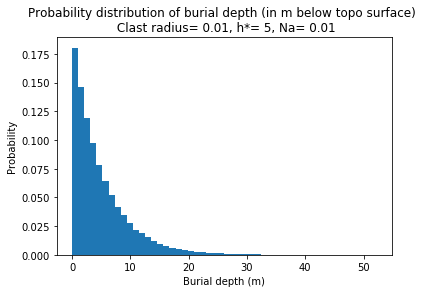

In [11]:
h_star = 5
disturbance_fqcy = 0.01 # Na

radius = 0.01 # clast radius in meters

z_burial = np.random.exponential(scale=(h_star*disturbance_fqcy/radius), size=100000)

n, bins, patches = plt.hist(z_burial, 50, density=1)

plt.xlabel('Burial depth (m)')
plt.ylabel('Probability')
plt.title('Probability distribution of burial depth (in m below topo surface) \n Clast radius= %s, h*= %s, Na= %s' %(radius, h_star, disturbance_fqcy))



_**This is not implemented yet as I don't know the shape this should have, the above is just an example**_

# 3. Running a landscape evolution model with a clast-tracker

We will creat a grid sloping to the south, open on the south boundary, closed everywhere else.
We will add two Landlab components:
- FlowAccumulator, to route flow over the surface, using the FlowDirectorSteepest option
- LinearDiffuser, to perform linear diffusion on the surface

With this setting, a set of 100 clasts is initially positioned at the center of the grid, buried below the topographic surface. Diffusion on the surface will progressively bring them closer to the surface until they can be picked up and transported.

_**lots of things are printing for now, I use it to check/debug, ultimately they won't show. For now, when the next block is done running, scroll all the way down where the output is printed to see the figure**_

CLAST 0
not phantom
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-0.5050755]
slope_we_with_dev=-0.0483873517475
neighborhood
SW-R
change_x = -0.143328205746
change_y = -0.259224666294
move_to
dist_to_travel:
0.06537484352207504
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-1.66578074]
slope_we_with_dev=-0.0995492371012
neighborhood
NW-R
change_x = -0.84962654455
change_y = 0.0809448558919
move_to
dist_to_travel:
0.015879419457454885
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-1.06206295]
slope_we_with_dev=-0.0873362145226
neighborhood
SW-R
change_x = -0.162569883791
change_y = -0.0906647303208
move_to
dist_to_travel:
0.3436738418754866
moving
MOVE OUT OF CELL
from node: 127
current x: 6.66256988369136
current y: 8.344076262684057
going to node: 126
applying changex -0.1

    time     float64 50.0
new node: 126
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.5701659773858012)
Coordinates:
    item_id  int64 6
[127 141 125 111 142 140 110 112]
max_dev=2.71502716898
draw_dev=[-2.16036578]
slope_we_with_dev=-0.0831180140767
NW-R
change_x = -1.0
change_y = 0.668932264393
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.5514179632584676)
Coordinates:
    item_id  int64 6
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[-1.1177275]
slope_we_with_dev=-0.0899108031139
neighborhood
SW-R
change_x = -0.804991533917
change_y = -0.391906593161
move_to
dist_to_travel:
1.8388776714126271
moving
MOVE OUT OF CELL
from node: 127
current x: 7.304991533817066
current y: 8.052080026188245
going to node: 126
applying changex -0.8049915339170663
applying changey -0.391906593161492
new x: 6.4999999999
new y: 7.660173433026753

change_x = 2.00479926881e-10
change_y = -1.14096700898e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.3696867941317248)
Coordinates:
    item_id  int64 7
moving
MOVE OUT OF CELL
from node: 110
current x: 5.4999999999
current y: 6.989400040938893
going to node: 111
applying changex 2.0047992688092203e-10
applying changey -1.1409670089830316e-10
new x: 5.50000000010048
new y: 6.989400040824797
hop length: <xarray.DataArray 'hop_length' ()>
array(0.27849076981239596)
Coordinates:
    item_id  int64 7
    time     float64 100.0
new node: 111
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.36968679403026083)
Coordinates:
    item_id  int64 7
[112 126 110  96 127 125  95  97]
max_dev=2.71502716898
draw_dev=[ 0.64688299]
slope_we_with_dev=0.060270206585
SE-R
change_x = 1.00268340589
change_y = -1.32753414204
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.3546534367641236)
Coordinates:
 

new x: 7.4999999999
new y: 9.15562920864779
hop length: <xarray.DataArray 'hop_length' ()>
array(0.6584659994152013)
Coordinates:
    item_id  int64 4
    time     float64 150.0
new node: 142
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.16187597217652291)
Coordinates:
    item_id  int64 4
[143 157 141 127 158 156 126 128]
max_dev=2.71502716898
draw_dev=[ 1.60902054]
slope_we_with_dev=0.0999269543856
NE-R
change_x = 2.00000008274e-10
change_y = 1.0382428397e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.16183745684787765)
Coordinates:
    item_id  int64 4
moving
MOVE OUT OF CELL
from node: 142
current x: 7.4999999999
current y: 9.15562920864779
going to node: 143
applying changex 2.0000000827403712e-10
applying changey 1.0382428397026362e-10
new x: 7.5000000001
new y: 9.155629208751614
hop length: <xarray.DataArray 'hop_length' ()>
array(0.6584659996416651)
Coordinates:
    item_id  int64 4
    time     float64 150

going to node: 141
applying changex -2.0047873644225548e-10
applying changey 1.1740972042361727e-10
new x: 6.4999999999
new y: 9.267618767480945
hop length: <xarray.DataArray 'hop_length' ()>
array(0.22742809736851544)
Coordinates:
    item_id  int64 2
    time     float64 200.0
new node: 141
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.45739490746528366)
Coordinates:
    item_id  int64 2
[142 156 140 126 157 155 125 127]
max_dev=2.71502716911
draw_dev=[-1.93723557]
slope_we_with_dev=-0.0933609056145
NW-R
change_x = -1.0
change_y = 0.383772366691
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.45052485664782255)
Coordinates:
    item_id  int64 2
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[ 0.66332269]
slope_we_with_dev=0.0615738361815
neighborhood
SE-R
change_x = 0.366742622859
change_y = -0.46931475439
move_to
dist_to_travel

[128 142 126 112 143 141 111 113]
max_dev=2.71502716898
draw_dev=[ 1.44498284]
slope_we_with_dev=0.0992095918304
SE-R
change_x = 2.00483342492e-10
change_y = -1.12709288646e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.5536704278177573)
Coordinates:
    item_id  int64 9
moving
MOVE OUT OF CELL
from node: 127
current x: 7.4999999999
current y: 7.958834197455814
going to node: 128
applying changex 2.0048334249222302e-10
applying changey -1.1270928864572742e-10
new x: 7.500000000100483
new y: 7.958834197343105
hop length: <xarray.DataArray 'hop_length' ()>
array(0.297743893695419)
Coordinates:
    item_id  int64 9
    time     float64 200.0
new node: 128
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.5536704277164735)
Coordinates:
    item_id  int64 9
[129 143 127 113 144 142 112 114]
max_dev=2.71502716898
draw_dev=[-2.18780535]
slope_we_with_dev=-0.0815612673977
NW-R
change_x = -2.00483177334e-10
change_y = 1.7128309

moved
elevation updated
CLAST 0
not phantom
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716898
draw_dev=[ 1.06595872]
slope_we_with_dev=0.087525302963
neighborhood
SE-R
change_x = 0.388373836776
change_y = -0.214615598751
move_to
dist_to_travel:
0.5182759538286082
moving
MOVE OUT OF CELL
from node: 112
current x: 7.1128660728280835
current y: 7.426622762657836
going to node: 113
applying changex 0.3883738367763074
applying changey -0.21461559875079902
new x: 7.501239909604391
new y: 7.212007163907036
hop length: <xarray.DataArray 'hop_length' ()>
array(0.44514866476605824)
Coordinates:
    item_id  int64 0
    time     float64 300.0
new node: 113
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.07454845614684869)
Coordinates:
    item_id  int64 0
[114 128 112  98 129 127  97  99]
max_dev=2.71502716898
draw_dev=[-0.56728602]
slope_we_with_dev=-0.0537345159262
SW-R
change_x = -0.00123990970439
change_y = -0.00194603637232
distance left to travel R

CLAST 0
not phantom
detached
[114 128 112  98 129 127  97  99]
max_dev=2.71502716898
draw_dev=[-0.97048625]
slope_we_with_dev=-0.0825160495286
neighborhood
SW-R
change_x = -0.0457257899226
change_y = -0.0313035147781
move_to
dist_to_travel:
0.09223162286486927
moving
MOVE OUT OF CELL
from node: 113
current x: 7.545725789822575
current y: 7.264422914703768
going to node: 112
applying changex -0.04572578992257536
applying changey -0.03130351477805507
new x: 7.4999999999
new y: 7.233119399925713
hop length: <xarray.DataArray 'hop_length' ()>
array(0.055570867050154175)
Coordinates:
    item_id  int64 0
    time     float64 350.0
new node: 112
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.03666075595411343)
Coordinates:
    item_id  int64 0
[113 127 111  97 128 126  96  98]
max_dev=2.71502716898
draw_dev=[ 1.95953918]
slope_we_with_dev=0.0925386281715
NE-R
change_x = 2.00000008274e-10
change_y = 1.4095861446e-10
distance left to travel RESCALED <xarray.DataArr

[110 124 108  94 125 123  93  95]
max_dev=2.71502716898
draw_dev=[-1.33103923]
slope_we_with_dev=-0.0971395685295
SW-R
change_x = -1.0
change_y = -0.244459266671
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.7780160854112548)
Coordinates:
    item_id  int64 7
moving
MOVE OUT OF CELL
from node: 109
current x: 4.4999999999
current y: 6.612652882561248
going to node: 108
applying changex -1.0
applying changey -0.24445926667122228
new x: 3.4999999999
new y: 6.368193615890026
hop length: <xarray.DataArray 'hop_length' ()>
array(2.517354139334951)
Coordinates:
    item_id  int64 7
    time     float64 350.0
new node: 93
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.7439802409217766)
Coordinates:
    item_id  int64 7
[ 94 108  92  78 109 107  77  79]
max_dev=2.71502716898
draw_dev=[-1.61144594]
slope_we_with_dev=-0.099917391824
NW-R
change_x = -1.0
change_y = 0.0406720176375
distance left to travel RESCALED <xarray.DataArray

SE-R
change_x = 0.0503691308028
change_y = -0.228920832174
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.03924883550199383)
Coordinates:
    item_id  int64 5
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[142 156 140 126 157 155 125 127]
max_dev=2.71502717764
draw_dev=[-2.61527091]
slope_we_with_dev=-0.0502356290548
neighborhood
NW-R
change_x = -0.183019598218
change_y = 0.315015170811
move_to
dist_to_travel:
0.4892495716169757
moving
MOVE OUT OF CELL
from node: 141
current x: 5.683019598118231
current y: 8.789064096028648
going to node: 140
applying changex -0.18301959821823122
applying changey 0.31501517081117036
new x: 5.4999999999
new y: 9.104079266839818
hop length: <xarray.DataArray 'hop_length' ()>
array(0.3654547552172911)
Coordinates:
    item_id  int64 6
    time     float64 400.0
new node: 140
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.12379481653681124)
Coordinates:
    item_i

not phantom
detached
[128 142 126 112 143 141 111 113]
max_dev=2.71502716906
draw_dev=[-0.4970088]
slope_we_with_dev=-0.04767983685
neighborhood
SW-R
change_x = -0.344435775108
change_y = -0.634992563718
move_to
dist_to_travel:
0.8617664375565908
moving
MOVE OUT OF CELL
from node: 127
current x: 6.844435775007662
current y: 8.291025581509302
going to node: 126
applying changex -0.3444357751076623
applying changey -0.6349925637180056
new x: 6.4999999999
new y: 7.656033017791296
hop length: <xarray.DataArray 'hop_length' ()>
array(0.7247321994987382)
Coordinates:
    item_id  int64 1
    time     float64 450.0
new node: 126
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.13703423819387273)
Coordinates:
    item_id  int64 1
[127 141 125 111 142 140 110 112]
max_dev=2.71502716906
draw_dev=[ 0.40657356]
slope_we_with_dev=0.0395464538281
SE-R
change_x = 2.00367399741e-10
change_y = -3.33107056163e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to

dist_to_travel:
0.1373044746522664
moving
MOVE OUT OF CELL
from node: 140
current x: 5.418626486072639
current y: 9.194822905247447
going to node: 141
applying changex 0.08137351402736125
applying changey 0.058891166152866235
new x: 5.5000000001
new y: 9.253714071400314
hop length: <xarray.DataArray 'hop_length' ()>
array(0.10072336013522994)
Coordinates:
    item_id  int64 6
    time     float64 450.0
new node: 141
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.0365811146570581)
Coordinates:
    item_id  int64 6
[142 156 140 126 157 155 125 127]
max_dev=2.71502718445
draw_dev=[-0.47030863]
slope_we_with_dev=-0.04531614102
SW-R
change_x = -2.00000008274e-10
change_y = -2.96713244288e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.0370736884909563)
Coordinates:
    item_id  int64 6
moving
MOVE OUT OF CELL
from node: 141
current x: 5.5000000001
current y: 9.253714071400314
going to node: 140
applying changex -2.0000000

[128 142 126 112 143 141 111 113]
max_dev=2.71502716913
draw_dev=[ 1.61097816]
slope_we_with_dev=0.099919281832
neighborhood
NE-R
change_x = 0.497612938067
change_y = 0.020005768986
move_to
dist_to_travel:
0.5060746756177483
moving
MOVE OUT OF CELL
from node: 127
current x: 7.002387062032866
current y: 8.088424440889092
going to node: 128
applying changex 0.49761293806713436
applying changey 0.020005768986018396
new x: 7.5000000001
new y: 8.108430209875111
hop length: <xarray.DataArray 'hop_length' ()>
array(0.5004908229860535)
Coordinates:
    item_id  int64 4
    time     float64 500.0
new node: 128
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.005583852736147921)
Coordinates:
    item_id  int64 4
[129 143 127 113 144 142 112 114]
max_dev=2.71502716913
draw_dev=[ 1.09718178]
slope_we_with_dev=0.0889925489693
SE-R
change_x = 1.0033468488
change_y = -0.514236816279
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.0054182

change_x = -0.0134371478573
change_y = -0.270430569825
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.036265502903660506)
Coordinates:
    item_id  int64 1
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[129 143 127 113 144 142 112 114]
max_dev=2.71502716926
draw_dev=[-0.15942803]
slope_we_with_dev=-0.0158753513434
neighborhood
SW-C
change_x = -0.0302557190328
change_y = -0.188166061614
move_to
dist_to_travel:
0.3377938213212692
moving
MOVE OUT OF CELL
from node: 128
current x: 8.038325985442633
current y: 7.688166061513536
going to node: 113
applying changex -0.030255719032751042
applying changey -0.18816606161353633
new x: 8.00807026640988
new y: 7.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.19148693760666555)
Coordinates:
    item_id  int64 2
    time     float64 550.0
new node: 113
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.14630688382975449)
Coordinates:
    item_

change_x = -0.564609998658
change_y = -0.29617157803
move_to
dist_to_travel:
1.244544842181732
moving
MOVE OUT OF CELL
from node: 108
current x: 3.0646099985576196
current y: 6.803985208182197
going to node: 107
applying changex -0.5646099986576196
applying changey -0.29617157802997385
new x: 2.4999999999
new y: 6.5078136301522225
hop length: <xarray.DataArray 'hop_length' ()>
array(0.6396806140225397)
Coordinates:
    item_id  int64 7
    time     float64 550.0
new node: 107
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.6048642282946468)
Coordinates:
    item_id  int64 7
[108 122 106  92 123 121  91  93]
max_dev=2.71502716898
draw_dev=[-0.14591908]
slope_we_with_dev=-0.0145401804904
SW-C
change_x = -0.735966486255
change_y = -5.00781363025
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.6219007247131431)
Coordinates:
    item_id  int64 7
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[145 159 

max_dev=2.71502716898
draw_dev=[-0.52205283]
slope_we_with_dev=-0.0498660577051
SW-R
change_x = -1.0
change_y = -1.73825118728
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.4726446116012484)
Coordinates:
    item_id  int64 3
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[129 143 127 113 144 142 112 114]
max_dev=2.71502716946
draw_dev=[ 1.4474526]
slope_we_with_dev=0.099240280027
neighborhood
SE-R
change_x = 0.766689254254
change_y = -0.0950488147856
move_to
dist_to_travel:
0.47527120221511054
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716898
draw_dev=[-0.07165669]
slope_we_with_dev=-0.00715953813977
neighborhood
SW-C
change_x = -0.0576243423864
change_y = -0.802795699343
move_to
dist_to_travel:
0.3793381908354739
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[142 156 140 126 157 155 125 127]
max_dev=2.71502722852
dra

distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.1791419273940102)
Coordinates:
    item_id  int64 8
moving
MOVE OUT OF CELL
from node: 129
current x: 8.562326576958231
current y: 8.4999999999
going to node: 114
applying changex 2.0000000827403712e-10
applying changey -1.3031858889416798e-10
new x: 8.562326577158231
new y: 8.499999999769681
hop length: <xarray.DataArray 'hop_length' ()>
array(0.30152576524246083)
Coordinates:
    item_id  int64 8
    time     float64 600.0
new node: 129
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.17914192728907413)
Coordinates:
    item_id  int64 8
[130 144 128 114 145 143 113 115]
max_dev=2.71502716946
draw_dev=[-1.1390242]
slope_we_with_dev=-0.0908225575215
SW-C
change_x = -5.99859061201e-10
change_y = -3.30318875083e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.17686253926945086)
Coordinates:
    item_id  int64 8
moving
MOVE OUT OF CELL
fro

detached
[ 96 110  94  80 111 109  79  81]
max_dev=2.71502716898
draw_dev=[-0.50622934]
slope_we_with_dev=-0.0484882965795
neighborhood
SW-R
change_x = -0.267939208707
change_y = -0.483279542283
move_to
dist_to_travel:
0.1227369029641767
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[129 143 127 113 144 142 112 114]
max_dev=2.71502716975
draw_dev=[ 2.67209307]
slope_we_with_dev=0.0452440068982
neighborhood
NE-C
change_x = 0.0712447840073
change_y = 0.140429048644
move_to
dist_to_travel:
0.0030502608125119856
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716898
draw_dev=[ 0.78768736]
slope_we_with_dev=0.0708723636431
neighborhood
SE-C
change_x = 0.426289723507
change_y = -0.428245930666
move_to
dist_to_travel:
0.5508955174772123
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[127 141 125 111 142 140 110 112]
max_dev=2.71502716975
draw_dev=[-0.5358041]
slope_we

new y: 6.146453898108514
hop length: <xarray.DataArray 'hop_length' ()>
array(0.07749927150954919)
Coordinates:
    item_id  int64 9
    time     float64 650.0
new node: 96
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.09568886914931662)
Coordinates:
    item_id  int64 9
[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716898
draw_dev=[ 2.63805288]
slope_we_with_dev=0.0482528973873
NE-C
change_x = 0.194771242847
change_y = 0.353546101991
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.09267510391125924)
Coordinates:
    item_id  int64 9
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716899
draw_dev=[-0.28900802]
slope_we_with_dev=-0.0285001528176
neighborhood
SW-C
change_x = -0.119307857155
change_y = -0.401260338764
move_to
dist_to_travel:
0.34345082526571924
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[113 127 111  

change_x = 0.447064117773
change_y = -0.132335723617
move_to
dist_to_travel:
1.2338128947633094
moving
MOVE OUT OF CELL
from node: 112
current x: 7.054827970468841
current y: 6.787721362707072
going to node: 113
applying changex 0.4470641177733833
applying changey -0.1323357236172173
new x: 7.501892088242224
new y: 6.655385639089855
hop length: <xarray.DataArray 'hop_length' ()>
array(0.4682209121776115)
Coordinates:
    item_id  int64 1
    time     float64 750.0
new node: 113
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.7675736117444865)
Coordinates:
    item_id  int64 1
[114 128 112  98 129 127  97  99]
max_dev=2.71502716899
draw_dev=[-2.69819747]
slope_we_with_dev=-0.042900880244
NW-R
change_x = -0.00189208834222
change_y = 0.00398389013491
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.7565270908025409)
Coordinates:
    item_id  int64 1
moving
MOVE OUT OF CELL
from node: 113
current x: 7.501892088242224
current y

slope_we_with_dev=0.0951232115087
neighborhood
SE-R
change_x = 0.35447126883
change_y = -0.114951849626
move_to
dist_to_travel:
0.036333945139866985
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[81 95 79 65 96 94 64 66]
max_dev=2.71502716898
draw_dev=[-2.63036794]
slope_we_with_dev=-0.0489245742199
neighborhood
NW-C
change_x = -0.54274789594
change_y = 0.967520721487
move_to
dist_to_travel:
0.7254907565758092
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[129 143 127 113 144 142 112 114]
max_dev=2.71502717154
draw_dev=[-0.27889937]
slope_we_with_dev=-0.0275297711843
neighborhood
SW-C
change_x = -0.06279748539
change_y = -0.219293245401
move_to
dist_to_travel:
0.48339472694272856
moving
MOVE OUT OF CELL
from node: 128
current x: 7.819415819908491
current y: 7.719293245301012
going to node: 113
applying changex -0.06279748539003806
applying changey -0.21929324540101192
new x: 7.7566183345184525
new y: 7.4999999999
hop length: <xarray

SW-C
change_x = -0.193369561487
change_y = -1.03197458835
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.3756064877371798)
Coordinates:
    item_id  int64 0
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716902
draw_dev=[ 2.24385581]
slope_we_with_dev=0.0781918101749
neighborhood
NE-C
change_x = 0.0515413086186
change_y = 0.0410911080933
move_to
dist_to_travel:
0.26244646273411854
moving
MOVE OUT OF CELL
from node: 112
current x: 6.525138298636953
current y: 7.458908892006654
going to node: 127
applying changex 0.05154130861864625
applying changey 0.041091108093345596
new x: 6.576679607255599
new y: 7.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.066089249728546)
Coordinates:
    item_id  int64 1
    time     float64 850.0
new node: 127
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.19635721314647075)
Coordinates:
    item_id 

moved
elevation updated
CLAST 8
not phantom
detached
[131 145 129 115 146 144 114 116]
max_dev=2.71502717258
draw_dev=[-1.35987707]
slope_we_with_dev=-0.0977838865171
neighborhood
SW-R
change_x = -0.482632911087
change_y = -0.103333467455
move_to
dist_to_travel:
0.1396348220302515
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716898
draw_dev=[-0.05400285]
slope_we_with_dev=-0.00539766042943
neighborhood
SW-C
change_x = -0.0330968248781
change_y = -0.612275942162
move_to
dist_to_travel:
0.1584201151383761
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716898
draw_dev=[-0.51224738]
slope_we_with_dev=-0.0490137399238
neighborhood
SW-C
change_x = -0.373660465603
change_y = -0.664506210752
move_to
dist_to_travel:
0.016786240408480424
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[113 127 111  97 128 126  96  98]
max

draw_dev=[-2.04979383]
slope_we_with_dev=-0.0887457407154
NW-R
change_x = -0.700640466308
change_y = 0.363868731399
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.23138062893302427)
Coordinates:
    item_id  int64 0
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[113 127 111  97 128 126  96  98]
max_dev=2.71502716906
draw_dev=[ 1.20252842]
slope_we_with_dev=0.0932952297903
neighborhood
SE-R
change_x = 0.974223436563
change_y = -0.375925383111
move_to
dist_to_travel:
1.909758440068493
moving
MOVE OUT OF CELL
from node: 112
current x: 6.529526951169794
current y: 7.387312671806618
going to node: 113
applying changex 0.9742234365633956
applying changey -0.3759253831110112
new x: 7.50375038773319
new y: 7.011387288695607
hop length: <xarray.DataArray 'hop_length' ()>
array(1.0482725854051946)
Coordinates:
    item_id  int64 1
    time     float64 950.0
new node: 113
distance left to travel <xarray.DataArray 'distance__to_trave

max_dev=2.71502716898
draw_dev=[-1.3514834]
slope_we_with_dev=-0.0976047159447
SW-R
change_x = -0.156638909439
change_y = -0.0349145150441
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.12866203478926802)
Coordinates:
    item_id  int64 9
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716898
draw_dev=[ 1.85910983]
slope_we_with_dev=0.0958724770361
neighborhood
NE-R
change_x = 0.50402020443
change_y = 0.149480814266
move_to
dist_to_travel:
0.8004883753185554
moving
MOVE OUT OF CELL
from node: 96
current x: 5.9959797956704355
current y: 5.606287920403149
going to node: 97
applying changex 0.5040202044295645
applying changey 0.14948081426628698
new x: 6.5000000001
new y: 5.755768734669436
hop length: <xarray.DataArray 'hop_length' ()>
array(0.5279525816671942)
Coordinates:
    item_id  int64 0
    time     float64 1e+03
new node: 97
distance left to travel <xarray.DataArray 'di

max_dev=2.71502716898
draw_dev=[ 0.78938584]
slope_we_with_dev=0.0709920864979
SE-R
change_x = 2.00249712435e-10
change_y = -1.99453356916e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.14183242700949938)
Coordinates:
    item_id  int64 7
moving
MOVE OUT OF CELL
from node: 80
current x: 5.4999999999
current y: 5.116869294137813
going to node: 81
applying changex 2.0024971243513812e-10
applying changey -1.9945335691636916e-10
new x: 5.50000000010025
new y: 5.116869293938359
hop length: <xarray.DataArray 'hop_length' ()>
array(0.7483529425651341)
Coordinates:
    item_id  int64 7
    time     float64 1e+03
new node: 81
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.14183242686828687)
Coordinates:
    item_id  int64 7
[82 96 80 66 97 95 65 67]
max_dev=2.71502716898
draw_dev=[-0.65135233]
slope_we_with_dev=-0.0606262419532
SW-R
change_x = -2.0024958641e-10
change_y = -2.31502383512e-10
distance left to travel RESCALED <

max_dev=2.71502718046
draw_dev=[-0.15385666]
slope_we_with_dev=-0.0153250358295
SW-C
change_x = -0.0492785676223
change_y = -0.317757546676
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.24339633610832867)
Coordinates:
    item_id  int64 4
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716898
draw_dev=[-2.44274386]
slope_we_with_dev=-0.0643336771572
neighborhood
NW-C
change_x = -0.420203732678
change_y = 0.500050637607
move_to
dist_to_travel:
1.4978028197289814
moving
MOVE OUT OF CELL
from node: 96
current x: 5.932353210877725
current y: 5.9999493624930995
going to node: 111
applying changex -0.42020373267847794
applying changey 0.5000506376069005
new x: 5.512149478199247
new y: 6.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.65484212227802)
Coordinates:
    item_id  int64 5
    time     float64 1.05e+03
new node: 111
distance left to travel <xarray.DataA

CLAST 2
not phantom
detached
[53 67 51 37 68 66 36 38]
max_dev=2.71502716898
draw_dev=[ 0.40019903]
slope_we_with_dev=0.0389601656971
neighborhood
SE-R
change_x = 0.309669199565
change_y = -0.732030288591
move_to
dist_to_travel:
0.9598592667682981
moving
MOVE OUT OF CELL
from node: 52
current x: 7.191474086495151
current y: 3.409040288346277
going to node: 53
applying changex 0.30966919956471217
applying changey -0.7320302885908464
new x: 7.501143286059863
new y: 2.677009999755431
hop length: <xarray.DataArray 'hop_length' ()>
array(0.7977808012886476)
Coordinates:
    item_id  int64 2
    time     float64 1.1e+03
new node: 53
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.16502383954760136)
Coordinates:
    item_id  int64 2
[54 68 52 38 69 67 37 39]
max_dev=2.71502716898
draw_dev=[-2.30990447]
slope_we_with_dev=-0.0739069632537
NW-R
change_x = -0.00114328615986
change_y = 0.00104205439715
distance left to travel RESCALED <xarray.DataArray 'distance__to_tra

moved
elevation updated
CLAST 7
not phantom
detached
[81 95 79 65 96 94 64 66]
max_dev=2.71502716898
draw_dev=[-0.05960138]
slope_we_with_dev=-0.00595660965184
neighborhood
SW-C
change_x = -0.0314732496426
change_y = -0.527437021029
move_to
dist_to_travel:
0.09042273388573774
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[118 132 116 102 133 131 101 103]
max_dev=2.71502716919
draw_dev=[-2.11316533]
slope_we_with_dev=-0.0856488286388
neighborhood
NW-R
change_x = -0.356629914242
change_y = 0.214924597643
move_to
dist_to_travel:
1.2997398301239977
moving
MOVE OUT OF CELL
from node: 117
current x: 11.8566299141422
current y: 6.5033988500518
going to node: 116
applying changex -0.35662991424220003
applying changey 0.21492459764265887
new x: 11.4999999999
new y: 6.718323447694459
hop length: <xarray.DataArray 'hop_length' ()>
array(0.41765241686231475)
Coordinates:
    item_id  int64 8
    time     float64 1.1e+03
new node: 116
distance left to travel <xarray.DataA

[ 96 110  94  80 111 109  79  81]
max_dev=2.71502716898
draw_dev=[-0.64606936]
slope_we_with_dev=-0.0602052617756
SW-R
change_x = -1.0
change_y = -1.32622364004
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.09646378116482253)
Coordinates:
    item_id  int64 5
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[78 92 76 62 93 91 61 63]
max_dev=2.71502716898
draw_dev=[ 1.96726107]
slope_we_with_dev=0.0922431927623
neighborhood
NE-R
change_x = 0.0353766155737
change_y = 0.014809791429
move_to
dist_to_travel:
0.16332668998243952
moving
MOVE OUT OF CELL
from node: 77
current x: 2.4646233845263454
current y: 5.095173785156199
going to node: 78
applying changex 0.03537661557365456
applying changey 0.014809791429008807
new x: 2.5000000001
new y: 5.109983576585208
hop length: <xarray.DataArray 'hop_length' ()>
array(0.03849429475096892)
Coordinates:
    item_id  int64 6
    time     float64 1.15e+03
new node: 78
distance left to trave

change_x = 0.676043714898
change_y = -0.613372821932
move_to
dist_to_travel:
0.5654896036276678
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[54 68 52 38 69 67 37 39]
max_dev=2.71502716898
draw_dev=[-1.86303729]
slope_we_with_dev=-0.0957600662864
neighborhood
NW-R
change_x = -0.357750335214
change_y = 0.107630955758
move_to
dist_to_travel:
0.5653851362329021
moving
MOVE OUT OF CELL
from node: 53
current x: 7.85775033511443
current y: 3.3772253822817078
going to node: 52
applying changex -0.3577503352144298
applying changey 0.10763095575794947
new x: 7.4999999999
new y: 3.4848563380396573
hop length: <xarray.DataArray 'hop_length' ()>
array(0.3751705800661533)
Coordinates:
    item_id  int64 2
    time     float64 1.2e+03
new node: 52
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.1902145562918457)
Coordinates:
    item_id  int64 2
[53 67 51 37 68 66 36 38]
max_dev=2.71502716898
draw_dev=[-1.01155285]
slope_we_with_dev=-0.08476567

max_dev=2.71502716898
draw_dev=[ 2.31766152]
slope_we_with_dev=0.0733822079126
neighborhood
NE-C
change_x = 0.12236546162
change_y = 0.11328081297
move_to
dist_to_travel:
0.20962171709946373
moving
MOVE OUT OF CELL
from node: 52
current x: 7.343205375506325
current y: 3.3867191871295512
going to node: 67
applying changex 0.12236546162017005
applying changey 0.11328081297044879
new x: 7.465570837126495
new y: 3.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.16716968060116577)
Coordinates:
    item_id  int64 2
    time     float64 1.25e+03
new node: 67
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.04245203663996924)
Coordinates:
    item_id  int64 2
[68 82 66 52 83 81 51 53]
max_dev=2.71502716898
draw_dev=[-0.00702724]
slope_we_with_dev=-0.000702718476109
SW-C
change_x = -0.0210820749194
change_y = -3.0
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.04457097624630102)
Coordinates:
    item_id  int64 2


new node: 52
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.09654587851657559)
Coordinates:
    item_id  int64 2
[53 67 51 37 68 66 36 38]
max_dev=2.71502716898
draw_dev=[ 1.99789476]
slope_we_with_dev=0.091017149859
NE-C
change_x = 0.671681458611
change_y = 0.305691516171
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.09422340218963358)
Coordinates:
    item_id  int64 2
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[77 91 75 61 92 90 60 62]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(61)
Coordinates:
    item_id  int64 3
neighborhood
clast is next to boundary or on river cell
receiver is : 61
ssdip= 0.0996686524912
clastnode <xarray.DataArray 'clast__node' ()>
array(76)
Coordinates:
    item_id  int64 3
clastnodey 5.0
clasty 4.825383775333499
dist to exit toward SOUTH: 0.327006647123
change_x = 0.0
change_y = -0.325383775433
move_to
dist_to_travel:
0

[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716899
draw_dev=[-2.49379507]
slope_we_with_dev=-0.0603431628974
neighborhood
NW-R
change_x = -0.3524407128
change_y = 0.465738629177
move_to
dist_to_travel:
0.24227757713190332
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[53 67 51 37 68 66 36 38]
max_dev=2.71502716898
draw_dev=[ 2.17983639]
slope_we_with_dev=0.0820197555014
neighborhood
NE-C
change_x = 0.382514097763
change_y = 0.266800129175
move_to
dist_to_travel:
0.5454662874383565
moving
MOVE OUT OF CELL
from node: 52
current x: 6.585454198753441
current y: 3.2331998709246483
going to node: 67
applying changex 0.38251409776264145
applying changey 0.2668001291753517
new x: 6.967968296516082
new y: 3.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.4676714833737261)
Coordinates:
    item_id  int64 2
    time     float64 1.35e+03
new node: 67
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.07779480420424734)
Coor

current x: 1.4999999999
current y: 4.613838569652843
going to node: 61
applying changex 0.0
applying changey -0.11383856975284255
new x: 1.4999999999
new y: 4.4999999999
hop length: <xarray.DataArray 'hop_length' ()>
array(0.11440634669023622)
Coordinates:
    item_id  int64 3
    time     float64 1.4e+03
new node: 61
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.3791391592832712)
Coordinates:
    item_id  int64 3
[62 76 60 46 77 75 45 47]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(46)
Coordinates:
    item_id  int64 3
clast is next to boundary or on river cell
receiver is : 46
ssdip= 0.0996686524912
clastnode <xarray.DataArray 'clast__node' ()>
array(61)
Coordinates:
    item_id  int64 3
clastnodey 4.0
clasty 4.4999999999
dist to exit toward SOUTH: 1.00498756201
change_x = 0.0
change_y = -1.0
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.379139159283272)
Coordinates:
    it

CLAST 0
not phantom
detached
[84 98 82 68 99 97 67 69]
max_dev=2.71502716898
draw_dev=[-2.08853489]
slope_we_with_dev=-0.0868940621471
neighborhood
NW-R
change_x = -0.275535572329
change_y = 0.156934843666
move_to
dist_to_travel:
1.945720250686934
moving
MOVE OUT OF CELL
from node: 83
current x: 7.7755355722291535
current y: 4.9866335127581145
going to node: 82
applying changex -0.2755355723291535
applying changey 0.1569348436658492
new x: 7.4999999999
new y: 5.143568356423963
hop length: <xarray.DataArray 'hop_length' ()>
array(0.31809112096823555)
Coordinates:
    item_id  int64 0
    time     float64 1.45e+03
new node: 82
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(1.6276291298555132)
Coordinates:
    item_id  int64 0
[83 97 81 67 98 96 66 68]
max_dev=2.71502716898
draw_dev=[ 0.43475622]
slope_we_with_dev=0.0421189309409
SE-R
change_x = 2.00353454163e-10
change_y = -3.16097241933e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_trave

NW-C
change_x = -0.529919025348
change_y = 1.00000000032
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.0928131164038632)
Coordinates:
    item_id  int64 7
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[71 85 69 55 86 84 54 56]
max_dev=2.71502716898
draw_dev=[ 2.4140712]
slope_we_with_dev=0.0665020640339
neighborhood
NE-R
change_x = 0.190530944632
change_y = 0.21396819875
move_to
dist_to_travel:
0.8173303344772672
moving
MOVE OUT OF CELL
from node: 70
current x: 10.309469055467952
current y: 4.109634144037873
going to node: 71
applying changex 0.19053094463204798
applying changey 0.21396819875030768
new x: 10.5000000001
new y: 4.32360234278818
hop length: <xarray.DataArray 'hop_length' ()>
array(0.28722870288801955)
Coordinates:
    item_id  int64 8
    time     float64 1.45e+03
new node: 71
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.5301016317307894)
Coordinates:
    item_id  int64 8
[72 

[ 98 112  96  82 113 111  81  83]
max_dev=2.71502716901
draw_dev=[-0.41607608]
slope_we_with_dev=-0.0404174435655
SW-C
change_x = -0.00556733788415
change_y = -0.0125993700672
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.5438921813789602)
Coordinates:
    item_id  int64 4
moving
MOVE OUT OF CELL
from node: 97
current x: 7.170088940430771
current y: 6.487400630032752
going to node: 82
applying changex -0.005567337884151328
applying changey -0.012599370067247753
new x: 7.16452160254662
new y: 6.4748012599655045
hop length: <xarray.DataArray 'hop_length' ()>
array(0.2840961275181141)
Coordinates:
    item_id  int64 4
    time     float64 1.5e+03
new node: 97
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.5300676333532492)
Coordinates:
    item_id  int64 4
[ 98 112  96  82 113 111  81  83]
max_dev=2.71502716901
draw_dev=[-1.0427773]
slope_we_with_dev=-0.0863806824093
SW-C
change_x = -0.0432033412465
change_y = -0.02519874

applying changey 0.0773010658640949
new x: 6.594760609833816
new y: 5.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.09568780175904856)
Coordinates:
    item_id  int64 9
    time     float64 1.5e+03
new node: 97
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.8976629312971686)
Coordinates:
    item_id  int64 9
[ 98 112  96  82 113 111  81  83]
max_dev=2.71502716901
draw_dev=[-2.17304253]
slope_we_with_dev=-0.0824065231419
NW-R
change_x = -0.0947606099338
change_y = 0.0651421782038
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.8992091940265707)
Coordinates:
    item_id  int64 9
moving
MOVE OUT OF CELL
from node: 97
current x: 6.594760609833816
current y: 5.5000000001
going to node: 96
applying changex -0.09476060993381628
applying changey 0.06514217820379405
new x: 6.4999999999
new y: 5.565142178303794
hop length: <xarray.DataArray 'hop_length' ()>
array(0.21100334051641145)
Coordinates:
    item_id  i

change_y = -1.48251251188
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(3.4815729832337365)
Coordinates:
    item_id  int64 2
moving
MOVE OUT OF CELL
from node: 53
current x: 7.500000000100371
current y: 3.160550179769712
going to node: 54
applying changex 1.002842173990348
applying changey -1.4825125118760494
new x: 8.50284217409072
new y: 1.6780376678936628
hop length: <xarray.DataArray 'hop_length' ()>
array(1.9586564975486196)
Coordinates:
    item_id  int64 2
    time     float64 1.55e+03
new node: 39
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(1.6917305953946147)
Coordinates:
    item_id  int64 2
[40 54 38 24 55 53 23 25]
max_dev=2.71502716898
draw_dev=[ 2.19879368]
slope_we_with_dev=0.0809205733849
NE-R
change_x = 0.997157826009
change_y = 0.723988366725
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(1.687700324912711)
Coordinates:
    item_id  int64 2
moving
MOVE OUT OF CELL
f

MOVE OUT OF CELL
from node: 81
current x: 5.736914284799381
current y: 5.4999999999
going to node: 66
applying changex 2.0000000827403712e-10
applying changey -1.797840744210966e-10
new x: 5.736914284999381
new y: 5.499999999720216
hop length: <xarray.DataArray 'hop_length' ()>
array(0.41645195273791946)
Coordinates:
    item_id  int64 9
    time     float64 1.55e+03
new node: 81
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.6918030761975124)
Coordinates:
    item_id  int64 9
[82 96 80 66 97 95 65 67]
max_dev=2.71502716898
draw_dev=[-0.89095701]
slope_we_with_dev=-0.0777673743431
SW-C
change_x = -4.46098094515e-10
change_y = -3.79784195811e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.6915868112166922)
Coordinates:
    item_id  int64 9
moving
MOVE OUT OF CELL
from node: 81
current x: 5.736914284999381
current y: 5.499999999720216
going to node: 66
applying changex -4.460980945150149e-10
applying changey -3.7978419

MOVE OUT OF CELL
from node: 63
current x: 3.380649536018021
current y: 4.057670528847265
going to node: 64
applying changex 0.1193504640819789
applying changey 0.11488050784753555
new x: 3.5000000001
new y: 4.172551036694801
hop length: <xarray.DataArray 'hop_length' ()>
array(0.1660706910145187)
Coordinates:
    item_id  int64 7
    time     float64 1.6e+03
new node: 64
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.12931789233801197)
Coordinates:
    item_id  int64 7
[65 79 63 49 80 78 48 50]
max_dev=2.71502716898
draw_dev=[ 1.47046588]
slope_we_with_dev=0.099497112084
SE-R
change_x = 1.00488873197
change_y = -0.101160602651
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.13558228914205542)
Coordinates:
    item_id  int64 7
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[ 86 100  84  70 101  99  69  71]
max_dev=2.71502716898
draw_dev=[ 1.72540737]
slope_we_with_dev=0.0988071503619
neighborhood

MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[ 87 101  85  71 102 100  70  72]
max_dev=2.71502716898
draw_dev=[-1.85509096]
slope_we_with_dev=-0.0959859733504
neighborhood
NW-R
change_x = -0.0072449134506
change_y = 0.0021170351252
move_to
dist_to_travel:
0.1651751082080004
moving
MOVE OUT OF CELL
from node: 86
current x: 10.507244913350602
current y: 4.8454202936638815
going to node: 85
applying changex -0.0072449134506022885
applying changey 0.002117035125202426
new x: 10.4999999999
new y: 4.847537328789084
hop length: <xarray.DataArray 'hop_length' ()>
array(0.007580087705627525)
Coordinates:
    item_id  int64 8
    time     float64 1.65e+03
new node: 85
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.15759502062693603)
Coordinates:
    item_id  int64 8
[ 86 100  84  70 101  99  69  71]
max_dev=2.71502716898
draw_dev=[ 0.62497107]
slope_we_with_dev=0.0585073814183
SE-R
change_x = 2.0027449728e-10
change_y = -2.38992062637e-10
distanc

moved
elevation updated
CLAST 5
not phantom
detached
[22 36 20  6 37 35  5  7]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(6)
Coordinates:
    item_id  int64 5
neighborhood
clast is next to boundary or on river cell
receiver is : 6
ssdip= 0.0996686524912
clastnode <xarray.DataArray 'clast__node' ()>
array(21)
Coordinates:
    item_id  int64 5
clastnodey 1.0
clasty 1.2827205966256603
dist to exit toward SOUTH: 0.786624464218
change_x = 0.0
change_y = -0.782720596726
move_to
dist_to_travel:
0.19653714183705376
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
CLAST 7
not phantom
detached
[65 79 63 49 80 78 48 50]
max_dev=2.71502716898
draw_dev=[ 0.66868898]
slope_we_with_dev=0.0619957846773
neighborhood
SE-R
change_x = 0.257618164563
change_y = -0.326048391771
move_to
dist_to_travel:
0.20817304584615554
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[ 87 101  85  71 102 100  70  72]
max_dev=2.71502716898
draw_dev=[-2.

[ 97 111  95  81 112 110  80  82]
max_dev=2.71502716908
draw_dev=[-2.08666731]
slope_we_with_dev=-0.0869863402656
neighborhood
NW-R
change_x = -0.129300258736
change_y = 0.0733251565235
move_to
dist_to_travel:
0.7846312271622838
moving
MOVE OUT OF CELL
from node: 96
current x: 5.629300258636039
current y: 6.139140258647396
going to node: 95
applying changex -0.12930025873603856
applying changey 0.073325156523493
new x: 5.4999999999
new y: 6.21246541517089
hop length: <xarray.DataArray 'hop_length' ()>
array(0.14911311730610002)
Coordinates:
    item_id  int64 1
    time     float64 1.8e+03
new node: 95
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.6355181099929293)
Coordinates:
    item_id  int64 1
[ 96 110  94  80 111 109  79  81]
max_dev=2.71502716908
draw_dev=[-0.91605119]
slope_we_with_dev=-0.0793203154505
SW-R
change_x = -1.0
change_y = -0.767718964678
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.628694871010574

change_x = 0.00997254970177
change_y = 0.00571367021162
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.41571734620582496)
Coordinates:
    item_id  int64 0
moving
MOVE OUT OF CELL
from node: 54
current x: 8.501254600036237
current y: 3.494286329888375
going to node: 69
applying changex 0.00997254970177327
applying changey 0.005713670211624935
new x: 8.51122714973801
new y: 3.5000000001
hop length: <xarray.DataArray 'hop_length' ()>
array(0.3011404409274474)
Coordinates:
    item_id  int64 0
    time     float64 1.9e+03
new node: 69
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.40418794081673093)
Coordinates:
    item_id  int64 0
[70 84 68 54 85 83 53 55]
max_dev=2.71502716898
draw_dev=[ 1.26631273]
slope_we_with_dev=0.0954001899138
SE-R
change_x = 0.992899269354
change_y = -0.312024282562
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.4125441572914684)
Coordinates:
    item_id  int

MOVE OUT OF CELL
from node: 84
current x: 9.4999999999
current y: 5.384832370049164
going to node: 85
applying changex 2.0048321133253445e-10
applying changey -1.1276496278267461e-10
new x: 9.500000000100483
new y: 5.384832369936399
hop length: <xarray.DataArray 'hop_length' ()>
array(0.12344189031082775)
Coordinates:
    item_id  int64 8
    time     float64 1.9e+03
new node: 85
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(0.04356683167847192)
Coordinates:
    item_id  int64 8
[ 86 100  84  70 101  99  69  71]
max_dev=2.71502716898
draw_dev=[ 1.13369104]
slope_we_with_dev=0.0905980841785
SE-R
change_x = 1.00352292913
change_y = -0.468895139263
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(0.042526936564628734)
Coordinates:
    item_id  int64 8
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[64 78 62 48 79 77 47 49]
max_dev=2.71502716898
draw_dev=[-0.90440094]
slope_we_with_dev=-0.0786054980602


[82 96 80 66 97 95 65 67]
max_dev=2.71502716898
draw_dev=[-0.91419039]
slope_we_with_dev=-0.0792068635191
SW-R
change_x = -2.00000008274e-10
change_y = -1.77068080309e-10
distance left to travel RESCALED <xarray.DataArray 'distance__to_travel' ()>
array(3.5197736110143287)
Coordinates:
    item_id  int64 7
moving
MOVE OUT OF CELL
from node: 81
current x: 5.5000000001
current y: 4.967815412109603
going to node: 80
applying changex -2.0000000827403712e-10
applying changey -1.770680803089952e-10
new x: 5.4999999999
new y: 4.967815411932535
hop length: <xarray.DataArray 'hop_length' ()>
array(0.9640732063164396)
Coordinates:
    item_id  int64 7
    time     float64 2e+03
new node: 80
distance left to travel <xarray.DataArray 'distance__to_travel' ()>
array(3.5197736108877415)
Coordinates:
    item_id  int64 7
[81 95 79 65 96 94 64 66]
max_dev=2.71502716898
draw_dev=[ 1.41885361]
slope_we_with_dev=0.0988478896797
SE-R
change_x = 2.0047648852e-10
change_y = -1.15385250554e-10
distance left 

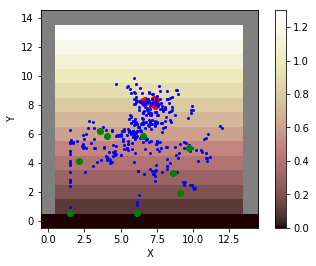

In [12]:
# Create a grid:
dx = 1.
dy=1.
grid = RasterModelGrid((15, 15), (dx, dy))

S=0.1
z = grid.node_y*S
grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False, left_is_closed=True, right_is_closed=True, top_is_closed=True)


# Flow Director
fa = FlowAccumulator(grid,'topographic__elevation', flow_director='FlowDirectorSteepest')

# Linear diffuser
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)


# Clasts:
nb_clast = 10
initial_x = np.random.uniform(low=grid.x_of_node[127]-grid.dx/2, high=grid.x_of_node[127]+grid.dx/2, size=nb_clast) 
initial_y = np.random.uniform(low=grid.y_of_node[127]-grid.dy/2, high=grid.y_of_node[127]+grid.dy/2, size=nb_clast)
initial_elevation = np.ones(nb_clast)*grid.at_node['topographic__elevation'][127] - np.random.rand(nb_clast)/2
# random position within central cell, at or below surface
initial_rad = np.ones(nb_clast)*0.01

CC = ClastCollection(grid,
                     clast_x=initial_x,
                     clast_y=initial_y,
                     clast_elev=initial_elevation,
                     clast_radius=initial_rad)

# Init Figures:
figure(0)
imshow_grid(grid, grid.at_node['topographic__elevation'], color_for_closed='gray')
plot(CC['clast__x'], CC['clast__y'], 'or')


### RUN ##############
Si=1.2 # critical slope
disturbance_fqcy=0.01
d_star=5.

dt=50 # time step size, in years
runtime=2000 # total run time, in years

#uplift_rate = 0.0001
mean_trav_dist=[0]
std_trav_dist=[0]
# Analytical solution:
analytical_mean_trav_dist=[]
analytical_std_trav_dist=[]


for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                Si=Si,
                                kappa=kappa,
                                uplift=None,
                                hillslope_river__threshold=1e4,
                                lateral_spreading='on',
                                disturbance_fqcy=disturbance_fqcy,
                                d_star=d_star)
    figure(0)
    plot(CC['clast__x'][:,-1], CC['clast__y'][:,-1], 'ob', markersize=2)
    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))

    analytical_mean_trav_dist.append(t/dt*np.mean(CC['lambda_0'].values)*(Si + S)/(Si - S))
    analytical_std_trav_dist.append(np.sqrt(t/dt*np.mean(CC['lambda_0'].values)*(Si+S)/(Si-S)))

figure(0)
plot(CC['clast__x'][:,-1], CC['clast__y'][:,-1], 'og')


The clasts are initially positioned randomly in the central cell (red dots), they move globally towards the south (blue dots are intermediate positions during the run, green dots are final positions). 

If the 'lateral_spreading' option is on, they can move laterally and even upslope (the steeper the slope and the larger the clast, the less this happens). Once they reach the south boundary cells, they exit the grid and are not moved anymore.


Text(0.5,1,'Mean travel distance vs. time, \n slope=0.1, dx=1.0, kappa=0.0001')

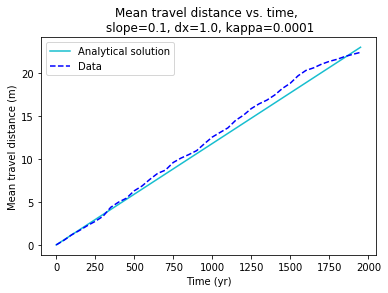

In [13]:
# Check mean travel distance versus analytical solution:
figure(300)
plot(range(0,runtime,dt), analytical_mean_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--b', label="Data")
xlabel('Time (yr)')
ylabel('Mean travel distance (m)')
legend(loc='upper left')
title("Mean travel distance vs. time, \n slope=%s, dx=%s, kappa=%s" % (S, dx, kappa))

_**Note: What should be the analytical solution if we add burial?**_

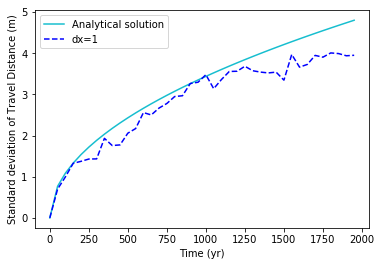

In [14]:
figure(3000)
plot(range(0,runtime,dt), analytical_std_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--b', label="dx=1")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left')

# Misc. tests:
## Insensitivity do dx
Following plot to show that mean travel distance does not depend on grid cell size:

CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.14722858]
slope_we_with_dev=-0.0438991558496
neighborhood
SW-C
change_x = -0.0772657142348
change_y = -0.521003655316
move_to
dist_to_travel:
0.07565336185404457
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[ 0.03112342]
slope_we_with_dev=0.00931218007309
neighborhood
SE-C
change_x = 0.0162475076804
change_y = -0.52186619393
move_to
dist_to_travel:
0.008387894677489939
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.03268574]
slope_we_with_dev=-0.0097794670496
neighborhood
SW-C
change_x = -0.0170635220711
change_y = -0.521861928877
move_to
dist_to_travel:
0.003302044617900514
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.08080185]
slope_we

MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.03117764]
slope_we_with_dev=-0.0093283972164
neighborhood
SW-C
change_x = -0.0162758256732
change_y = -0.521866049395
move_to
dist_to_travel:
0.008725211366073637
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.1131411]
slope_we_with_dev=-0.0337852855648
neighborhood
SW-C
change_x = -0.059241101046
change_y = -0.521367617539
move_to
dist_to_travel:
0.002698971799976982
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.08192449]
slope_we_with_dev=-0.0244884883895
neighborhood
SW-C
change_x = -0.0428294994136
change_y = -0.52162228253
move_to
dist_to_travel:
0.004528462596803768
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164

moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[ 0.06890693]
slope_we_with_dev=0.0206040832363
neighborhood
SE-C
change_x = 0.0360061117107
change_y = -0.521705264376
move_to
dist_to_travel:
0.005174275224285273
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.1097392]
slope_we_with_dev=-0.0327735839299
neighborhood
SW-C
change_x = -0.0574487208863
change_y = -0.521399106714
move_to
dist_to_travel:
0.0012549062867928196
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.03453961]
slope_we_with_dev=-0.0103339219475
neighborhood
SW-C
change_x = -0.0180318922767
change_y = -0.521856598533
move_to
dist_to_travel:
0.01158052558554858
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
dra

moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[ 0.16244848]
slope_we_with_dev=0.0483991794477
neighborhood
SE-C
change_x = 0.0853575879134
change_y = -0.520813822751
move_to
dist_to_travel:
0.04570933839988025
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[ 0.04362234]
slope_we_with_dev=0.0130498452644
neighborhood
SE-C
change_x = 0.0227777322728
change_y = -0.521826267475
move_to
dist_to_travel:
0.029836526046074247
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_dev=[-0.0149255]
slope_we_with_dev=-0.0044662914108
neighborhood
SW-C
change_x = -0.00779017166062
change_y = -0.521898140514
move_to
dist_to_travel:
0.021372362315132162
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164336594815
draw_

moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[ 0.09247138]
slope_we_with_dev=0.0275637325207
neighborhood
SE-C
change_x = 0.0433851785439
change_y = -0.467836049554
move_to
dist_to_travel:
0.016569972533114697
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[ 0.0938339]
slope_we_with_dev=0.0279686846632
neighborhood
SE-C
change_x = 0.0471425694112
change_y = -0.500929083207
move_to
dist_to_travel:
0.006067461876265339
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[ 0.0660711]
slope_we_with_dev=0.0197081257213
neighborhood
SE-C
change_x = 0.0339371834207
change_y = -0.51289874785
move_to
dist_to_travel:
0.018349085920873476
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=

elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[ 0.11834838]
slope_we_with_dev=0.0352450262314
neighborhood
SE-C
change_x = 0.0616850008315
change_y = -0.518779687165
move_to
dist_to_travel:
0.03176572490427833
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[-0.09281853]
slope_we_with_dev=-0.0276669123435
neighborhood
SW-C
change_x = -0.0465654429747
change_y = -0.500241086165
move_to
dist_to_travel:
0.019790204218645677
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[ 0.05771164]
slope_we_with_dev=0.0172175804315
neighborhood
SE-C
change_x = 0.0263062197554
change_y = -0.455315540318
move_to
dist_to_travel:
0.0033097683959324663
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[

SE-C
change_x = 0.0203642656637
change_y = -0.492531362555
move_to
dist_to_travel:
0.00045112037875405796
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[-0.01158541]
slope_we_with_dev=-0.0034582114992
neighborhood
SW-C
change_x = -0.0059243778874
change_y = -0.511342439832
move_to
dist_to_travel:
0.010988387438592002
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[ 0.10134344]
slope_we_with_dev=0.0301996403224
neighborhood
SE-C
change_x = 0.0529273786135
change_y = -0.520468401285
move_to
dist_to_travel:
0.0356754743276028
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165500139319
draw_dev=[ 0.04268301]
slope_we_with_dev=0.0127371705869
neighborhood
SE-C
change_x = 0.0215457526546
change_y = -0.50447862119
move_to
dist_to_travel:
0.09653489546241811
movin

[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[-0.08414188]
slope_we_with_dev=-0.0250246383046
neighborhood
SW-C
change_x = -0.0421289596894
change_y = -0.499507355408
move_to
dist_to_travel:
0.012448063847677118
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[-0.04098191]
slope_we_with_dev=-0.0121994078268
neighborhood
SW-C
change_x = -0.0187798188845
change_y = -0.457989998786
move_to
dist_to_travel:
0.007075498518194431
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[ 0.03521834]
slope_we_with_dev=0.0104844899089
neighborhood
SE-C
change_x = 0.0178537245585
change_y = -0.506734278169
move_to
dist_to_travel:
0.017915722335465973
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[ 0.15782425]
slope_we_with_dev=0.0467990956121
nei

change_x = -0.070445445956
change_y = -0.498962400262
move_to
dist_to_travel:
0.0037006466622447015
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[ 0.07425224]
slope_we_with_dev=0.022089128081
neighborhood
SE-C
change_x = 0.0356447182088
change_y = -0.479166494355
move_to
dist_to_travel:
0.009006383203376904
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[-0.13815798]
slope_we_with_dev=-0.0410073426226
neighborhood
SW-C
change_x = -0.0697491429346
change_y = -0.501634411524
move_to
dist_to_travel:
0.022203156805682037
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[ 0.10979937]
slope_we_with_dev=0.0326283419777
neighborhood
SE-C
change_x = 0.0534979761184
change_y = -0.485274325999
move_to
dist_to_travel:
0.015608474779392372
moving
MOVE

slope_we_with_dev=0.0285884237132
neighborhood
SE-C
change_x = 0.0473373776956
change_y = -0.490762258138
move_to
dist_to_travel:
0.0375992734552834
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[-0.1376665]
slope_we_with_dev=-0.0408623888375
neighborhood
SW-C
change_x = -0.0688036010573
change_y = -0.496623325991
move_to
dist_to_travel:
0.005108139235097148
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[ 0.13980671]
slope_we_with_dev=0.0414935366863
neighborhood
SE-C
change_x = 0.0641486274084
change_y = -0.455844611315
move_to
dist_to_travel:
0.028011620834768453
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16666643542
draw_dev=[-0.13906967]
slope_we_with_dev=-0.0412762063198
neighborhood
SW-C
change_x = -0.0697657284053
change_y = -0.498421988011
move_

0.00010157971132902528
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[-0.11111532]
slope_we_with_dev=-0.0329358706482
neighborhood
SW-C
change_x = -0.0558784174201
change_y = -0.500815336086
move_to
dist_to_travel:
0.0005051439440776718
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[-0.08289844]
slope_we_with_dev=-0.024594503782
neighborhood
SW-C
change_x = -0.0410332643882
change_y = -0.49384795681
move_to
dist_to_travel:
0.037076123303350396
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[ 0.01879877]
slope_we_with_dev=0.00558332675934
neighborhood
SE-C
change_x = 0.00929304894466
change_y = -0.494285273099
move_to
dist_to_travel:
0.0032877333001065283
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 

detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[ 0.13378371]
slope_we_with_dev=0.0396183340296
neighborhood
SE-C
change_x = 0.0668946990303
change_y = -0.497034534934
move_to
dist_to_travel:
0.01962766768439668
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[ 0.02100805]
slope_we_with_dev=0.006239403642
neighborhood
SE-C
change_x = 0.0100409839111
change_y = -0.477888502467
move_to
dist_to_travel:
0.027505564461133118
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[ 0.04311938]
slope_we_with_dev=0.0128034543084
neighborhood
SE-C
change_x = 0.0193529513476
change_y = -0.448544383871
move_to
dist_to_travel:
0.004697715307103857
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[-0.10816677]
slope_we_with_dev=-0.032065342

change_x = -0.027790776225
change_y = -0.498702184141
move_to
dist_to_travel:
0.010075528228247782
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[ 0.154508]
slope_we_with_dev=0.0457099625156
neighborhood
SE-C
change_x = 0.0765721435105
change_y = -0.491636960429
move_to
dist_to_travel:
0.0024411086868624927
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[ 0.11072139]
slope_we_with_dev=0.0328195832595
neighborhood
SE-C
change_x = 0.0533097812192
change_y = -0.479507674741
move_to
dist_to_travel:
0.03277597586727441
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167835448415
draw_dev=[-0.08486451]
slope_we_with_dev=-0.0251764162574
neighborhood
SW-C
change_x = -0.0411668668305
change_y = -0.48392423342
move_to
dist_to_travel:
0.015761414567367023
moving
MOVE

SW-C
change_x = -0.072679013356
change_y = -0.488067645617
move_to
dist_to_travel:
0.032557576340503186
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[-0.05706636]
slope_we_with_dev=-0.0168988643463
neighborhood
SW-C
change_x = -0.0286360745335
change_y = -0.501258186249
move_to
dist_to_travel:
0.01965125482986233
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[-0.0074014]
slope_we_with_dev=-0.00219291957554
neighborhood
SW-C
change_x = -0.00357381769068
change_y = -0.482848444831
move_to
dist_to_travel:
0.028082562635192085
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[ 0.06973902]
slope_we_with_dev=0.0206460416739
neighborhood
SE-C
change_x = 0.0320402261471
change_y = -0.458685347597
move_to
dist_to_travel:
0.012415811273620073
movi

moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[-0.1149985]
slope_we_with_dev=-0.0339975476673
neighborhood
SW-C
change_x = -0.0516887570649
change_y = -0.447490172547
move_to
dist_to_travel:
0.026372419589558018
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[ 0.0762501]
slope_we_with_dev=0.0225700521642
neighborhood
SE-C
change_x = 0.036654326832
change_y = -0.479779847926
move_to
dist_to_travel:
0.01856582294883427
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[-0.02727316]
slope_we_with_dev=-0.00807968849528
neighborhood
SW-C
change_x = -0.0118847648834
change_y = -0.435659800991
move_to
dist_to_travel:
0.00949556349343293
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_d

SE-C
change_x = 0.0371303838542
change_y = -0.422823687374
move_to
dist_to_travel:
0.056424528009900894
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[ 0.03562237]
slope_we_with_dev=0.0105522240488
neighborhood
SE-C
change_x = 0.0174130490095
change_y = -0.488616651242
move_to
dist_to_travel:
0.0028971368473797855
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[-0.04745018]
slope_we_with_dev=-0.0140536101031
neighborhood
SW-C
change_x = -0.02326603722
change_y = -0.489957574664
move_to
dist_to_travel:
0.004317642759785931
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169007143656
draw_dev=[-0.04171262]
slope_we_with_dev=-0.0123553361736
neighborhood
SW-C
change_x = -0.0186654481108
change_y = -0.447217689251
move_to
dist_to_travel:
0.05155063778597195
mov

max_dev=0.170181486562
draw_dev=[-0.16577551]
slope_we_with_dev=-0.0487718194255
neighborhood
SW-C
change_x = -0.0762242814322
change_y = -0.455584465521
move_to
dist_to_travel:
0.07377016941328804
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[ 0.0925751]
slope_we_with_dev=0.027322049721
neighborhood
SE-C
change_x = 0.0421837922334
change_y = -0.454368577192
move_to
dist_to_travel:
0.0101130920362177
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[-0.09696358]
slope_we_with_dev=-0.0286132700182
neighborhood
SW-C
change_x = -0.0433868510769
change_y = -0.446051929058
move_to
dist_to_travel:
0.013803927125383069
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[-0.09541862]
slope_we_with_dev=-0.0281587577575
neighborhood

moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[ 0.14115516]
slope_we_with_dev=0.0415808350727
neighborhood
SE-C
change_x = 0.0581875191402
change_y = -0.409482338067
move_to
dist_to_travel:
8.643829447067368e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[-0.02380554]
slope_we_with_dev=-0.00703520212218
neighborhood
SW-C
change_x = -0.0113741080196
change_y = -0.477702255968
move_to
dist_to_travel:
0.000800197116895896
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[ 0.15528699]
slope_we_with_dev=0.0457117468414
neighborhood
SE-C
change_x = 0.0698820676588
change_y = -0.4463957432
move_to
dist_to_travel:
0.02663768863297101
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev

SE-C
change_x = 0.00785516468672
change_y = -0.479810581171
move_to
dist_to_travel:
0.006476723632916729
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[ 0.00257331]
slope_we_with_dev=0.000760557301028
neighborhood
SE-C
change_x = 0.00102589924536
change_y = -0.398667549872
move_to
dist_to_travel:
0.010150213381569986
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[ 0.05878192]
slope_we_with_dev=0.0173633374473
neighborhood
SE-C
change_x = 0.0278444963889
change_y = -0.473145825368
move_to
dist_to_travel:
0.01170918363577574
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170181486562
draw_dev=[-0.12050014]
slope_we_with_dev=-0.0355283969106
neighborhood
SW-C
change_x = -0.0543483339535
change_y = -0.448837897929
move_to
dist_to_travel:
0.0038532506729527546

moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.0816031]
slope_we_with_dev=-0.0240321925637
neighborhood
SW-C
change_x = -0.0353573147986
change_y = -0.432321802485
move_to
dist_to_travel:
0.017914326387213676
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.00859208]
slope_we_with_dev=-0.00253315588172
neighborhood
SW-C
change_x = -0.00341384607411
change_y = -0.397314889715
move_to
dist_to_travel:
0.032725947941329145
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.11155786]
slope_we_with_dev=-0.0328222122486
neighborhood
SW-C
change_x = -0.0425782601559
change_y = -0.380085122008
move_to
dist_to_travel:
0.009311124407621272
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
dra

move_to
dist_to_travel:
0.008545161800046774
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.10075752]
slope_we_with_dev=-0.0296559109939
neighborhood
SW-C
change_x = -0.0430778061295
change_y = -0.426091563555
move_to
dist_to_travel:
0.012372634835688439
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[ 0.05760612]
slope_we_with_dev=0.0169745094715
neighborhood
SE-C
change_x = 0.0224532345412
change_y = -0.389340469626
move_to
dist_to_travel:
0.02129636819377798
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.12014679]
slope_we_with_dev=-0.0353374888896
neighborhood
SW-C
change_x = -0.053753095972
change_y = -0.445240350764
move_to
dist_to_travel:
0.02304113637228919
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phanto

detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[ 0.10058824]
slope_we_with_dev=0.0296062541275
neighborhood
SE-C
change_x = 0.0449213032495
change_y = -0.44507883125
move_to
dist_to_travel:
0.024231745873919373
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.02673603]
slope_we_with_dev=-0.00788159338126
neighborhood
SW-C
change_x = -0.0128435890274
change_y = -0.480270595224
move_to
dist_to_travel:
0.004435643128933991
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.04580937]
slope_we_with_dev=-0.0135011652544
neighborhood
SW-C
change_x = -0.0150234496428
change_y = -0.327726403318
move_to
dist_to_travel:
0.02054691647889372
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171358442619
draw_dev=[-0.00400012]
slope_we_with_dev=-0.0011

[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[ 0.01957718]
slope_we_with_dev=0.00575735910884
neighborhood
SE-C
change_x = 0.00726624143725
change_y = -0.371111255614
move_to
dist_to_travel:
0.0008642424888470811
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[-0.08952356]
slope_we_with_dev=-0.026294076942
neighborhood
SW-C
change_x = -0.0365895700349
change_y = -0.407621970498
move_to
dist_to_travel:
0.012103329087806033
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[ 0.06803675]
slope_we_with_dev=0.0199944416798
neighborhood
SE-C
change_x = 0.0317513499251
change_y = -0.465959122065
move_to
dist_to_travel:
0.05890870806243511
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[ 0.01913431]
slope_we_with_dev=0.00562713278847
ne

[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[-0.10279851]
slope_we_with_dev=-0.0301802280886
neighborhood
SW-C
change_x = -0.0418530737596
change_y = -0.40570179937
move_to
dist_to_travel:
0.010337226629411202
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[ 0.00402348]
slope_we_with_dev=0.00118331707432
neighborhood
SE-C
change_x = 0.00165348634917
change_y = -0.410957394151
move_to
dist_to_travel:
0.019250540234757814
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[ 0.00864369]
slope_we_with_dev=0.00254211155825
neighborhood
SE-C
change_x = 0.00352767695639
change_y = -0.408111492069
move_to
dist_to_travel:
0.003977872557645377
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[-0.13364932]
slope_we_with_dev=-0.03918987903

moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[ 0.06472949]
slope_we_with_dev=0.0190239082122
neighborhood
SE-C
change_x = 0.0222929918809
change_y = -0.343921248673
move_to
dist_to_travel:
0.03518066321625162
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[-0.00365738]
slope_we_with_dev=-0.00107564724781
neighborhood
SW-C
change_x = -0.00160815544881
change_y = -0.439699611831
move_to
dist_to_travel:
0.01894782875991576
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
draw_dev=[-0.08867529]
slope_we_with_dev=-0.0260455878871
neighborhood
SW-C
change_x = -0.0408435766173
change_y = -0.459389135337
move_to
dist_to_travel:
0.011150611520236624
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172537977389
dr

[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.15559813]
slope_we_with_dev=-0.045465932418
neighborhood
SW-C
change_x = -0.0610409191872
change_y = -0.389127461796
move_to
dist_to_travel:
0.03195995270702327
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.00522112]
slope_we_with_dev=-0.00153178404629
neighborhood
SW-C
change_x = -0.00175096599916
change_y = -0.335358872977
move_to
dist_to_travel:
0.007402706767902181
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.03780852]
slope_we_with_dev=-0.011089750976
neighborhood
SW-C
change_x = -0.0140012876349
change_y = -0.370144476302
move_to
dist_to_travel:
0.0020489731395918137
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[ 0.15629759]
slope_we_with_dev=0.0456686520929


[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.01329491]
slope_we_with_dev=-0.00390039182379
neighborhood
SW-C
change_x = -0.00511302629956
change_y = -0.384562535588
move_to
dist_to_travel:
0.02849928544040879
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.07041645]
slope_we_with_dev=-0.0206419501745
neighborhood
SW-C
change_x = -0.0278969535953
change_y = -0.395515964054
move_to
dist_to_travel:
0.009622789678050444
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.1580653]
slope_we_with_dev=-0.0461808757327
neighborhood
SW-C
change_x = -0.0623043966211
change_y = -0.390880509225
move_to
dist_to_travel:
0.03047210902414785
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.1315307]
slope_we_with_dev=-0.038477756982

moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[ 0.1608774]
slope_we_with_dev=0.0469954297494
neighborhood
SE-C
change_x = 0.0657764102838
change_y = -0.405327062439
move_to
dist_to_travel:
0.00784300754715969
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.09770271]
slope_we_with_dev=-0.0286187741877
neighborhood
SW-C
change_x = -0.0354750386902
change_y = -0.361935571901
move_to
dist_to_travel:
0.011194333550150969
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw_dev=[-0.08373065]
slope_we_with_dev=-0.0245364916752
neighborhood
SW-C
change_x = -0.0339923190165
change_y = -0.405023049247
move_to
dist_to_travel:
0.004560613264431096
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173720056509
draw

moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.12800019]
slope_we_with_dev=0.0373591561639
neighborhood
SE-C
change_x = 0.044378208041
change_y = -0.344808695002
move_to
dist_to_travel:
0.009299118911342353
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.08718058]
slope_we_with_dev=0.0254825274351
neighborhood
SE-C
change_x = 0.0341538074989
change_y = -0.390766321716
move_to
dist_to_travel:
0.0051021144090942815
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.07163792]
slope_we_with_dev=0.0209480907241
neighborhood
SE-C
change_x = 0.025690791266
change_y = -0.358006321557
move_to
dist_to_travel:
0.04757169042126769
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17490

moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.0132803]
slope_we_with_dev=0.00388658507356
neighborhood
SE-C
change_x = 0.00512633458711
change_y = -0.385987710872
move_to
dist_to_travel:
0.06282710129141549
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.1043686]
slope_we_with_dev=0.0304897699563
neighborhood
SE-C
change_x = 0.0378254666535
change_y = -0.3611050079
move_to
dist_to_travel:
0.008699106069290863
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.06515894]
slope_we_with_dev=0.0190563478867
neighborhood
SE-C
change_x = 0.0241513245248
change_y = -0.370127796464
move_to
dist_to_travel:
0.011185267227242168
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=

[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[-0.08329147]
slope_we_with_dev=-0.0243484468369
neighborhood
SW-C
change_x = -0.0292862895514
change_y = -0.350798643089
move_to
dist_to_travel:
0.008792931041707917
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.05389544]
slope_we_with_dev=0.0157657541174
neighborhood
SE-C
change_x = 0.0216076684678
change_y = -0.400530058807
move_to
dist_to_travel:
0.00042451711130907303
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[-0.11090562]
slope_we_with_dev=-0.0323918592398
neighborhood
SW-C
change_x = -0.0322308930059
change_y = -0.289423012035
move_to
dist_to_travel:
0.02378119858064769
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.12081584]
slope_we_with_dev=0.035272792641

dist_to_travel:
0.01387835851878521
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.16724636]
slope_we_with_dev=0.048719538254
neighborhood
SE-C
change_x = 0.0602756477891
change_y = -0.357033779926
move_to
dist_to_travel:
0.005353877308118187
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[-0.03332705]
slope_we_with_dev=-0.00975190661438
neighborhood
SW-C
change_x = -0.0134773698313
change_y = -0.40424754894
move_to
dist_to_travel:
0.00363615111542499
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174904645702
draw_dev=[ 0.03247335]
slope_we_with_dev=0.0095021901291
neighborhood
SE-C
change_x = 0.0120306345654
change_y = -0.370346977374
move_to
dist_to_travel:
0.0017483820267281045
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached

moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[ 0.003068]
slope_we_with_dev=0.000895710422429
neighborhood
SE-C
change_x = 0.00106830177984
change_y = -0.34820693474
move_to
dist_to_travel:
0.015407671636809592
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[-0.14229519]
slope_we_with_dev=-0.0414034770059
neighborhood
SW-C
change_x = -0.0477769510636
change_y = -0.333490213883
move_to
dist_to_travel:
0.0435833374779956
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[ 0.02361918]
slope_we_with_dev=0.00689505237725
neighborhood
SE-C
change_x = 0.00949902436166
change_y = -0.402099426306
move_to
dist_to_travel:
0.05910553227346755
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_

moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[-0.08781236]
slope_we_with_dev=-0.0256041605816
neighborhood
SW-C
change_x = -0.0298170356393
change_y = -0.338680752482
move_to
dist_to_travel:
0.007514390462660641
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[ 0.16616736]
slope_we_with_dev=0.0482901391402
neighborhood
SE-C
change_x = 0.0534356310232
change_y = -0.318611966646
move_to
dist_to_travel:
0.009552959027267372
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[ 0.07135168]
slope_we_with_dev=0.0208136763297
neighborhood
SE-C
change_x = 0.0300743390004
change_y = -0.420778963765
move_to
dist_to_travel:
0.005523883421421347
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw

moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[-0.14598629]
slope_we_with_dev=-0.0424699298305
neighborhood
SW-C
change_x = -0.0536720263544
change_y = -0.365035624955
move_to
dist_to_travel:
0.007682954226636661
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[ 0.14281479]
slope_we_with_dev=0.0415536369345
neighborhood
SE-C
change_x = 0.0593323902538
change_y = -0.412621536865
move_to
dist_to_travel:
0.013547543917052105
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw_dev=[ 0.12032598]
slope_we_with_dev=0.0350448421823
neighborhood
SE-C
change_x = 0.0414008324789
change_y = -0.342410120707
move_to
dist_to_travel:
0.050078463818829945
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.176091710778
draw

dist_to_travel:
0.053244679985526296
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[ 0.06550031]
slope_we_with_dev=0.0190628947189
neighborhood
SE-C
change_x = 0.0224886619315
change_y = -0.342845560917
move_to
dist_to_travel:
0.01449946471772571
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[-0.11674694]
slope_we_with_dev=-0.0339245848197
neighborhood
SW-C
change_x = -0.0376177462321
change_y = -0.320750879781
move_to
dist_to_travel:
0.014593773895650818
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[-0.03115602]
slope_we_with_dev=-0.00907251539062
neighborhood
SW-C
change_x = -0.00761437578582
change_y = -0.244315953472
move_to
dist_to_travel:
0.009225814909273372
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
de

[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[ 0.04160401]
slope_we_with_dev=0.0121133980092
neighborhood
SE-C
change_x = 0.0161032343079
change_y = -0.386836293124
move_to
dist_to_travel:
0.03592390030697183
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[-0.12612081]
slope_we_with_dev=-0.0366345494978
neighborhood
SW-C
change_x = -0.0530253808488
change_y = -0.418201666
move_to
dist_to_travel:
0.007038107567400486
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[ 0.11884114]
slope_we_with_dev=0.0345302801748
neighborhood
SE-C
change_x = 0.0490794898136
change_y = -0.411037959376
move_to
dist_to_travel:
0.0025868616036626435
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[ 0.07757243]
slope_we_with_dev=0.0225698056194
neig

move_to
dist_to_travel:
0.005352481166076828
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[ 0.06780029]
slope_we_with_dev=0.0197312591479
neighborhood
SE-C
change_x = 0.026970825056
change_y = -0.397188369067
move_to
dist_to_travel:
0.009411691435637111
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.177281217639
draw_dev=[ 0.15515031]
slope_we_with_dev=0.0450054326866
neighborhood
SE-C
change_x = 0.0548428771455
change_y = -0.350641369896
move_to
dist_to_travel:
0.01942929284412047
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[-0.15264237]
slope_we_with_dev=-0.0441762614862
neighborhood
SW-C
change_x = -0.0415199777818
change_y = -0.269892350076
move_to
dist_to_travel:
0.0157908577737804
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
det

moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[ 0.072915]
slope_we_with_dev=0.0211657500162
neighborhood
SE-C
change_x = 0.021962367976
change_y = -0.300671073554
move_to
dist_to_travel:
0.016928589728282095
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[ 0.17350969]
slope_we_with_dev=0.0501584464143
neighborhood
SE-C
change_x = 0.054537362035
change_y = -0.311158228273
move_to
dist_to_travel:
0.007646887696678164
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[-0.11185409]
slope_we_with_dev=-0.032430045563
neighborhood
SW-C
change_x = -0.0376911636206
change_y = -0.335560750164
move_to
dist_to_travel:
0.0040888867960661955
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.

max_dev=0.178473132285
draw_dev=[-0.09993193]
slope_we_with_dev=-0.0289856378055
neighborhood
SW-C
change_x = -0.0379958418803
change_y = -0.37895071524
move_to
dist_to_travel:
0.018921852391409248
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[-0.15796349]
slope_we_with_dev=-0.0457036356473
neighborhood
SW-C
change_x = -0.0461947317362
change_y = -0.290002882236
move_to
dist_to_travel:
0.009019853113779995
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[-0.17167858]
slope_we_with_dev=-0.0496343457114
neighborhood
SW-C
change_x = -0.063471307371
change_y = -0.366070738076
move_to
dist_to_travel:
0.012087747120976544
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[-0.00638491]
slope_we_with_dev=-0.00185503962006
neighborhood
SW-C
chang

dist_to_travel:
0.007144319317019107
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[ 0.04905062]
slope_we_with_dev=0.0142453140364
neighborhood
SE-C
change_x = 0.0139504148058
change_y = -0.284180379798
move_to
dist_to_travel:
0.016878566122418098
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[-0.09776168]
slope_we_with_dev=-0.0283581772529
neighborhood
SW-C
change_x = -0.028310734697
change_y = -0.288666122057
move_to
dist_to_travel:
0.02064786349432149
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.178473132285
draw_dev=[ 0.04121895]
slope_we_with_dev=0.0119722460931
neighborhood
SE-C
change_x = 0.0159942745844
change_y = -0.387812255372
move_to
dist_to_travel:
0.0050415793301428966
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detach

[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.16988668]
slope_we_with_dev=0.0490024987726
neighborhood
SE-C
change_x = 0.0551116333737
change_y = -0.321275388366
move_to
dist_to_travel:
0.015187823410235356
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.13890152]
slope_we_with_dev=0.0401291114978
neighborhood
SE-C
change_x = 0.0409352857352
change_y = -0.292809494507
move_to
dist_to_travel:
0.033035744437325945
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.15170369]
slope_we_with_dev=0.0438004951485
neighborhood
SE-C
change_x = 0.0337978392449
change_y = -0.221076801966
move_to
dist_to_travel:
0.018595601013005086
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[-0.15350619]
slope_we_with_dev=-0.0443168498112
ne

SE-C
change_x = 0.00459256667411
change_y = -0.390054003319
move_to
dist_to_travel:
0.0019132922680824185
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.12687583]
slope_we_with_dev=0.0366744054218
neighborhood
SE-C
change_x = 0.0277933273264
change_y = -0.217882571371
move_to
dist_to_travel:
0.008242893811762369
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.10629366]
slope_we_with_dev=0.0307495825541
neighborhood
SE-C
change_x = 0.0348218089775
change_y = -0.326365347061
move_to
dist_to_travel:
0.028923212955972787
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.13462595]
slope_we_with_dev=0.0389014771844
neighborhood
SE-C
change_x = 0.0384011176681
change_y = -0.283517708863
move_to
dist_to_travel:
0.016605613719161336
mov

neighborhood
SW-C
change_x = -0.020065604825
change_y = -0.246322361402
move_to
dist_to_travel:
0.0007782644282295132
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.03358879]
slope_we_with_dev=0.00973335826699
neighborhood
SE-C
change_x = 0.00937820397038
change_y = -0.279101327078
move_to
dist_to_travel:
0.03624903353591114
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[ 0.05092596]
slope_we_with_dev=0.0147537180603
neighborhood
SE-C
change_x = 0.0165962945534
change_y = -0.325608865425
move_to
dist_to_travel:
0.0004949900862923317
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.179667420816
draw_dev=[-0.06057946]
slope_we_with_dev=-0.0175472752448
neighborhood
SW-C
change_x = -0.015447774999
change_y = -0.254688202377
move_to
dist_to_travel:
0.0049283

detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[-0.15702305]
slope_we_with_dev=-0.045214555086
neighborhood
SW-C
change_x = -0.0320823704898
change_y = -0.202634323447
move_to
dist_to_travel:
0.02927608798915716
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[ 0.15682021]
slope_we_with_dev=0.0451566284504
neighborhood
SE-C
change_x = 0.049329407474
change_y = -0.311977412221
move_to
dist_to_travel:
0.007922378906665993
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[ 0.09820821]
slope_we_with_dev=0.0283498312488
neighborhood
SE-C
change_x = 0.0212467795046
change_y = -0.215648234803
move_to
dist_to_travel:
0.01583202404345153
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[ 0.12629079]
slope_we_with_dev=0.0364181278

change_x = 0.0423222120203
change_y = -0.297359295803
move_to
dist_to_travel:
0.018237470313441233
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[-0.0766978]
slope_we_with_dev=-0.0221543003915
neighborhood
SW-C
change_x = -0.0205384552042
change_y = -0.267258855301
move_to
dist_to_travel:
0.0033035321305169493
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[ 0.0210282]
slope_we_with_dev=0.0060795440052
neighborhood
SE-C
change_x = 0.00810743040875
change_y = -0.385493621849
move_to
dist_to_travel:
0.004650881797144436
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[ 0.0471789]
slope_we_with_dev=0.0136360216348
neighborhood
SE-C
change_x = 0.0160270229604
change_y = -0.339455354771
move_to
dist_to_travel:
0.004935035274293537
moving
MO

max_dev=0.180864049438
draw_dev=[-0.02000195]
slope_we_with_dev=-0.00578288211657
neighborhood
SW-C
change_x = -0.00485794290974
change_y = -0.242841094849
move_to
dist_to_travel:
0.016006565655620208
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[-0.14076736]
slope_we_with_dev=-0.0405665186295
neighborhood
SW-C
change_x = -0.0460022006315
change_y = -0.324634533789
move_to
dist_to_travel:
0.007444214054778123
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[-0.05131482]
slope_we_with_dev=-0.0148304128378
neighborhood
SW-C
change_x = -0.0128267456004
change_y = -0.24974235164
move_to
dist_to_travel:
0.04599123767893938
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.180864049438
draw_dev=[ 0.16256675]
slope_we_with_dev=0.0467970122902
neighborhood
SE-C
chang

change_x = -0.0351696663041
change_y = -0.215398983606
move_to
dist_to_travel:
0.010167142760476859
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[ 0.17112893]
slope_we_with_dev=0.0491197758788
neighborhood
SE-C
change_x = 0.0585130870728
change_y = -0.33857970292
move_to
dist_to_travel:
0.001525930102306406
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[ 0.01800809]
slope_we_with_dev=0.00519396398281
neighborhood
SE-C
change_x = 0.00406694494822
change_y = -0.225815461973
move_to
dist_to_travel:
0.02223177487632685
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[-0.17449014]
slope_we_with_dev=-0.050074840358
neighborhood
SW-C
change_x = -0.0436017623057
change_y = -0.247339770195
move_to
dist_to_travel:
0.01008249395832537
moving
MO

moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[ 0.13235018]
slope_we_with_dev=0.0380636706022
neighborhood
SE-C
change_x = 0.0367774990393
change_y = -0.276255823894
move_to
dist_to_travel:
0.012886727020162185
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[-0.06848717]
slope_we_with_dev=-0.0197389673782
neighborhood
SW-C
change_x = -0.0245474134821
change_y = -0.357862944552
move_to
dist_to_travel:
0.011715672118569808
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[-0.12613846]
slope_we_with_dev=-0.0362869092061
neighborhood
SW-C
change_x = -0.026339707139
change_y = -0.207707175415
move_to
dist_to_travel:
0.023322509972694565
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
dra

elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[-0.10311411]
slope_we_with_dev=-0.029689504428
neighborhood
SW-C
change_x = -0.023450890006
change_y = -0.22661998326
move_to
dist_to_travel:
0.0009242946629050339
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[-0.01045319]
slope_we_with_dev=-0.00301505843803
neighborhood
SW-C
change_x = -0.00332084656881
change_y = -0.317675765018
move_to
dist_to_travel:
0.0198909692229692
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev=[-0.12675576]
slope_we_with_dev=-0.0364635423226
neighborhood
SW-C
change_x = -0.0259426067398
change_y = -0.203568797071
move_to
dist_to_travel:
0.030885881781035095
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.182062984469
draw_dev

detached
[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[ 0.02312285]
slope_we_with_dev=0.00665294463229
neighborhood
SE-C
change_x = 0.00690137292257
change_y = -0.298412266529
move_to
dist_to_travel:
0.0009402075353636758
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[ 0.16339479]
slope_we_with_dev=0.0468074752847
neighborhood
SE-C
change_x = 0.0397014367762
change_y = -0.240812408827
move_to
dist_to_travel:
0.023174254949186728
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[-0.02721869]
slope_we_with_dev=-0.00783113581444
neighborhood
SW-C
change_x = -0.00413390102018
change_y = -0.151839797353
move_to
dist_to_travel:
0.013238749454210677
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[-0.0751936]
slope_we_with_dev=-0.0

[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[ 0.10635657]
slope_we_with_dev=0.0305461475083
neighborhood
SE-C
change_x = 0.0292768446582
change_y = -0.274231962366
move_to
dist_to_travel:
0.010994923803298164
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[ 0.03052271]
slope_we_with_dev=0.00878146235839
neighborhood
SE-C
change_x = 0.00953431553655
change_y = -0.312270918969
move_to
dist_to_travel:
0.008133809082128416
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[-0.14624193]
slope_we_with_dev=-0.0419308815399
neighborhood
SW-C
change_x = -0.0262136579112
change_y = -0.17796890314
move_to
dist_to_travel:
0.05706739977940486
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.183264192339
draw_dev=[-0.00549977]
slope_we_with_dev=-0.00158253653368

CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[-0.09052862]
slope_we_with_dev=-0.0259515257722
neighborhood
SW-C
change_x = -0.0105103963149
change_y = -0.115782921846
move_to
dist_to_travel:
0.0018474750723487547
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.03403902]
slope_we_with_dev=0.00976930328795
neighborhood
SE-C
change_x = 0.00765974990847
change_y = -0.224941563333
move_to
dist_to_travel:
0.008387035716930344
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.05030803]
slope_we_with_dev=0.0144352562129
neighborhood
SE-C
change_x = 0.00837606847824
change_y = -0.16635515853
move_to
dist_to_travel:
0.0550425252418743
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[-0.08481987]
slope_we

not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.02393078]
slope_we_with_dev=0.00686887691876
neighborhood
SE-C
change_x = 0.00585711239746
change_y = -0.24470554618
move_to
dist_to_travel:
0.013064039961621407
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[-0.12971103]
slope_we_with_dev=-0.0371303248192
neighborhood
SW-C
change_x = -0.038504720819
change_y = -0.295183318593
move_to
dist_to_travel:
0.0016049006309599143
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.17999595]
slope_we_with_dev=0.0513908128385
neighborhood
SE-C
change_x = 0.0669231364449
change_y = -0.367779560082
move_to
dist_to_travel:
0.0007870535527881012
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.0

dist_to_travel:
0.012114237594604716
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.13048244]
slope_we_with_dev=0.0373498939353
neighborhood
SE-C
change_x = 0.0310276865758
change_y = -0.236440990875
move_to
dist_to_travel:
0.02047580335408324
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.01997598]
slope_we_with_dev=0.00573389184138
neighborhood
SE-C
change_x = 0.0054909373964
change_y = -0.274840478606
move_to
dist_to_travel:
0.00802379459079365
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.184467639596
draw_dev=[ 0.08963935]
slope_we_with_dev=0.0256972872834
neighborhood
SE-C
change_x = 0.0270122162952
change_y = -0.300535746729
move_to
dist_to_travel:
0.014825632840209244
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached

SW-C
change_x = -0.031371209894
change_y = -0.181169581356
move_to
dist_to_travel:
0.015867021801405413
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[ 0.04192055]
slope_we_with_dev=0.0120014029174
neighborhood
SE-C
change_x = 0.0112153931357
change_y = -0.26738251333
move_to
dist_to_travel:
0.006367173838908917
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[ 0.08344266]
slope_we_with_dev=0.0238680133282
neighborhood
SE-C
change_x = 0.0222852676189
change_y = -0.266452701526
move_to
dist_to_travel:
0.004918435699943871
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[ 0.16983318]
slope_we_with_dev=0.0484021890855
neighborhood
SE-C
change_x = 0.0556352692806
change_y = -0.32443211234
move_to
dist_to_travel:
0.006429452175958776
moving


max_dev=0.185673292912
draw_dev=[-0.08378653]
slope_we_with_dev=-0.0239661453682
neighborhood
SW-C
change_x = -0.00774788061015
change_y = -0.0922551791781
move_to
dist_to_travel:
0.014197659177034647
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[ 0.06584869]
slope_we_with_dev=0.0188436695295
neighborhood
SE-C
change_x = 0.021999797891
change_y = -0.333613179226
move_to
dist_to_travel:
0.011410182380451465
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[-0.02073975]
slope_we_with_dev=-0.00593888152689
neighborhood
SW-C
change_x = -0.00314962450742
change_y = -0.151842353817
move_to
dist_to_travel:
0.020530502250299936
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[ 0.11323523]
slope_we_with_dev=0.0323582699281
n

[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[-0.05567282]
slope_we_with_dev=-0.0159349629784
neighborhood
SW-C
change_x = -0.0156612625809
change_y = -0.281018268431
move_to
dist_to_travel:
0.024392889192992265
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[ 0.09447905]
slope_we_with_dev=0.0270160249305
neighborhood
SE-C
change_x = 0.0219789240423
change_y = -0.231940185105
move_to
dist_to_travel:
0.026880027685094416
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[ 0.14544347]
slope_we_with_dev=0.0415044073846
neighborhood
SE-C
change_x = 0.0353724342069
change_y = -0.241486681633
move_to
dist_to_travel:
0.01295219624193103
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.185673292912
draw_dev=[-0.16524362]
slope_we_with_dev=-0.0471062669675
n

draw_dev=[-0.06190336]
slope_we_with_dev=-0.0176739495811
neighborhood
SW-C
change_x = -0.0102775343936
change_y = -0.16581334424
move_to
dist_to_travel:
0.008547812436353705
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[ 0.14369306]
slope_we_with_dev=0.0409107125764
neighborhood
SE-C
change_x = 0.0377081179398
change_y = -0.260612659358
move_to
dist_to_travel:
0.0075625693490344115
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.13343318]
slope_we_with_dev=-0.0380076603171
neighborhood
SW-C
change_x = -0.0350741715968
change_y = -0.261297575564
move_to
dist_to_travel:
0.004205769194139237
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.08309899]
slope_we_with_dev=-0.0237133342006
neighborhood
SW-C
change_x = -0.0265318088712
c

detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.0496919]
slope_we_with_dev=-0.0141906947228
neighborhood
SW-C
change_x = -0.013125329775
change_y = -0.263916744501
move_to
dist_to_travel:
0.0006542340513394308
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.02710158]
slope_we_with_dev=-0.00774173378835
neighborhood
SW-C
change_x = -0.00233411476444
change_y = -0.0861035866434
move_to
dist_to_travel:
0.0027568274819044776
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[ 0.14827148]
slope_we_with_dev=0.0422048119991
neighborhood
SE-C
change_x = 0.0363696751977
change_y = -0.243490935955
move_to
dist_to_travel:
0.020187358276958715
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.16174959]
slope_we_with_dev=-0.

[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.18493515]
slope_we_with_dev=-0.052533687248
neighborhood
SW-C
change_x = -0.0391141090448
change_y = -0.209085049572
move_to
dist_to_travel:
0.015623933109756185
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.09522865]
slope_we_with_dev=-0.0271648815749
neighborhood
SW-C
change_x = -0.0237726149309
change_y = -0.248882154147
move_to
dist_to_travel:
0.0027463358381997686
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[ 0.05663636]
slope_we_with_dev=0.0161718591667
neighborhood
SE-C
change_x = 0.00835365392948
change_y = -0.147338557734
move_to
dist_to_travel:
0.013288321996156718
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.186881119083
draw_dev=[-0.03606864]
slope_we_with_dev=-0.01030225676

[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.01778253]
slope_we_with_dev=0.00506797902769
neighborhood
SE-C
change_x = 0.00388075619299
change_y = -0.218211151283
move_to
dist_to_travel:
0.022134559165260713
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[-0.08318158]
slope_we_with_dev=-0.0236804674547
neighborhood
SW-C
change_x = -0.0116711810476
change_y = -0.139985930037
move_to
dist_to_travel:
0.009296527248980405
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[-0.11513944]
slope_we_with_dev=-0.0327437329742
neighborhood
SW-C
change_x = -0.0289978786995
change_y = -0.250736168185
move_to
dist_to_travel:
0.00673957325365729
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.13549917]
slope_we_with_dev=0.038500907179

[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[-0.17234146]
slope_we_with_dev=-0.0488766942562
neighborhood
SW-C
change_x = -0.0388808219882
change_y = -0.223365392016
move_to
dist_to_travel:
0.004280271749563284
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.00785483]
slope_we_with_dev=0.00223870398181
neighborhood
SE-C
change_x = 0.00243557474401
change_y = -0.310066927496
move_to
dist_to_travel:
0.022741402027426073
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.11855198]
slope_we_with_dev=0.0337097179741
neighborhood
SE-C
change_x = 0.024436770504
change_y = -0.20516046419
move_to
dist_to_travel:
0.01887795424661398
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.16818665]
slope_we_with_dev=0.0477096457303
ne

detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.0126878]
slope_we_with_dev=0.0036160861019
neighborhood
SE-C
change_x = 0.00273317228112
change_y = -0.215405775136
move_to
dist_to_travel:
0.0006094027579460904
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[-0.14234016]
slope_we_with_dev=-0.0404318856682
neighborhood
SW-C
change_x = -0.0368006572964
change_y = -0.256791800655
move_to
dist_to_travel:
0.02332921537627054
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.03970268]
slope_we_with_dev=0.0113127919184
neighborhood
SE-C
change_x = 0.0108794893654
change_y = -0.273880051217
move_to
dist_to_travel:
0.009502115578550087
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.188091085037
draw_dev=[ 0.13711016]
slope

MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[ 0.06848805]
slope_we_with_dev=0.0194584959688
neighborhood
SE-C
change_x = 0.00772501209787
change_y = -0.112617162623
move_to
dist_to_travel:
0.0035116509560395954
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[-0.17326339]
slope_we_with_dev=-0.0490191457032
neighborhood
SW-C
change_x = -0.0162606816709
change_y = -0.0929084814033
move_to
dist_to_travel:
0.011791260563049346
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[ 0.10679995]
slope_we_with_dev=0.030309526905
neighborhood
SE-C
change_x = 0.0101381630387
change_y = -0.0945654717507
move_to
dist_to_travel:
0.01707384318901802
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.18

0.02388866085173832
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[-0.09403799]
slope_we_with_dev=-0.026699130673
neighborhood
SW-C
change_x = -0.00613480631704
change_y = -0.0650451119191
move_to
dist_to_travel:
0.08055328512907205
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[ 0.16423586]
slope_we_with_dev=0.0464887492469
SE-C
change_x = 0.0107658786129
change_y = -0.0649608839363
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[ 0.12220883]
slope_we_with_dev=0.0346621137881
neighborhood
SE-C
change_x = 0.0367263623094
change_y = -0.299023767535
move_to
dist_to_travel:
0.004096606990787132
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[ 0.02648605]
slope_we_with_dev=0.0075300

MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[ 0.04307288]
slope_we_with_dev=0.012243446253
neighborhood
SE-C
change_x = 0.007798345354
change_y = -0.18093801668
move_to
dist_to_travel:
0.03796083893018103
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[ 0.08710016]
slope_we_with_dev=0.0247345347742
neighborhood
SE-C
change_x = 0.0187426133586
change_y = -0.214640155509
move_to
dist_to_travel:
0.007899883755230779
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.189303157835
draw_dev=[-0.05905222]
slope_we_with_dev=-0.0167810004523
neighborhood
SW-C
change_x = -0.0138309433732
change_y = -0.233943142959
move_to
dist_to_travel:
0.020747517892138207
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.18930315

[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[ 0.07373774]
slope_we_with_dev=0.0208979112911
neighborhood
SE-C
change_x = 0.0109908675524
change_y = -0.148783246778
move_to
dist_to_travel:
0.0014058561940065288
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[ 0.12555396]
slope_we_with_dev=0.0355218431969
neighborhood
SE-C
change_x = 0.0270643691472
change_y = -0.214425788793
move_to
dist_to_travel:
0.012218115073966699
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[-0.1263944]
slope_we_with_dev=-0.0357583587626
neighborhood
SW-C
change_x = -0.0314714874982
change_y = -0.247666957272
move_to
dist_to_travel:
0.004163751526074386
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[ 0.09068584]
slope_we_with_dev=0.0256892085405
n

CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[-0.10258145]
slope_we_with_dev=-0.0290478216615
neighborhood
SW-C
change_x = -0.0217841167001
change_y = -0.211613822961
move_to
dist_to_travel:
0.036674938985577867
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[ 0.16635884]
slope_we_with_dev=0.0469729172518
neighborhood
SE-C
change_x = 0.0269880699791
change_y = -0.160728709905
move_to
dist_to_travel:
0.012242521308919514
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[-0.05043326]
slope_we_with_dev=-0.0143001184247
neighborhood
SW-C
change_x = -0.0104360055683
change_y = -0.206751567776
move_to
dist_to_travel:
0.040726265930368495
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[-0.00771344]
slo

[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[ 0.13815718]
slope_we_with_dev=0.039065886309
neighborhood
SE-C
change_x = 0.0329848378787
change_y = -0.237227667597
move_to
dist_to_travel:
0.0006878258039192001
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[-0.05216117]
slope_we_with_dev=-0.0147896229715
neighborhood
SW-C
change_x = -0.00979833454889
change_y = -0.18767688026
move_to
dist_to_travel:
0.02382935749575125
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[-0.13133696]
slope_we_with_dev=-0.0371487658718
neighborhood
SW-C
change_x = -0.0300401469067
change_y = -0.227409122173
move_to
dist_to_travel:
0.02104996349878753
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.190517304675
draw_dev=[-0.13463427]
slope_we_with_dev=-0.0380758412711


moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[ 0.05846069]
slope_we_with_dev=0.0165347853602
neighborhood
SE-C
change_x = 0.014721783643
change_y = -0.251536700511
move_to
dist_to_travel:
0.006833084833217196
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[ 0.14377738]
slope_we_with_dev=0.0405485466436
neighborhood
SE-C
change_x = 0.011816896106
change_y = -0.0816217245865
move_to
dist_to_travel:
0.029639181179014505
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[-0.17023093]
slope_we_with_dev=-0.047942530776
neighborhood
SW-C
change_x = -0.0101123014199
change_y = -0.0588285104254
move_to
dist_to_travel:
0.008788711365579495
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_

SW-C
change_x = -0.00520069485792
change_y = -0.246656821494
move_to
dist_to_travel:
0.0013565191438370944
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[-0.04281513]
slope_we_with_dev=-0.0121128574948
neighborhood
SW-C
change_x = -0.00204329722107
change_y = -0.0476945531684
move_to
dist_to_travel:
0.004406342353294166
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[-0.07734295]
slope_we_with_dev=-0.0218660171077
neighborhood
SW-C
change_x = -0.0152225563886
change_y = -0.196426328233
move_to
dist_to_travel:
0.023984033318156125
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[ 0.18130866]
slope_we_with_dev=0.051029178229
neighborhood
SE-C
change_x = 0.0418287796816
change_y = -0.228171275195
move_to
dist_to_travel:
0.0075343209290584

moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[-0.14630418]
slope_we_with_dev=-0.0412561161535
neighborhood
SW-C
change_x = -0.0205761293491
change_y = -0.139634486989
move_to
dist_to_travel:
0.0028714273481922487
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[-0.07645708]
slope_we_with_dev=-0.0216160602439
neighborhood
SW-C
change_x = -0.014213352736
change_y = -0.185537382953
move_to
dist_to_travel:
0.014344030841033414
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
draw_dev=[ 0.0679724]
slope_we_with_dev=0.0192211866863
neighborhood
SE-C
change_x = 0.0135991728795
change_y = -0.199760813363
move_to
dist_to_travel:
0.0017731214290555076
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.191733492896
dr

change_x = 0.00721793951101
change_y = -0.0501883747185
move_to
dist_to_travel:
0.002179225304593722
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[-0.0168755]
slope_we_with_dev=-0.00476426801757
neighborhood
SW-C
change_x = -0.000785745517719
change_y = -0.0465568854711
move_to
dist_to_travel:
0.014405258501932024
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[ 0.08909958]
slope_we_with_dev=0.0251223911518
neighborhood
SE-C
change_x = 0.0104119282089
change_y = -0.116547809934
move_to
dist_to_travel:
0.019426931517937673
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[-0.06784437]
slope_we_with_dev=-0.0191399444064
neighborhood
SW-C
change_x = -0.00408079901753
change_y = -0.0600570986554
move_to
dist_to_travel:
0.00768852634056027


MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[-0.17498305]
slope_we_with_dev=-0.0491515857122
neighborhood
SW-C
change_x = -0.00103581805438
change_y = -0.00585899249322
move_to
dist_to_travel:
0.01301316758499689
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 52
3
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.04990855441
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[ 0.08988854]
slope_we_with_dev=0.0253442483693
neighborhood
SE-C
change_x = 0.0220931228866
change_y = -0.245121199471
move_to
dist_to_travel:
0.002434145336737807
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=

SE-C
change_x = 0.00262475874741
change_y = -0.136977650376
move_to
dist_to_travel:
0.007344604675652503
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[ 0.09884511]
slope_we_with_dev=0.0278617164323
neighborhood
SE-C
change_x = 0.0169733618217
change_y = -0.171157139076
move_to
dist_to_travel:
0.01843507356907833
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[ 0.0716674]
slope_we_with_dev=0.0202166833855
neighborhood
SE-C
change_x = 0.0142109122958
change_y = -0.197950163469
move_to
dist_to_travel:
0.006282995823696832
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.192951689983
draw_dev=[ 0.02843237]
slope_we_with_dev=0.00802628516194
neighborhood
SE-C
change_x = 0.0069892010317
change_y = -0.245752228509
move_to
dist_to_travel:
0.010635232471399277
movin

neighborhood
SW-C
change_x = -0.00695559926369
change_y = -0.181571801765
move_to
dist_to_travel:
0.0009277956117557952
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[-0.14326115]
slope_we_with_dev=-0.040214500696
neighborhood
SW-C
change_x = -0.03499257321
change_y = -0.242583917072
move_to
dist_to_travel:
0.0071618193889019955
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[-0.13446097]
slope_we_with_dev=-0.0377596200864
neighborhood
SW-C
change_x = -0.0325069572906
change_y = -0.240298832088
move_to
dist_to_travel:
0.0024931969440279826
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[-0.15191981]
slope_we_with_dev=-0.0426268636902
neighborhood
SW-C
change_x = -0.00708414191964
change_y = -0.0462715028235
move_to
dist_to_travel:
0.0

moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[-0.07678465]
slope_we_with_dev=-0.0216066968287
neighborhood
SW-C
change_x = -0.00982231963491
change_y = -0.127668853492
move_to
dist_to_travel:
0.003902664594883534
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[-0.07585167]
slope_we_with_dev=-0.0213446685827
neighborhood
SW-C
change_x = -0.0189555147643
change_y = -0.249422958429
move_to
dist_to_travel:
0.016157472309070834
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 59
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.02178890245
move_to
dist_to_travel:
0.012665091373515843
moving
MOVE IN CELL
moved
elevation 

moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[-0.14892792]
slope_we_with_dev=-0.041793654013
neighborhood
SW-C
change_x = -0.00447240647864
change_y = -0.0298083266481
move_to
dist_to_travel:
0.0020992084740464956
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[ 0.13947638]
slope_we_with_dev=0.0391590794019
neighborhood
SE-C
change_x = 0.0148365328448
change_y = -0.105682403627
move_to
dist_to_travel:
0.0032793159650756345
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.194171863566
draw_dev=[ 0.17045095]
slope_we_with_dev=0.0477787997086
neighborhood
SE-C
change_x = 0.0217430697618
change_y = -0.126324257343
move_to
dist_to_travel:
0.014411175365565087
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or

MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[-0.09353867]
slope_we_with_dev=-0.0262471359255
neighborhood
SW-C
change_x = -0.00824002324363
change_y = -0.0878350847869
move_to
dist_to_travel:
0.007350986562601253
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[-0.17639225]
slope_we_with_dev=-0.0493116175685
neighborhood
SW-C
change_x = -0.00776507516275
change_y = -0.0435641182819
move_to
dist_to_travel:
0.006853105131900054
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[ 0.18196161]
slope_we_with_dev=0.0508516145557
neighborhood
SE-C
change_x = 0.0109199083167
change_y = -0.059348353992
move_to
dist_to_travel:
0.013410708258205882
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.1

[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[-0.1695322]
slope_we_with_dev=-0.0474126307528
neighborhood
SW-C
change_x = -0.0290897131177
change_y = -0.16994109337
move_to
dist_to_travel:
0.0328963552881014
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[ 0.10665426]
slope_we_with_dev=0.0299142937466
neighborhood
SE-C
change_x = 0.0143666813178
change_y = -0.134192159691
move_to
dist_to_travel:
0.008812290464547113
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[-0.03226053]
slope_we_with_dev=-0.00906400928884
neighborhood
SW-C
change_x = -0.00200722377228
change_y = -0.0621975978409
move_to
dist_to_travel:
0.004511952870050402
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[ 0.13007182]
slope_we_with_dev

moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[ 0.09682796]
slope_we_with_dev=0.0271672808887
neighborhood
SE-C
change_x = 0.0109037646487
change_y = -0.112257514386
move_to
dist_to_travel:
0.043551783406297305
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 97
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.01130875994
move_to
dist_to_travel:
0.011231527559272522
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.19539398143
draw_dev=[-0.18435566]
slope_we_with_dev=-0.0515131168684
neighborhood
SW-C
change_x = -0.0354526262772
change_y = -0.19012202301
move_to
dist_to_travel:
0.002925589459341914
moving
MOVE IN CELL
moved
elevation update

draw_dev=[ 0.0642746]
slope_we_with_dev=0.0180073821092
neighborhood
SE-C
change_x = 0.00293053390989
change_y = -0.0455311638658
move_to
dist_to_travel:
0.006233685627080905
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.196618011511
draw_dev=[ 0.13234073]
slope_we_with_dev=0.036994346813
neighborhood
SE-C
change_x = 0.00202086538631
change_y = -0.0151809173202
move_to
dist_to_travel:
0.022801347779085532
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.196618011511
draw_dev=[ 0.023198]
slope_we_with_dev=0.0065031206287
SE-C
change_x = 0.000352656288171
change_y = -0.0151992840478
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.196618011511
draw_dev=[-0.15202698]
slope_we_with_dev=-0.0424577278832
neighborhood
SW-C
change_x = -0.00744237193348
change_y = -0.0485765547676
move_to
dist_to_travel:
0.003509757979434518
moving
MOVE IN CELL
moved
elevation 

MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 69
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.03954428768
move_to
dist_to_travel:
0.010238576898992387
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.196618011511
draw_dev=[ 0.16325334]
slope_we_with_dev=0.0455660669685
neighborhood
SE-C
change_x = 0.023952783088
change_y = -0.145415770553
move_to
dist_to_travel:
0.04041268496329899
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.196618011511
draw_dev=[-0.15482094]
slope_we_with_dev=-0.0432318306013
neighborhood
SW-C
change_x = -0.0320823942722
change_y = -0.205564255316
move_to
dist_to_travel:
0.037967409197081144
moving
MOVE IN CELL
moved
el

[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[-0.16308528]
slope_we_with_dev=-0.0454137093339
neighborhood
SW-C
change_x = -0.00811689886767
change_y = -0.0493288507019
move_to
dist_to_travel:
0.012964209711223992
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[-0.09467739]
slope_we_with_dev=-0.0264421229587
neighborhood
SW-C
change_x = -0.0166690824606
change_y = -0.175535532843
move_to
dist_to_travel:
0.003568329824233238
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
CLAST 3
not phantom
CLAST 4
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 4
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.959393539385
move_to
dist_to_travel:
0.035445993265979636
moving
MOVE IN CELL
moved
elevation updated
CLAST 5

move_to
dist_to_travel:
0.005792617858816589
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[ 0.18370015]
slope_we_with_dev=0.0510932131888
neighborhood
SE-C
change_x = 0.0182319730377
change_y = -0.0981296204512
move_to
dist_to_travel:
0.0737098051250332
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[ 0.02381033]
slope_we_with_dev=0.00665922175081
neighborhood
SE-C
change_x = 0.00229956365904
change_y = -0.0965601368855
move_to
dist_to_travel:
0.011969630957358068
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[ 0.12412028]
slope_we_with_dev=0.0346278967376
neighborhood
SE-C
change_x = 0.00455917633262
change_y = -0.036543097503
move_to
dist_to_travel:
0.02897404524199161
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phant

moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[ 0.16478047]
slope_we_with_dev=0.0458815021816
neighborhood
SE-C
change_x = 0.0035187143262
change_y = -0.0211603297582
move_to
dist_to_travel:
0.03068423174734706
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[-0.08816528]
slope_we_with_dev=-0.0246282686171
SW-C
change_x = -0.00187297290758
change_y = -0.0211888087544
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[ 0.11202415]
slope_we_with_dev=0.0312681358396
neighborhood
SE-C
change_x = 0.0127679065105
change_y = -0.113497413121
move_to
dist_to_travel:
0.015901988236392217
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[-0.0619294]
slope_we_with_dev=-0.0173108444292
neighborhood
SW-C
change_x = -0.000663153551003
chang

not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.197843921906
draw_dev=[ 0.05804851]
slope_we_with_dev=0.0162272961082
neighborhood
SE-C
change_x = 0.00082239572321
change_y = -0.0141514703684
move_to
dist_to_travel:
0.012317854104043624
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[-0.17946149]
slope_we_with_dev=-0.0498113215598
neighborhood
SW-C
change_x = -0.00662468362692
change_y = -0.0365170885827
move_to
dist_to_travel:
0.0029276262551107424
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[ 0.09238846]
slope_we_with_dev=0.0257448411575
neighborhood
SE-C
change_x = 0.0159324725656
change_y = -0.171959947272
move_to
dist_to_travel:
0.008118653880005959
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
CLAST 3
not phantom
CLAST 4
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary 

not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[ 0.07219684]
slope_we_with_dev=0.0201294228985
neighborhood
SE-C
change_x = 0.00131034760149
change_y = -0.0181181060698
move_to
dist_to_travel:
0.004238681909057117
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[-0.00496413]
slope_we_with_dev=-0.00138526194203
neighborhood
SW-C
change_x = -0.000163360757548
change_y = -0.0329079398068
move_to
dist_to_travel:
0.014782088872637012
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 30
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.819780922496
move_to
dist_to_travel:
0.025269803194675873
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom


[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[-0.18134349]
slope_we_with_dev=-0.0503279811887
neighborhood
SW-C
change_x = -0.0187313346537
change_y = -0.102157254331
move_to
dist_to_travel:
0.003923420828072421
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 61
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.97162478388
move_to
dist_to_travel:
0.02438085509165614
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[ 0.056261]
slope_we_with_dev=0.0156916554021
neighborhood
SE-C
change_x = 0.00726789534969
change_y = -0.129045442867
move_to
dist_to_travel:
0.0006130173436462541
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached

detached
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[ 0.07485274]
slope_we_with_dev=0.0208685624082
neighborhood
SE-C
change_x = 4.37204431864e-05
change_y = -0.000582993589302
move_to
dist_to_travel:
0.05748147957537155
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[ 0.08386471]
slope_we_with_dev=0.0233754776722
SE-C
change_x = 4.90026422029e-05
change_y = -0.000582934303431
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[-0.14987607]
slope_we_with_dev=-0.041667326763
SW-C
change_x = -8.79336336199e-05
change_y = -0.000582308757138
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.199071680871
draw_dev=[ 0.09386364]
slope_we_with_dev=0.0261547125328
SE-C
change_x = 5.48707786524e-05
change_y = -0.000582860954269
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 94
3
clas

moved
elevation updated
CLAST 27
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 27
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00352224774
move_to
dist_to_travel:
0.02722888768761083
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[-0.04799406]
slope_we_with_dev=-0.0133568887626
neighborhood
SW-C
change_x = -0.000667200259179
change_y = -0.0138910483194
move_to
dist_to_travel:
0.0193849972680361
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[-0.15290623]
slope_we_with_dev=-0.0424049056501
SW-C
change_x = -0.0021375983577
change_y = -0.0138706774351
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[ 0.18507652

moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[ 0.16719422]
slope_we_with_dev=0.0463319484329
neighborhood
SE-C
change_x = 0.0246220035757
change_y = -0.145891093514
move_to
dist_to_travel:
0.016730038733782013
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[ 0.19252597]
slope_we_with_dev=0.0532706029982
neighborhood
SE-C
change_x = 0.0160919568279
change_y = -0.0825480373539
move_to
dist_to_travel:
0.006808109053039026
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[-0.09522078]
slope_we_with_dev=-0.0264703579895
neighborhood
SW-C
change_x = -0.0177352094415
change_y = -0.185690297033
move_to
dist_to_travel:
0.00013432212633983338
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or

0.009223063359219168
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[-0.00214848]
slope_we_with_dev=-0.000598156620065
neighborhood
SW-C
change_x = -0.000214364390163
change_y = -0.0997748507856
move_to
dist_to_travel:
0.00857063423821473
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[-0.17056759]
slope_we_with_dev=-0.047257766391
neighborhood
SW-C
change_x = -0.0146414762946
change_y = -0.0850056581306
move_to
dist_to_travel:
0.008610024718274772
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.200301256827
draw_dev=[ 0.07277482]
slope_we_with_dev=0.0202433442755
neighborhood
SE-C
change_x = 0.00909644167486
change_y = -0.124773618446
move_to
dist_to_travel:
0.029171828428405537
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 1

elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[ 0.01394246]
slope_we_with_dev=0.00387263500982
neighborhood
SE-C
change_x = 0.000783519245348
change_y = -0.0561929904971
move_to
dist_to_travel:
0.011095906973167806
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[ 0.10401291]
slope_we_with_dev=0.0288393318635
neighborhood
SE-C
change_x = 0.00110351173367
change_y = -0.0105710844269
move_to
dist_to_travel:
0.008453135026306648
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[ 0.10534776]
slope_we_with_dev=0.0292080790526
neighborhood
SE-C
change_x = 0.000851894140532
change_y = -0.00805655726671
move_to
dist_to_travel:
0.00600922793630481
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_de

change_x = -0.000400449992932
change_y = -0.00612681850271
move_to
dist_to_travel:
0.00447125492629442
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[ 0.14327607]
slope_we_with_dev=0.039661404545
neighborhood
SE-C
change_x = 0.000123964497799
change_y = -0.00085928515049
move_to
dist_to_travel:
0.00532287595702045
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 36
3
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.04485154282
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[ 0.13758938]
slope_we_with_dev=0.0380973790221
neighborhood
SE-C
change_x = 0.010403341191
change_y = -0.07513377959
move_to
dist_to_travel:
0.00198806674265762
moving
MOVE IN CELL
moved
ele

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 68
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.02028108987
move_to
dist_to_travel:
0.009018350418748527
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 69
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.933742253946
move_to
dist_to_travel:
0.018057072121250118
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[ 0.12415902]
slope_we_with_dev=0.0343987927454
neighborhood
SE-C
change_x = 0.010053618178
change_y = -0.0805572131494
move_to
dist_to_travel:
0.0017752695252523129
moving

change_x = 0.0
change_y = -1.04775308485
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 94
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.980596200223
move_to
dist_to_travel:
0.015954179438982558
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[-0.1821173]
slope_we_with_dev=-0.0503070859897
neighborhood
SW-C
change_x = -0.00877570019454
change_y = -0.0476531591398
move_to
dist_to_travel:
0.011064435152729563
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.20153261836
draw_dev=[-0.10287191]
slope_we_with_dev=-0.0285240928804
neighborhood
SW-C
change_x = -0.00125176176539
change_y = -0.0121252043708
move_to
dist_to_tra

moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.202765734228
draw_dev=[-0.04266786]
slope_we_with_dev=-0.0118208806946
neighborhood
SW-C
change_x = -0.00614006975165
change_y = -0.143816506644
move_to
dist_to_travel:
0.02228939298011779
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 25
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.958046143283
move_to
dist_to_travel:
0.018928705679216753
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 26
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.9685119

move_to
dist_to_travel:
0.02755237548891669
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.202765734228
draw_dev=[ 0.17184846]
slope_we_with_dev=0.047389996107
neighborhood
SE-C
change_x = 0.0295414935277
change_y = -0.170208760201
move_to
dist_to_travel:
0.009897356816599062
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 54
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.932067799797
move_to
dist_to_travel:
0.004036565756093403
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.202765734228
draw_dev=[ 0.02697081]
slope_we_with_dev=0.00747346607393
neighborhood
SE-C
change_x = 0.00265382287321
change_y = -0.0983722467349
move_to
dist_to_tra

SW-C
change_x = -0.0119587072516
change_y = -0.0916450088541
move_to
dist_to_travel:
0.014327443797249794
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
CLAST 90
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 90
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.831669998696
move_to
dist_to_travel:
0.0005514371589504742
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.202765734228
draw_dev=[ 0.19011757]
slope_we_with_dev=0.052370120994
neighborhood
SE-C
change_x = 0.00546760294795
change_y = -0.0284117275321
move_to
dist_to_travel:
0.01528446100241713
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)

elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.204000573361
draw_dev=[ 0.08403729]
slope_we_with_dev=0.0232083084595
neighborhood
SE-C
change_x = 0.0110326605208
change_y = -0.130973725363
move_to
dist_to_travel:
0.016206871927410948
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.204000573361
draw_dev=[ 0.08007911]
slope_we_with_dev=0.0221175879073
neighborhood
SE-C
change_x = 0.00635297430911
change_y = -0.0791640719225
move_to
dist_to_travel:
0.002380404144171094
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.204000573361
draw_dev=[ 0.06161051]
slope_we_with_dev=0.0170240455087
neighborhood
SE-C
change_x = 0.0106642502177
change_y = -0.172872354412
move_to
dist_to_travel:
0.00552699570165118
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
tar

move_to
dist_to_travel:
0.00988648565756515
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 42
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.917442883178
move_to
dist_to_travel:
0.02618814281945609
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 43
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.01809899132
move_to
dist_to_travel:
0.06503073463628896
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.204000573361
draw_dev=[ 0.02496771]
slope_we_with_dev=0.00690265719238
neighb

moved
elevation updated
CLAST 68
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 68
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.0000214283
move_to
dist_to_travel:
0.003619357789233014
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 69
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.90245273483
move_to
dist_to_travel:
0.0035198168615240572
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.204000573361
draw_dev=[ 0.0946932]
slope_we_with_dev=0.0261428140188
neighborhood
SE-C
change_x = 0.00518193633902
change_y = -0.05455976314

moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.204000573361
draw_dev=[-0.09035257]
slope_we_with_dev=-0.0249477988938
neighborhood
SW-C
change_x = -0.00307334213535
change_y = -0.0339223805806
move_to
dist_to_travel:
0.0005380909164927497
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 96
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.01548284167
move_to
dist_to_travel:
0.02778291281806219
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 97
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.838699

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 21
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.927864936753
move_to
dist_to_travel:
0.010589832287089613
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 22
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.984248899882
move_to
dist_to_travel:
0.02079199683538369
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 23
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
chan

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 46
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.849073847451
move_to
dist_to_travel:
0.002191936630149154
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.205237104863
draw_dev=[-0.1844967]
slope_we_with_dev=-0.0506068690663
neighborhood
SW-C
change_x = -0.0760179113737
change_y = -0.407342896585
move_to
dist_to_travel:
0.000265081632839103
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.205237104863
draw_dev=[ 0.08521032]
slope_we_with_dev=0.0234776160516
neighborhood
SE-C
change_x = 0.00700110232471
change_y = -0.0819636582108
move_to
dist_to_travel:
0.004615567572262436
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[ 8 12  6  2 13 1

detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 73
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.96457100527
move_to
dist_to_travel:
0.0071022997027158944
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.205237104863
draw_dev=[ 0.07126544]
slope_we_with_dev=0.0196425908261
neighborhood
SE-C
change_x = 0.000771303901636
change_y = -0.0108046428585
move_to
dist_to_travel:
0.01864353903736957
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 74
3
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.05485020828
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
CLAST 76
not phantom
detached
[13 17 1

SW-C
change_x = -7.79219310589e-05
change_y = -0.0481772755533
move_to
dist_to_travel:
0.06294967183323066
moving
MOVE OUT OF CELL
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 98
3
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.09245750856
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 99
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.999350648403
move_to
dist_to_travel:
0.011492166370978822
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 0
3
neigh

moved
elevation updated
CLAST 26
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 26
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.906226265672
move_to
dist_to_travel:
0.008688593339630367
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 27
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.848136992664
move_to
dist_to_travel:
0.01449573540503726
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 28
3
neighborhood
clast is 

moved
elevation updated
CLAST 50
not phantom
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.206475298018
draw_dev=[ 0.14977807]
slope_we_with_dev=0.0410693723158
neighborhood
SE-C
change_x = 0.019971103412
change_y = -0.132339393068
move_to
dist_to_travel:
0.013201102962323245
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 52
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.849329450113
move_to
dist_to_travel:
0.01223880453885655
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.206475298018
draw_dev=[-0.15232665]
slope_we_with_dev=-0.0417628290382
neighborhood
SW-C
change_x = -0.0207999656029
change_y = -0.135490665718
move_to
dist_to_travel:
0.002363417664395856
moving
MOVE IN CELL

moved
elevation updated
CLAST 78
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 78
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.928402671597
move_to
dist_to_travel:
0.010762039164363062
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 79
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.954689611973
move_to
dist_to_travel:
0.008440805815007786
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 80
3
neighborhood
clast is

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 12
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00149786684
move_to
dist_to_travel:
0.05968847626753817
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 13
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.01499157378
move_to
dist_to_travel:
0.004003600180785955
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 14
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change

target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 35
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.006948287
move_to
dist_to_travel:
0.006107749059530476
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 36
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.948332317848
move_to
dist_to_travel:
0.014436265137939627
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.207715122289
draw_dev=[ 0.13126397]
slope_we_with_dev=0.035942019644
neighborhood
SE-C
change_x = 0.00459903915943
change_y = -0.0348351075411
move_to
dist_to_travel:
0.020437420759088686
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom

CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.207715122289
draw_dev=[-0.03179893]
slope_we_with_dev=-0.00873060149992
neighborhood
SW-C
change_x = -0.00016669414119
change_y = -0.00524036011162
move_to
dist_to_travel:
0.0021259229089005717
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 71
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.977126315318
move_to
dist_to_travel:
0.02089401956046864
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 72
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.894753998004
move_to
dist_t

detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 99
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.980906706348
move_to
dist_to_travel:
0.01806179204359866
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 0
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.00201815275
move_to
dist_to_travel:
0.005562504476306888
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 1
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2


elevation updated
CLAST 31
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 31
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.01018537929
move_to
dist_to_travel:
0.009832655171317864
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 32
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.722269014186
move_to
dist_to_travel:
0.004186108646325131
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 33
3
neighborhood
clast is next t

dist_to_travel:
0.0005200743198978783
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.208956547322
draw_dev=[ 0.06040103]
slope_we_with_dev=0.0165385591742
neighborhood
SE-C
change_x = 0.000954911736992
change_y = -0.0157902959006
move_to
dist_to_travel:
0.03594931263040305
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.208956547322
draw_dev=[-0.00677835]
slope_we_with_dev=-0.00185711158803
SW-C
change_x = -0.000107060662828
change_y = -0.015794249573
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.208956547322
draw_dev=[ 0.16398907]
slope_we_with_dev=0.0447284709956
SE-C
change_x = 0.00260882469783
change_y = -0.0157656653272
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 57
3
neighborhood
clast is next to boundary or on river 

moved
elevation updated
CLAST 80
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 80
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.941290517471
move_to
dist_to_travel:
0.01197184211642305
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.208956547322
draw_dev=[-0.04396864]
slope_we_with_dev=-0.0120426087611
neighborhood
SW-C
change_x = -0.00203815572562
change_y = -0.0463248776081
move_to
dist_to_travel:
0.013065553579378355
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 82
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.924478

detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 6
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.639674599598
move_to
dist_to_travel:
0.02643549301354154
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
CLAST 8
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 8
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.931544946501
move_to
dist_to_travel:
0.0049166286044033175
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 9
3
neighborhood
clast is next to boundary or on river 

detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 28
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.954256933373
move_to
dist_to_travel:
0.0024461726480468006
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 29
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.956259361905
move_to
dist_to_travel:
0.006174510333013934
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 30
3
neighborhood
clast is next to boundary or on river cell
receiver 

    item_id  int64 54
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.8657768442
move_to
dist_to_travel:
0.002492897814287833
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 55
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.977360302941
move_to
dist_to_travel:
0.012561514794218331
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.210199542949
draw_dev=[ 0.1750264]
slope_we_with_dev=0.0476010592132
neighborhood
SE-C
change_x = 0.00194913163043
change_y = -0.011022265067
move_to
dist_to_travel:
0.02971701183614834
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.210199542949
draw_dev=[-0.12502036]
slope_we_with_dev=-0.0340864301858
SW-C
c

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 82
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.900198895807
move_to
dist_to_travel:
0.004855660752004309
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 83
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.9854310636
move_to
dist_to_travel:
0.06378755589776836
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.210199542949
draw_dev=[ 0.0789078]
slope_we_with_dev=0.0215477454639
neighborhood
SE-C
change_x = 0.0053553089712
change_y = -0.0677270142079
move_to
dist_to_travel:
0.0025745250656360207
moving


    item_id  int64 10
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.88596580543
move_to
dist_to_travel:
0.0053390287754338395
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 11
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.001412089
move_to
dist_to_travel:
0.020269502020614123
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 12
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.923856619846
move_to
dist_to_travel:
0.0172886349637213
moving
MOVE IN CELL
moved
elevation updated
CLAST 

max_dev=0.21144407919
draw_dev=[-0.1030669]
slope_we_with_dev=-0.0280608370489
neighborhood
SW-C
change_x = -0.000318426816979
change_y = -0.00307856740232
move_to
dist_to_travel:
0.0006092315464905237
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
CLAST 39
not phantom
CLAST 40
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 40
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -1.02154336373
move_to
dist_to_travel:
0.03510910003875562
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 41
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.982412951482
move_to
dist_to_travel:
0.03027

[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 64
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.928339334209
move_to
dist_to_travel:
0.00782927007567287
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 65
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.920515643679
move_to
dist_to_travel:
0.00037675379065281754
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
CLAST 67
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 67
3
neighborhood
clast is next to boundary or on river ce

moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.21144407919
draw_dev=[-0.02031578]
slope_we_with_dev=-0.0055405658598
neighborhood
SW-C
change_x = -0.000198687651368
change_y = -0.00977861820744
move_to
dist_to_travel:
0.014344213970112958
moving
MOVE OUT OF CELL
[13 17 11  7 18 16  6  8]
max_dev=0.21144407919
draw_dev=[ 0.12381038]
slope_we_with_dev=0.0336819728194
SE-C
change_x = 0.00121568763335
change_y = -0.00976872388352
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target node: 
<xarray.DataArray 'target_node' ()>
array(2)
Coordinates:
    item_id  int64 96
3
neighborhood
clast is next to boundary or on river cell
receiver is : 2
change_x = 0.0
change_y = -0.854009267825
move_to
dist_to_travel:
4.360408862949182e-06
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[ 8 12  6  2 13 11  1  3]
close to boundary and/or river
target no

SW-C
change_x = -0.0330107968825
change_y = -1.04389085567
move_to
dist_to_travel:
0.0015336460278596623
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465218401
draw_dev=[-0.15239786]
slope_we_with_dev=-0.0455141266641
neighborhood
SW-C
change_x = -0.160045068541
change_y = -1.04203644109
move_to
dist_to_travel:
0.017201309291253925
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465218401
draw_dev=[ 0.00550551]
slope_we_with_dev=0.00165061139767
neighborhood
SE-C
change_x = 0.00574766503893
change_y = -1.04397417904
move_to
dist_to_travel:
0.005822406964749189
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465218401
draw_dev=[-0.07872539]
slope_we_with_dev=-0.0235784829141
neighborhood
SW-C
change_x = -0.0823159313824
change_y = -1.04344742204
move_to
dist_to_travel:
0.001273976716344211
mo

slope_we_with_dev=-0.0310605031506
neighborhood
SW-C
change_x = -0.10864560781
change_y = -1.04306219129
move_to
dist_to_travel:
0.0025270441944964406
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465218401
draw_dev=[-0.05252577]
slope_we_with_dev=-0.0157406410198
neighborhood
SW-C
change_x = -0.0548737219012
change_y = -1.04374008532
move_to
dist_to_travel:
0.016540655544122825
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465218401
draw_dev=[-0.14479462]
slope_we_with_dev=-0.0432597049686
neighborhood
SW-C
change_x = -0.151971391276
change_y = -1.04222006028
move_to
dist_to_travel:
0.03178743817662333
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465218401
draw_dev=[ 0.0820617]
slope_we_with_dev=0.0245755182751
neighborhood
SE-C
change_x = 0.0858160570373
change_y = -1.04340200266
move_

SE-C
change_x = 0.126247293105
change_y = -1.03579282166
move_to
dist_to_travel:
0.07436226387705872
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[-0.12017164]
slope_we_with_dev=-0.035919854643
neighborhood
SW-C
change_x = -0.125891284657
change_y = -1.04254793599
move_to
dist_to_travel:
0.025512178683342327
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 0.02818378]
slope_we_with_dev=0.00844345231051
neighborhood
SE-C
change_x = 0.0293092475276
change_y = -1.03965797878
move_to
dist_to_travel:
0.00170570159293673
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 0.14300573]
slope_we_with_dev=0.0427022280758
neighborhood
SE-C
change_x = 0.148715682012
change_y = -1.03282941711
move_to
dist_to_travel:
0.03078293768300216
moving
MOVE IN CELL

moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 0.04821322]
slope_we_with_dev=0.0144403009006
neighborhood
SE-C
change_x = 0.0500794439053
change_y = -1.03790279891
move_to
dist_to_travel:
0.0017490745283824196
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[-0.14054928]
slope_we_with_dev=-0.0419736003517
neighborhood
SW-C
change_x = -0.147282694082
change_y = -1.04099858002
move_to
dist_to_travel:
0.0036241841547820083
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 0.1563487]
slope_we_with_dev=0.0466553901591
neighborhood
SE-C
change_x = 0.163134169693
change_y = -1.03488378846
move_to
dist_to_travel:
6.161824158035223e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 

MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 0.06847096]
slope_we_with_dev=0.0204995998475
neighborhood
SE-C
change_x = 0.0704303126956
change_y = -1.02700788332
move_to
dist_to_travel:
0.009581384291288976
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 0.16196937]
slope_we_with_dev=0.0483181983887
neighborhood
SE-C
change_x = 0.165084136792
change_y = -1.01030210122
move_to
dist_to_travel:
0.024011941643837114
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[-0.04028966]
slope_we_with_dev=-0.0120685325229
neighborhood
SW-C
change_x = -0.0414393213659
change_y = -1.02797836395
move_to
dist_to_travel:
0.01611491247240151
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525


change_x = -0.00216591365005
change_y = -1.03640743096
move_to
dist_to_travel:
0.03340514331487963
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16375477525
draw_dev=[ 0.01271341]
slope_we_with_dev=0.00380915713123
neighborhood
SE-C
change_x = 0.0125152379285
change_y = -0.984358978792
move_to
dist_to_travel:
0.003374717021367069
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[-0.10923667]
slope_we_with_dev=-0.0326446195468
neighborhood
SW-C
change_x = -0.110393693896
change_y = -1.00656899638
move_to
dist_to_travel:
0.0017327844976068208
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[ 0.02723895]
slope_we_with_dev=0.00815537269801
neighborhood
SE-C
change_x = 0.0267753733489
change_y = -0.982738100199
move_to
dist_to_travel:
0.0340501873118842
moving
MOVE 

change_x = -0.0687059051152
change_y = -1.03787353585
move_to
dist_to_travel:
0.017465000783457578
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[-0.11380641]
slope_we_with_dev=-0.0340044715969
neighborhood
SW-C
change_x = -0.11204799064
change_y = -0.980294775537
move_to
dist_to_travel:
0.0012116933173527955
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[-0.13307136]
slope_we_with_dev=-0.0397291531727
neighborhood
SW-C
change_x = -0.132558940802
change_y = -0.990262381602
move_to
dist_to_travel:
0.003863208897611131
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[-0.01439332]
slope_we_with_dev=-0.00430976104216
neighborhood
SW-C
change_x = -0.0149673321232
change_y = -1.03980864038
move_to
dist_to_travel:
0.014361831223038394
moving

MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[-0.08598945]
slope_we_with_dev=-0.0257168061686
neighborhood
SW-C
change_x = -0.0879166401908
change_y = -1.01989074035
move_to
dist_to_travel:
0.004205371699275927
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[ 0.032079]
slope_we_with_dev=0.00960403023539
neighborhood
SE-C
change_x = 0.032605707084
change_y = -1.01607043337
move_to
dist_to_travel:
0.007687454059603685
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[-0.1389625]
slope_we_with_dev=-0.0414768883119
neighborhood
SW-C
change_x = -0.137120598116
change_y = -0.980385626379
move_to
dist_to_travel:
0.0026563165803239128
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.1640445

moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[-0.14550419]
slope_we_with_dev=-0.043415938119
neighborhood
SW-C
change_x = -0.148521969684
change_y = -1.01352642769
move_to
dist_to_travel:
0.023980884546019075
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[ 0.03586173]
slope_we_with_dev=0.0107360706389
neighborhood
SE-C
change_x = 0.0372812744388
change_y = -1.03913810618
move_to
dist_to_travel:
0.014138979342478004
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev=[ 0.00357075]
slope_we_with_dev=0.00106921653512
neighborhood
SE-C
change_x = 0.00358914418938
change_y = -1.00514719809
move_to
dist_to_travel:
0.04794321817131458
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164044506674
draw_dev

SE-C
change_x = 0.159623790905
change_y = -0.975456438134
move_to
dist_to_travel:
0.052253352683828205
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[-0.09334156]
slope_we_with_dev=-0.0278920502567
neighborhood
SW-C
change_x = -0.0932510128496
change_y = -0.996126824674
move_to
dist_to_travel:
0.010178157772929805
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[ 0.07892478]
slope_we_with_dev=0.0235938393358
neighborhood
SE-C
change_x = 0.0787190485084
change_y = -0.995321471452
move_to
dist_to_travel:
0.01114788110590225
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[ 0.03588172]
slope_we_with_dev=0.0107353497713
neighborhood
SE-C
change_x = 0.0367418887731
change_y = -1.0235329773
move_to
dist_to_travel:
0.012864234097112329
moving


move_to
dist_to_travel:
0.01821178471030129
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[-0.03159853]
slope_we_with_dev=-0.00945433019216
neighborhood
SW-C
change_x = -0.0309497457463
change_y = -0.979141968919
move_to
dist_to_travel:
0.03898380614997458
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[-0.12355139]
slope_we_with_dev=-0.0368789325017
neighborhood
SW-C
change_x = -0.12828123968
change_y = -1.03299399361
move_to
dist_to_travel:
0.041647955135129235
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[ 0.0144554]
slope_we_with_dev=0.00432564679477
neighborhood
SE-C
change_x = 0.0141024602757
change_y = -0.975516566581
move_to
dist_to_travel:
0.006839541350276152
moving
MOVE IN CELL
moved
elevation updated

moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[ 0.14460504]
slope_we_with_dev=0.0431226084422
neighborhood
SE-C
change_x = 0.149334114515
change_y = -1.02549514677
move_to
dist_to_travel:
0.004941002005292243
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[ 0.1558795]
slope_we_with_dev=0.0464584815464
neighborhood
SE-C
change_x = 0.153726699037
change_y = -0.978188710894
move_to
dist_to_travel:
0.0042203925561011746
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=[-0.13753897]
slope_we_with_dev=-0.0410290873122
neighborhood
SW-C
change_x = -0.141908926281
change_y = -1.02525824696
move_to
dist_to_travel:
0.014656045542981716
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164334412136
draw_dev=

not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[ 0.09008034]
slope_we_with_dev=0.026903442628
neighborhood
SE-C
change_x = 0.0912339675053
change_y = -1.01006573979
move_to
dist_to_travel:
0.00024964606121483655
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[ 0.11097484]
slope_we_with_dev=0.0331205923427
neighborhood
SE-C
change_x = 0.10722478071
change_y = -0.962238355678
move_to
dist_to_travel:
0.006095412537444428
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[ 0.02981538]
slope_we_with_dev=0.00891541105589
neighborhood
SE-C
change_x = 0.0294805457737
change_y = -0.988476711692
move_to
dist_to_travel:
0.0005058794988047502
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[ 0.03537013]
slope_we_with_de

[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[-0.00296437]
slope_we_with_dev=-0.000886538494927
neighborhood
SW-C
change_x = -0.00296566354064
change_y = -1.00043232531
move_to
dist_to_travel:
0.003861106047058361
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[ 0.07405008]
slope_we_with_dev=0.0221255429994
neighborhood
SE-C
change_x = 0.073863395623
change_y = -0.995655027822
move_to
dist_to_travel:
0.004122225742341529
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[-0.03712252]
slope_we_with_dev=-0.0110994921797
neighborhood
SW-C
change_x = -0.0358565059535
change_y = -0.965452474423
move_to
dist_to_travel:
0.01938205252968538
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[-0.12652818]
slope_we_with_dev=-0.037739245200

MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[ 0.08327412]
slope_we_with_dev=0.0248755889682
neighborhood
SE-C
change_x = 0.0814061278103
change_y = -0.975307390464
move_to
dist_to_travel:
0.00500268376057021
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[-0.08554827]
slope_we_with_dev=-0.0255532845093
neighborhood
SW-C
change_x = -0.0867542587853
change_y = -1.01162207055
move_to
dist_to_travel:
0.016554257466452692
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164624491098
draw_dev=[-0.07745657]
slope_we_with_dev=-0.0231413810055
neighborhood
SW-C
change_x = -0.0776934608826
change_y = -1.00105161164
move_to
dist_to_travel:
0.037355092634123774
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16462

moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[-0.01144217]
slope_we_with_dev=-0.00341974493892
neighborhood
SW-C
change_x = -0.0115619130997
change_y = -1.01042071327
move_to
dist_to_travel:
0.0474199225961361
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[-0.08378229]
slope_we_with_dev=-0.0250114414611
neighborhood
SW-C
change_x = -0.0803289871323
change_y = -0.956537965743
move_to
dist_to_travel:
0.023016923546991867
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[-0.02479628]
slope_we_with_dev=-0.00741031595732
neighborhood
SW-C
change_x = -0.0245023285577
change_y = -0.987942783074
move_to
dist_to_travel:
0.032181490488716644
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
d

CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[ 0.02406075]
slope_we_with_dev=0.00719054816407
neighborhood
SE-C
change_x = 0.0230210647259
change_y = -0.956604392192
move_to
dist_to_travel:
0.023546890246136234
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[ 0.05537087]
slope_we_with_dev=0.0165407085837
neighborhood
SE-C
change_x = 0.0552208648325
change_y = -0.996271444627
move_to
dist_to_travel:
0.02946697316165443
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[-0.06559235]
slope_we_with_dev=-0.0195900884546
neighborhood
SW-C
change_x = -0.0651340704922
change_y = -0.99158876171
move_to
dist_to_travel:
0.008515191675490598
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[-0.05181789]
slope_

moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[-0.13397947]
slope_we_with_dev=-0.0399238928949
neighborhood
SW-C
change_x = -0.129778767959
change_y = -0.962843792355
move_to
dist_to_travel:
0.026933537147825048
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[-0.10334823]
slope_we_with_dev=-0.0308336085611
neighborhood
SW-C
change_x = -0.10314410818
change_y = -0.994469115595
move_to
dist_to_travel:
0.021410426722605094
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_dev=[ 0.04608732]
slope_we_with_dev=0.0137696324234
neighborhood
SE-C
change_x = 0.0434865242154
change_y = -0.942900020161
move_to
dist_to_travel:
0.014757193211293573
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.164914743023
draw_

CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[ 0.08104594]
slope_we_with_dev=0.0241813143893
neighborhood
SE-C
change_x = 0.079209778545
change_y = -0.97520338642
move_to
dist_to_travel:
0.03455720407854473
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[ 0.12995172]
slope_we_with_dev=0.0387064354347
neighborhood
SE-C
change_x = 0.122533506459
change_y = -0.937601819921
move_to
dist_to_travel:
0.0038897343367360277
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[-0.02168728]
slope_we_with_dev=-0.00647731907103
neighborhood
SW-C
change_x = -0.0220554763272
change_y = -1.01681793423
move_to
dist_to_travel:
0.006045159681768446
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[-0.00495726]
slope_we

[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[-0.07759297]
slope_we_with_dev=-0.023153180685
neighborhood
SW-C
change_x = -0.076419982552
change_y = -0.982905525629
move_to
dist_to_travel:
0.003585360036898057
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[ 0.01747906]
slope_we_with_dev=0.0052205966072
neighborhood
SE-C
change_x = 0.0164020683251
change_y = -0.93828834331
move_to
dist_to_travel:
0.011939087593343759
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[-0.0825218]
slope_we_with_dev=-0.0246206686568
neighborhood
SW-C
change_x = -0.0795858144707
change_y = -0.962231543412
move_to
dist_to_travel:
0.010420315114195463
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[ 0.13817689]
slope_we_with_dev=0.0411411803109
nei

move_to
dist_to_travel:
0.002182590824371631
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[ 0.08385539]
slope_we_with_dev=0.0250176238746
neighborhood
SE-C
change_x = 0.081660695174
change_y = -0.971544035815
move_to
dist_to_travel:
0.010983576025987927
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[ 0.0178397]
slope_we_with_dev=0.00532829921775
neighborhood
SE-C
change_x = 0.0167251979312
change_y = -0.9374275996
move_to
dist_to_travel:
0.009956856951112505
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165205167372
draw_dev=[ 0.08721812]
slope_we_with_dev=0.0260183733979
neighborhood
SE-C
change_x = 0.0851108694775
change_y = -0.97336367879
move_to
dist_to_travel:
0.002383789322505335
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
det

moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[-0.06363646]
slope_we_with_dev=-0.0189830815607
neighborhood
SW-C
change_x = -0.0592461714032
change_y = -0.929752772986
move_to
dist_to_travel:
0.0017284691116727674
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[-0.00584496]
slope_we_with_dev=-0.00174474915378
neighborhood
SW-C
change_x = -0.00555582893226
change_y = -0.950522281536
move_to
dist_to_travel:
0.026492326905568932
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[ 0.10122466]
slope_we_with_dev=0.0301646479252
neighborhood
SE-C
change_x = 0.0956618983429
change_y = -0.941815424564
move_to
dist_to_travel:
0.03747148591193147
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608


CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[ 0.01295688]
slope_we_with_dev=0.0038676054448
neighborhood
SE-C
change_x = 0.0118947885134
change_y = -0.917977341866
move_to
dist_to_travel:
0.02020180639972131
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[ 0.12399153]
slope_we_with_dev=0.0369175196579
neighborhood
SE-C
change_x = 0.119979909586
change_y = -0.962682074984
move_to
dist_to_travel:
0.011634164456833193
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[-0.11477839]
slope_we_with_dev=-0.0341869230118
neighborhood
SW-C
change_x = -0.109157397156
change_y = -0.94684741554
move_to
dist_to_travel:
0.000962499182744916
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[-0.0528484]
slope_we_w

moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[-0.03566663]
slope_we_with_dev=-0.0106444646182
neighborhood
SW-C
change_x = -0.0309294421557
change_y = -0.866813824421
move_to
dist_to_travel:
0.007814271134382366
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[-0.06664903]
slope_we_with_dev=-0.0198804463611
neighborhood
SW-C
change_x = -0.0660455272053
change_y = -0.989477300789
move_to
dist_to_travel:
0.01057390580036352
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw_dev=[-0.12237807]
slope_we_with_dev=-0.0364395389328
neighborhood
SW-C
change_x = -0.114034277704
change_y = -0.92716316642
move_to
dist_to_travel:
0.01995906381903556
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165495763608
draw

moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[ 0.01411003]
slope_we_with_dev=0.0042091766464
neighborhood
SE-C
change_x = 0.0124887014229
change_y = -0.885035298995
move_to
dist_to_travel:
0.052019970978935445
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[-0.01303494]
slope_we_with_dev=-0.00388848365261
neighborhood
SW-C
change_x = -0.0112354070543
change_y = -0.861896928322
move_to
dist_to_travel:
0.01696089914242733
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[-0.0625376]
slope_we_with_dev=-0.0186441152233
neighborhood
SW-C
change_x = -0.0575003100162
change_y = -0.918252882183
move_to
dist_to_travel:
0.0009393509489883727
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
dr

detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[-0.07392613]
slope_we_with_dev=-0.0220336277652
neighborhood
SW-C
change_x = -0.0684938634167
change_y = -0.924829226894
move_to
dist_to_travel:
0.001070789805107387
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[ 0.11629039]
slope_we_with_dev=0.0346137153781
neighborhood
SE-C
change_x = 0.099400129725
change_y = -0.850901341465
move_to
dist_to_travel:
0.0019517842112683913
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[ 0.09728358]
slope_we_with_dev=0.0289759714552
neighborhood
SE-C
change_x = 0.0968356474193
change_y = -0.992253414929
move_to
dist_to_travel:
0.025149065546170236
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[-0.13580116]
slope_we_with_dev=-0.04038

move_to
dist_to_travel:
0.03880360656090331
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[-0.09089002]
slope_we_with_dev=-0.027077077613
neighborhood
SW-C
change_x = -0.0822519134985
change_y = -0.902467542594
move_to
dist_to_travel:
0.004711244751908826
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[-0.14153486]
slope_we_with_dev=-0.0420819811907
neighborhood
SW-C
change_x = -0.122155365731
change_y = -0.857305380695
move_to
dist_to_travel:
0.00225424380529036
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.165786531194
draw_dev=[ 0.08390499]
slope_we_with_dev=0.0250012547357
neighborhood
SE-C
change_x = 0.0816701040786
change_y = -0.971078812918
move_to
dist_to_travel:
0.0054054700611088245
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phanto

elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[ 0.00416955]
slope_we_with_dev=0.00124308761542
neighborhood
SE-C
change_x = 0.00394014557303
change_y = -0.944975286755
move_to
dist_to_travel:
7.199019291132237e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[-0.03073627]
slope_we_with_dev=-0.00916213122351
neighborhood
SW-C
change_x = -0.0271733088117
change_y = -0.883801122865
move_to
dist_to_travel:
0.018776970462749953
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[ 0.07536991]
slope_we_with_dev=0.0224491770689
neighborhood
SE-C
change_x = 0.063343520798
change_y = -0.838843185344
move_to
dist_to_travel:
0.006541724376527073
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[

dist_to_travel:
0.0006021264832964286
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[-0.01898317]
slope_we_with_dev=-0.00565921756359
neighborhood
SW-C
change_x = -0.0165045456004
change_y = -0.869325926473
move_to
dist_to_travel:
0.000344489023745681
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[ 0.14705282]
slope_we_with_dev=0.0436838281901
neighborhood
SE-C
change_x = 0.136988184397
change_y = -0.92483317268
move_to
dist_to_travel:
0.004447893307506074
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[-0.0304639]
slope_we_with_dev=-0.00908096605491
neighborhood
SW-C
change_x = -0.0294298820465
change_y = -0.965758684857
move_to
dist_to_travel:
0.008476469763070442
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
det

move_to
dist_to_travel:
0.007019551365598284
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[-0.04648511]
slope_we_with_dev=-0.0138538711385
neighborhood
SW-C
change_x = -0.0461624786824
change_y = -0.992344094497
move_to
dist_to_travel:
0.009252992178156652
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[ 0.05163641]
slope_we_with_dev=0.0153878062235
neighborhood
SE-C
change_x = 0.0448135941134
change_y = -0.867096702576
move_to
dist_to_travel:
0.0025199270515630224
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166077469593
draw_dev=[-0.15466701]
slope_we_with_dev=-0.0459281004638
neighborhood
SW-C
change_x = -0.139795525955
change_y = -0.896629622327
move_to
dist_to_travel:
0.034433641778187925
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not pha

[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[ 0.00551727]
slope_we_with_dev=0.00164386562083
neighborhood
SE-C
change_x = 0.00459405569984
change_y = -0.832659061643
move_to
dist_to_travel:
0.02520347033222256
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[-0.15271884]
slope_we_with_dev=-0.0453259591603
neighborhood
SW-C
change_x = -0.135565226988
change_y = -0.880766618625
move_to
dist_to_travel:
0.0039854340142091585
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[ 0.03305948]
slope_we_with_dev=0.00984829007155
neighborhood
SE-C
change_x = 0.0274279202051
change_y = -0.829351363118
move_to
dist_to_travel:
0.0013085582722120264
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[ 0.06384568]
slope_we_with_dev=0.019009920033

[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[ 0.11583307]
slope_we_with_dev=0.0344353757337
neighborhood
SE-C
change_x = 0.0986526378499
change_y = -0.847866929732
move_to
dist_to_travel:
0.0008873508725665548
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[-0.10953005]
slope_we_with_dev=-0.032569302848
neighborhood
SW-C
change_x = -0.103957068366
change_y = -0.945320650455
move_to
dist_to_travel:
0.004815829826875163
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[ 0.00378684]
slope_we_with_dev=0.00112828708417
neighborhood
SE-C
change_x = 0.00350110943661
change_y = -0.924542397476
move_to
dist_to_travel:
0.007887650138854407
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[ 0.12754191]
slope_we_with_dev=0.0378982129192


not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[-0.08521847]
slope_we_with_dev=-0.0253601514844
neighborhood
SW-C
change_x = -0.0708901501702
change_y = -0.829848980188
move_to
dist_to_travel:
0.006306997473399985
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[-0.16092948]
slope_we_with_dev=-0.0477422946612
neighborhood
SW-C
change_x = -0.153700510584
change_y = -0.946820653495
move_to
dist_to_travel:
0.02274875734348844
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[-0.02669659]
slope_we_with_dev=-0.00795331382793
neighborhood
SW-C
change_x = -0.0232860899656
change_y = -0.872042311481
move_to
dist_to_travel:
0.019219370309428198
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166368578269
draw_dev=[ 0.16034889]
slope_we_wi

elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[-0.11172302]
slope_we_with_dev=-0.0331980876317
neighborhood
SW-C
change_x = -0.0931078189991
change_y = -0.829910439367
move_to
dist_to_travel:
0.0016457798605217623
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[-0.00058651]
slope_we_with_dev=-0.000174640975263
neighborhood
SW-C
change_x = -0.000503571018226
change_y = -0.858595596255
move_to
dist_to_travel:
0.007413471803446964
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[-0.07913084]
slope_we_with_dev=-0.0235378428212
neighborhood
SW-C
change_x = -0.0475796260258
change_y = -0.600022412921
move_to
dist_to_travel:
0.004251914927048262
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
d

not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[ 0.03701695]
slope_we_with_dev=0.0110198499996
neighborhood
SE-C
change_x = 0.0348685242628
change_y = -0.941530744813
move_to
dist_to_travel:
0.009845214916625078
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[ 0.14547163]
slope_we_with_dev=0.0431638036603
neighborhood
SE-C
change_x = 0.116595822006
change_y = -0.795840340607
move_to
dist_to_travel:
0.006394567458228616
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[-0.01258423]
slope_we_with_dev=-0.00374704927986
neighborhood
SW-C
change_x = -0.0117134788912
change_y = -0.930757061662
move_to
dist_to_travel:
0.010695564184962142
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[-0.03118492]
slope_we_with_

moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[-0.1255019]
slope_we_with_dev=-0.037272099432
neighborhood
SW-C
change_x = -0.107462829729
change_y = -0.851764255511
move_to
dist_to_travel:
0.017183834236868537
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[ 0.05818936]
slope_we_with_dev=0.0173170016537
neighborhood
SE-C
change_x = 0.0487840489402
change_y = -0.837420725904
move_to
dist_to_travel:
0.005982026288335904
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
draw_dev=[-0.00207622]
slope_we_with_dev=-0.00061822509071
neighborhood
SW-C
change_x = -0.00173372974451
change_y = -0.835041481944
move_to
dist_to_travel:
0.021951569311288378
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166659856684
dra

moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.16598812]
slope_we_with_dev=-0.0491683503717
neighborhood
SW-C
change_x = -0.138592078181
change_y = -0.827269469256
move_to
dist_to_travel:
0.002025501168377581
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.05472736]
slope_we_with_dev=-0.0162776789467
neighborhood
SW-C
change_x = -0.0466158463492
change_y = -0.850932580835
move_to
dist_to_travel:
0.0031454556082898834
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[ 0.14604614]
slope_we_with_dev=0.0433061795619
neighborhood
SE-C
change_x = 0.0875278368448
change_y = -0.595049211311
move_to
dist_to_travel:
0.009819895805156048
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
dr

[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.00181209]
slope_we_with_dev=-0.000539242940649
neighborhood
SW-C
change_x = -0.00159329922771
change_y = -0.879259145651
move_to
dist_to_travel:
0.028843149192892506
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[ 0.02678251]
slope_we_with_dev=0.00796900607112
neighborhood
SE-C
change_x = 0.0226438632264
change_y = -0.845269778779
move_to
dist_to_travel:
0.0318128457293172
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.13310597]
slope_we_with_dev=-0.0394929073791
neighborhood
SW-C
change_x = -0.123527833283
change_y = -0.922554048647
move_to
dist_to_travel:
0.0020500859428912374
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.04769347]
slope_we_with_dev=-0.0141872757

move_to
dist_to_travel:
0.00668375713232741
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.01642721]
slope_we_with_dev=-0.00488820216587
neighborhood
SW-C
change_x = -0.0146152537963
change_y = -0.889617579051
move_to
dist_to_travel:
0.02962383382229548
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.10785821]
slope_we_with_dev=-0.032034325315
neighborhood
SW-C
change_x = -0.0904064926543
change_y = -0.834944722201
move_to
dist_to_travel:
0.008845996566572725
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.166951304303
draw_dev=[-0.10328303]
slope_we_with_dev=-0.030680422336
neighborhood
SW-C
change_x = -0.0861267538233
change_y = -0.830923379189
move_to
dist_to_travel:
0.040372610611919414
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phan

slope_we_with_dev=-0.00419675400009
neighborhood
SW-C
change_x = -0.011235755418
change_y = -0.796124445812
move_to
dist_to_travel:
0.0019268120238614356
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[-0.05655332]
slope_we_with_dev=-0.0168097797991
neighborhood
SW-C
change_x = -0.0435254247966
change_y = -0.768814510745
move_to
dist_to_travel:
0.003446501963326882
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[ 0.13654766]
slope_we_with_dev=0.0404826823588
neighborhood
SE-C
change_x = 0.106742372263
change_y = -0.776857930178
move_to
dist_to_travel:
0.015624403764263982
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[-0.06332752]
slope_we_with_dev=-0.0188207805454
neighborhood
SW-C
change_x = -0.0582664642626
cha

moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[ 0.07411728]
slope_we_with_dev=0.0220220242249
neighborhood
SE-C
change_x = 0.0689775246033
change_y = -0.928948954576
move_to
dist_to_travel:
0.002331112578869237
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[ 0.15984013]
slope_we_with_dev=0.0473336944511
neighborhood
SE-C
change_x = 0.139757488706
change_y = -0.866898955245
move_to
dist_to_travel:
0.002775176382332535
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[-0.00903299]
slope_we_with_dev=-0.00268633993823
neighborhood
SW-C
change_x = -0.00643481134985
change_y = -0.71234859434
move_to
dist_to_travel:
0.024151330499711476
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw

SE-C
change_x = 0.0128504191524
change_y = -0.789829399027
move_to
dist_to_travel:
0.017005002877789055
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[ 0.15899732]
slope_we_with_dev=0.0470862230448
neighborhood
SE-C
change_x = 0.14573133696
change_y = -0.908828085074
move_to
dist_to_travel:
0.003332853341067862
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[ 0.01232843]
slope_we_with_dev=0.00366633540425
neighborhood
SE-C
change_x = 0.00966164864283
change_y = -0.783648820085
move_to
dist_to_travel:
0.013954419199898172
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167242920589
draw_dev=[-0.09125314]
slope_we_with_dev=-0.0271006902254
neighborhood
SW-C
change_x = -0.0711200787885
change_y = -0.777206802827
move_to
dist_to_travel:
0.029261936315567384
mov

[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[ 0.00730108]
slope_we_with_dev=0.00216994999868
neighborhood
SE-C
change_x = 0.00577274154322
change_y = -0.79065515983
move_to
dist_to_travel:
0.03966222410417947
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[ 0.02262007]
slope_we_with_dev=0.00672238215345
neighborhood
SE-C
change_x = 0.0194056525565
change_y = -0.857749039083
move_to
dist_to_travel:
0.0036867844576736046
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[-0.1355423]
slope_we_with_dev=-0.0401615583767
neighborhood
SW-C
change_x = -0.108150105749
change_y = -0.793014364823
move_to
dist_to_travel:
0.005629738041831341
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[-0.02844139]
slope_we_with_dev=-0.00845198301065

change_y = -0.850233621587
move_to
dist_to_travel:
0.022554952913674455
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[ 0.09832379]
slope_we_with_dev=0.0291759453734
neighborhood
SE-C
change_x = 0.0913690207611
change_y = -0.926270133753
move_to
dist_to_travel:
0.006652475424349105
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[-0.07485813]
slope_we_with_dev=-0.0222279579853
neighborhood
SW-C
change_x = -0.0649082704111
change_y = -0.865463585377
move_to
dist_to_travel:
0.007290146410617764
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[-0.00552323]
slope_we_with_dev=-0.00164156059416
neighborhood
SW-C
change_x = -0.00380093776473
change_y = -0.688166472463
move_to
dist_to_travel:
0.005129453152030861
moving
MOVE IN CELL
moved
eleva

SE-C
change_x = 0.119310350822
change_y = -0.889124940254
move_to
dist_to_travel:
0.0074623311754276325
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[-0.10289397]
slope_we_with_dev=-0.0305273871983
neighborhood
SW-C
change_x = -0.0713245294982
change_y = -0.690736717349
move_to
dist_to_travel:
0.025860442416448314
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[ 0.16460268]
slope_we_with_dev=0.048701270571
neighborhood
SE-C
change_x = 0.122730306499
change_y = -0.738869389662
move_to
dist_to_travel:
0.017359580616144527
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.167534705007
draw_dev=[ 0.0733178]
slope_we_with_dev=0.0217714105469
neighborhood
SE-C
change_x = 0.0572361178817
change_y = -0.77925856487
move_to
dist_to_travel:
0.04380013436380761
moving
M

moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[ 0.16059242]
slope_we_with_dev=0.0474956701175
neighborhood
SE-C
change_x = 0.142507339426
change_y = -0.879743561169
move_to
dist_to_travel:
0.023652108023271737
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[-0.16443692]
slope_we_with_dev=-0.0486225480796
neighborhood
SW-C
change_x = -0.123962742495
change_y = -0.747055020997
move_to
dist_to_travel:
0.015934393688992764
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[ 0.00345529]
slope_we_with_dev=0.00102631692409
neighborhood
SE-C
change_x = 0.00259479390309
change_y = -0.750958786272
move_to
dist_to_travel:
0.00498298392394856
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[-0

moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[ 0.098462]
slope_we_with_dev=0.0291987353142
neighborhood
SE-C
change_x = 0.0674157916185
change_y = -0.682474342045
move_to
dist_to_travel:
0.0020552845070373684
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[-0.16632626]
slope_we_with_dev=-0.0491760777584
neighborhood
SW-C
change_x = -0.140824516736
change_y = -0.838854346083
move_to
dist_to_travel:
0.0002748388940301646
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[ 0.01221006]
slope_we_with_dev=0.00362663810327
neighborhood
SE-C
change_x = 0.00998104433545
change_y = -0.817403926998
move_to
dist_to_travel:
0.0017620286461022896
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_d

SE-C
change_x = 0.0685708787797
change_y = -0.902742643895
move_to
dist_to_travel:
0.0015900889479303455
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[-0.13750342]
slope_we_with_dev=-0.0407137787246
neighborhood
SW-C
change_x = -0.105278383214
change_y = -0.760810470656
move_to
dist_to_travel:
0.03449932236329904
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[ 0.16244371]
slope_we_with_dev=0.0480384004357
neighborhood
SE-C
change_x = 0.121887279544
change_y = -0.743723881393
move_to
dist_to_travel:
0.0159698346956323
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16782665702
draw_dev=[ 0.15768811]
slope_we_with_dev=0.0466439099059
neighborhood
SE-C
change_x = 0.117652738078
change_y = -0.739915993868
move_to
dist_to_travel:
0.0076008416849268024
moving
MOV

move_to
dist_to_travel:
0.0027940682746949714
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[ 0.06967865]
slope_we_with_dev=0.0206669698024
neighborhood
SE-C
change_x = 0.0598639624542
change_y = -0.857752628448
move_to
dist_to_travel:
0.007391197279670094
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[-0.02597116]
slope_we_with_dev=-0.00770851964215
neighborhood
SW-C
change_x = -0.0190362023768
change_y = -0.732809983647
move_to
dist_to_travel:
0.006898099394277941
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[-0.15921076]
slope_we_with_dev=-0.0470613774195
neighborhood
SW-C
change_x = -0.119537372897
change_y = -0.744457535421
move_to
dist_to_travel:
0.031537492017541385
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phant

move_to
dist_to_travel:
0.013199839563163104
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[-0.12283798]
slope_we_with_dev=-0.0363721064799
neighborhood
SW-C
change_x = -0.0916383685201
change_y = -0.742254060119
move_to
dist_to_travel:
0.0028701013942121086
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[-0.08334806]
slope_we_with_dev=-0.0247127514669
neighborhood
SW-C
change_x = -0.0713078290409
change_y = -0.853560668456
move_to
dist_to_travel:
0.025001409379605384
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[ 0.14456075]
slope_we_with_dev=0.0427627106019
neighborhood
SE-C
change_x = 0.113560363707
change_y = -0.78007486579
move_to
dist_to_travel:
0.006247926914870283
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phan

[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[-0.11039031]
slope_we_with_dev=-0.0327022088846
neighborhood
SW-C
change_x = -0.0816522201079
change_y = -0.736661356469
move_to
dist_to_travel:
0.007233690146044319
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[-0.10396011]
slope_we_with_dev=-0.0308043944891
neighborhood
SW-C
change_x = -0.0798554666805
change_y = -0.765366421654
move_to
dist_to_travel:
0.016410881145425032
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[ 0.02143118]
slope_we_with_dev=0.00636123403203
neighborhood
SE-C
change_x = 0.0193230686971
change_y = -0.9014953935
move_to
dist_to_travel:
0.00040797586677611576
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168118776094
draw_dev=[-0.1110194]
slope_we_with_dev=-0.032887807110

slope_we_with_dev=-0.0159641649782
neighborhood
SW-C
change_x = -0.0431508195123
change_y = -0.800705860879
move_to
dist_to_travel:
0.007899427376842877
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[-0.16549835]
slope_we_with_dev=-0.0488730254631
neighborhood
SW-C
change_x = -0.114849062719
change_y = -0.687611579503
move_to
dist_to_travel:
0.04858241682456749
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[ 0.01509562]
slope_we_with_dev=0.00447810593155
neighborhood
SE-C
change_x = 0.0121364722504
change_y = -0.803912009453
move_to
dist_to_travel:
0.026303474683512105
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[ 0.06606179]
slope_we_with_dev=0.0195836788845
neighborhood
SE-C
change_x = 0.0349477754745
change_y = -0.528246710835
mov

detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[ 0.02940778]
slope_we_with_dev=0.00872287379255
neighborhood
SE-C
change_x = 0.0243863433571
change_y = -0.829008864357
move_to
dist_to_travel:
0.00037212555138277766
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[-0.06110816]
slope_we_with_dev=-0.018117104281
neighborhood
SW-C
change_x = -0.0474115619275
change_y = -0.774897037502
move_to
dist_to_travel:
0.013515642452565067
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[-0.15895096]
slope_we_with_dev=-0.0469561785214
neighborhood
SW-C
change_x = -0.118662745986
change_y = -0.740239023867
move_to
dist_to_travel:
0.004275663356319852
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[-0.11877631]
slope_we_with_dev=-0.03

SE-C
change_x = 0.0175920350103
change_y = -0.710584313617
move_to
dist_to_travel:
0.016037720976348223
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[ 0.10778015]
slope_we_with_dev=0.0319122566944
neighborhood
SE-C
change_x = 0.076787025573
change_y = -0.709680423466
move_to
dist_to_travel:
0.005973837580413584
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[ 0.14035276]
slope_we_with_dev=0.0415005709022
neighborhood
SE-C
change_x = 0.102639065305
change_y = -0.72648531183
move_to
dist_to_travel:
0.015808029662734147
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[ 0.08763972]
slope_we_with_dev=0.0259659830771
neighborhood
SE-C
change_x = 0.072789999536
change_y = -0.828431988965
move_to
dist_to_travel:
0.011775741673454528
moving
MO

dist_to_travel:
0.006503421114942969
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[-0.14086389]
slope_we_with_dev=-0.0416507076027
neighborhood
SW-C
change_x = -0.109675507344
change_y = -0.773435441261
move_to
dist_to_travel:
0.00978405969518842
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[ 0.07278099]
slope_we_with_dev=0.0215721975792
neighborhood
SE-C
change_x = 0.0595538971717
change_y = -0.816816374906
move_to
dist_to_travel:
0.026946161850381952
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168411061693
draw_dev=[-0.14654213]
slope_we_with_dev=-0.0433178520613
neighborhood
SW-C
change_x = -0.101547423584
change_y = -0.687989737382
move_to
dist_to_travel:
0.01067008352204837
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detache

neighborhood
SW-C
change_x = -0.0983495273615
change_y = -0.845939445924
move_to
dist_to_travel:
0.009681665828402942
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168703513282
draw_dev=[ 0.12432397]
slope_we_with_dev=0.0367643541632
neighborhood
SE-C
change_x = 0.082176365129
change_y = -0.657576701213
move_to
dist_to_travel:
0.00013408329520783524
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168703513282
draw_dev=[-0.06760686]
slope_we_with_dev=-0.0200286331613
neighborhood
SW-C
change_x = -0.0618281709134
change_y = -0.913131353875
move_to
dist_to_travel:
0.010022339410976465
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168703513282
draw_dev=[-0.07393703]
slope_we_with_dev=-0.0219006849808
neighborhood
SW-C
change_x = -0.0502963074068
change_y = -0.679018618033
move_to
dist_to_travel:
0.00122

max_dev=0.168703513282
draw_dev=[ 0.00728164]
slope_we_with_dev=0.00215882092145
neighborhood
SE-C
change_x = 0.00491281596468
change_y = -0.674673719452
move_to
dist_to_travel:
0.005728995502872072
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168703513282
draw_dev=[ 0.04713313]
slope_we_with_dev=0.0139687307962
neighborhood
SE-C
change_x = 0.0343272353526
change_y = -0.727764285045
move_to
dist_to_travel:
0.004856243652913584
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168703513282
draw_dev=[-0.08414182]
slope_we_with_dev=-0.0249167133461
neighborhood
SW-C
change_x = -0.0631094190292
change_y = -0.748265423997
move_to
dist_to_travel:
0.0023818420222138184
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168703513282
draw_dev=[-0.16249947]
slope_we_with_dev=-0.0479656532479
neighborhood
SW-C
chang

change_y = -0.626049080144
move_to
dist_to_travel:
0.002408007043732742
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[-0.03293256]
slope_we_with_dev=-0.00975596354935
neighborhood
SW-C
change_x = -0.0257722512648
change_y = -0.782293608497
move_to
dist_to_travel:
0.017772241601748846
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.03689436]
slope_we_with_dev=0.0109291048746
neighborhood
SE-C
change_x = 0.0254783648874
change_y = -0.6902627823
move_to
dist_to_travel:
0.013456670027699425
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.04057098]
slope_we_with_dev=0.0120176499053
neighborhood
SE-C
change_x = 0.0310472794627
change_y = -0.76483829402
move_to
dist_to_travel:
0.00686763310069718
moving
MOVE IN CELL
moved
elevation updat

[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.01107225]
slope_we_with_dev=0.00328057719091
neighborhood
SE-C
change_x = 0.00799619273035
change_y = -0.722153485036
move_to
dist_to_travel:
0.01622850916193243
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[-0.03432211]
slope_we_with_dev=-0.0101674456631
neighborhood
SW-C
change_x = -0.0221022606405
change_y = -0.643712776213
move_to
dist_to_travel:
0.012616582549688445
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[-0.02074847]
slope_we_with_dev=-0.00614721127586
neighborhood
SW-C
change_x = -0.0151433507326
change_y = -0.729748979424
move_to
dist_to_travel:
0.0007233982031927512
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[-0.03842577]
slope_we_with_dev=-0.011382531

max_dev=0.168996130328
draw_dev=[-0.07338533]
slope_we_with_dev=-0.0217241366024
neighborhood
SW-C
change_x = -0.0575134404194
change_y = -0.782311097105
move_to
dist_to_travel:
0.005761912875584942
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.00931937]
slope_we_with_dev=0.00276123395733
neighborhood
SE-C
change_x = 0.00667591735053
change_y = -0.716328162586
move_to
dist_to_travel:
0.02974653280804819
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.13193846]
slope_we_with_dev=0.0389792792017
neighborhood
SE-C
change_x = 0.103428746052
change_y = -0.77936255642
move_to
dist_to_travel:
0.008416088771510948
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.14613413]
slope_we_with_dev=0.0431447517293
neighborhood
SE-C
change_x =

moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.00791806]
slope_we_with_dev=0.00234605181879
neighborhood
SE-C
change_x = 0.00666705977044
change_y = -0.841988720462
move_to
dist_to_travel:
0.016120942279529413
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[ 0.06864438]
slope_we_with_dev=0.0203229631886
neighborhood
SE-C
change_x = 0.044745844673
change_y = -0.650825876617
move_to
dist_to_travel:
0.02612858971256948
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw_dev=[-0.12694028]
slope_we_with_dev=-0.0375107382565
neighborhood
SW-C
change_x = -0.0942802251668
change_y = -0.738719618066
move_to
dist_to_travel:
0.012760757372518848
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.168996130328
draw

moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[-0.16609499]
slope_we_with_dev=-0.0489567832421
neighborhood
SW-C
change_x = -0.114739722868
change_y = -0.684443553631
move_to
dist_to_travel:
0.00551720076077556
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[-0.16760836]
slope_we_with_dev=-0.0493986844436
neighborhood
SW-C
change_x = -0.137178167899
change_y = -0.810766206437
move_to
dist_to_travel:
0.014816691384956514
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[-0.13979202]
slope_we_with_dev=-0.0412593142876
neighborhood
SW-C
change_x = -0.109407689362
change_y = -0.77754139646
move_to
dist_to_travel:
0.002392279586476779
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_

neighborhood
SE-C
change_x = 0.113459761728
change_y = -0.857857201411
move_to
dist_to_travel:
0.038157035411173865
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[-0.04862185]
slope_we_with_dev=-0.0143918073341
neighborhood
SW-C
change_x = -0.0363786805821
change_y = -0.747606507604
move_to
dist_to_travel:
0.003871195333049477
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[ 0.03997876]
slope_we_with_dev=0.0118350111343
neighborhood
SE-C
change_x = 0.03109101865
change_y = -0.777274005131
move_to
dist_to_travel:
0.02540838100900451
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[ 0.03268464]
slope_we_with_dev=0.00967656911432
neighborhood
SE-C
change_x = 0.0264981259969
change_y = -0.810432340711
move_to
dist_to_t

moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[ 0.03545881]
slope_we_with_dev=0.0104975541679
neighborhood
SE-C
change_x = 0.025686131447
change_y = -0.724089944044
move_to
dist_to_travel:
0.006831828824494273
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[ 0.12309488]
slope_we_with_dev=0.0363578074501
neighborhood
SE-C
change_x = 0.0857174410787
change_y = -0.692831941711
move_to
dist_to_travel:
0.023416150614770186
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_dev=[-0.04768978]
slope_we_with_dev=-0.0141161322196
neighborhood
SW-C
change_x = -0.0333620530385
change_y = -0.699033557494
move_to
dist_to_travel:
0.008096972709348059
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169288912294
draw_

neighborhood
SE-C
change_x = 0.0785974937336
change_y = -0.691332358711
move_to
dist_to_travel:
0.0018569573229060415
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[ 0.15167636]
slope_we_with_dev=0.0447134807033
neighborhood
SE-C
change_x = 0.107561464544
change_y = -0.703704612405
move_to
dist_to_travel:
0.016751202888291166
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[-0.06022493]
slope_we_with_dev=-0.0178115115313
neighborhood
SW-C
change_x = -0.0372682202549
change_y = -0.618068867225
move_to
dist_to_travel:
0.006640264979612328
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[ 0.12127254]
slope_we_with_dev=0.0358001199131
neighborhood
SE-C
change_x = 0.0860464278271
change_y = -0.706047606649
move_to
dist_to_travel:
0.028492527

detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[ 0.14471637]
slope_we_with_dev=0.0426764006198
neighborhood
SE-C
change_x = 0.10822635593
change_y = -0.742623490724
move_to
dist_to_travel:
0.010720509536404889
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[-0.1469571]
slope_we_with_dev=-0.0433324563072
neighborhood
SW-C
change_x = -0.11111790533
change_y = -0.750673759719
move_to
dist_to_travel:
0.022508255815422967
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[-0.0934454]
slope_we_with_dev=-0.0276129488448
neighborhood
SW-C
change_x = -0.0752814124874
change_y = -0.803272937995
move_to
dist_to_travel:
0.032268576022755624
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[ 

change_y = -0.739930988198
move_to
dist_to_travel:
0.0013005966459494057
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[ 0.04634249]
slope_we_with_dev=0.0137091650058
neighborhood
SE-C
change_x = 0.0303626210954
change_y = -0.654709748515
move_to
dist_to_travel:
0.03260827857779874
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[ 0.04251911]
slope_we_with_dev=0.0125788329576
neighborhood
SE-C
change_x = 0.0287505316581
change_y = -0.675771553699
move_to
dist_to_travel:
0.09234555889026325
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169581858647
draw_dev=[-0.12799344]
slope_we_with_dev=-0.037773597317
neighborhood
SW-C
change_x = -0.0941625061521
change_y = -0.731660486739
move_to
dist_to_travel:
0.010213660726848059
moving
MOVE IN CELL
moved
elevation u

draw_dev=[ 0.14941956]
slope_we_with_dev=0.0440260285612
neighborhood
SE-C
change_x = 0.0935736198795
change_y = -0.621579932699
move_to
dist_to_travel:
0.02265540276835904
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[-0.03919177]
slope_we_with_dev=-0.0115878535628
neighborhood
SW-C
change_x = -0.0237933572701
change_y = -0.606789966681
move_to
dist_to_travel:
0.03394144737382115
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[-0.01044901]
slope_we_with_dev=-0.00309019977341
neighborhood
SW-C
change_x = -0.00834368633331
change_y = -0.798485412697
move_to
dist_to_travel:
0.00984414560508328
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[ 0.12479565]
slope_we_with_dev=0.036812124856
neighborhood
SE-C
change_x = 

MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[ 0.11404793]
slope_we_with_dev=0.03365617855
neighborhood
SE-C
change_x = 0.0962805539523
change_y = -0.840547966299
move_to
dist_to_travel:
0.021454367144714697
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[ 0.02641629]
slope_we_with_dev=0.00781160968501
neighborhood
SE-C
change_x = 0.0179556199727
change_y = -0.679559687571
move_to
dist_to_travel:
0.0315299807235231
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[ 0.15223551]
slope_we_with_dev=0.0448493815868
neighborhood
SE-C
change_x = 0.0915659370477
change_y = -0.596821808029
move_to
dist_to_travel:
0.06950049469906917
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.1698749688

slope_we_with_dev=0.015584604841
neighborhood
SE-C
change_x = 0.0384389862471
change_y = -0.728436321295
move_to
dist_to_travel:
0.022523314594429102
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[-0.06684264]
slope_we_with_dev=-0.0197537445191
neighborhood
SW-C
change_x = -0.0426471087885
change_y = -0.637072009756
move_to
dist_to_travel:
0.036884914972091364
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[-0.00510421]
slope_we_with_dev=-0.00150954470675
neighborhood
SW-C
change_x = -0.00307990218914
change_y = -0.603398965569
move_to
dist_to_travel:
0.025764381762011332
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[-0.16602082]
slope_we_with_dev=-0.0488747936505
neighborhood
SW-C
change_x = -0.116123046258
change_y = -0.6930105747

not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[ 0.01488731]
slope_we_with_dev=0.00440270520423
neighborhood
SE-C
change_x = 0.00977960517136
change_y = -0.656860080812
move_to
dist_to_travel:
0.024587253569740394
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.169874968854
draw_dev=[ 0.08307121]
slope_we_with_dev=0.0245397548997
neighborhood
SE-C
change_x = 0.0455372469288
change_y = -0.546909685886
move_to
dist_to_travel:
0.03228430517373589
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[ 0.16433317]
slope_we_with_dev=0.0483526669339
neighborhood
SE-C
change_x = 0.117327231519
change_y = -0.707520996379
move_to
dist_to_travel:
0.010088458574890033
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[ 0.02319654]
slope_we_with_dev=

change_x = 0.0691597499076
change_y = -0.668318762524
move_to
dist_to_travel:
0.024641229933913614
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[-0.1586753]
slope_we_with_dev=-0.0467021662756
neighborhood
SW-C
change_x = -0.094657389603
change_y = -0.591532722099
move_to
dist_to_travel:
0.04211130173780267
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[ 0.00866314]
slope_we_with_dev=0.00256048052014
neighborhood
SE-C
change_x = 0.00567981850209
change_y = -0.65561420055
move_to
dist_to_travel:
0.005978798185469269
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[ 0.02648486]
slope_we_with_dev=0.00782705718178
neighborhood
SE-C
change_x = 0.0165244568047
change_y = -0.623775082388
move_to
dist_to_travel:
0.011245043092914046
moving
MO

max_dev=0.170168242381
draw_dev=[ 0.0509254]
slope_we_with_dev=0.0150452140665
neighborhood
SE-C
change_x = 0.0305984785677
change_y = -0.600329579099
move_to
dist_to_travel:
0.008620266307058026
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[-0.05114479]
slope_we_with_dev=-0.0151099752189
neighborhood
SW-C
change_x = -0.0295612100011
change_y = -0.577486542784
move_to
dist_to_travel:
0.001274448872685741
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[ 0.11977555]
slope_we_with_dev=0.0353167683321
neighborhood
SE-C
change_x = 0.082763716915
change_y = -0.687682531696
move_to
dist_to_travel:
0.0029239296613150657
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170168242381
draw_dev=[ 0.16108742]
slope_we_with_dev=0.0474060115922
neighborhood
SE-C
change_x =

elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[-0.09559241]
slope_we_with_dev=-0.0281933076963
neighborhood
SW-C
change_x = -0.0446336499969
change_y = -0.465493157006
move_to
dist_to_travel:
0.021710138934427227
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[-0.11374067]
slope_we_with_dev=-0.0335245693878
neighborhood
SW-C
change_x = -0.0666343125438
change_y = -0.583315671628
move_to
dist_to_travel:
0.00626757547663913
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[ 0.0765644]
slope_we_with_dev=0.0225936661897
neighborhood
SE-C
change_x = 0.0292763099552
change_y = -0.381627508424
move_to
dist_to_travel:
7.697696275106362e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[-0.

moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[-0.1016532]
slope_we_with_dev=-0.0299748551706
neighborhood
SW-C
change_x = -0.0695386134242
change_y = -0.681719041636
move_to
dist_to_travel:
0.0011671986213018242
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[-0.01876318]
slope_we_with_dev=-0.00554198428813
neighborhood
SW-C
change_x = -0.0142764266186
change_y = -0.760785106901
move_to
dist_to_travel:
0.0289137218337471
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[ 0.0339839]
slope_we_with_dev=0.0100363043351
neighborhood
SE-C
change_x = 0.022486117134
change_y = -0.661415004179
move_to
dist_to_travel:
0.010054090255072248
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_

draw_dev=[-0.15667294]
slope_we_with_dev=-0.0460892911847
neighborhood
SW-C
change_x = -0.0908639524478
change_y = -0.575206374665
move_to
dist_to_travel:
0.00953627412470775
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[-0.11470195]
slope_we_with_dev=-0.0338066639747
neighborhood
SW-C
change_x = -0.0788953103224
change_y = -0.684809710149
move_to
dist_to_travel:
0.005901093300185861
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[ 0.06257156]
slope_we_with_dev=0.0184704637488
neighborhood
SE-C
change_x = 0.0469504384344
change_y = -0.749368359742
move_to
dist_to_travel:
0.023311256865904295
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.170461678694
draw_dev=[ 0.0682514]
slope_we_with_dev=0.020144597197
neighborhood
SE-C
change_x = 0.0409630065429
change

[13 17 11  7 18 16  6  8]
max_dev=0.17075527726
draw_dev=[-0.15338024]
slope_we_with_dev=-0.0451005883838
neighborhood
SW-C
change_x = -0.111888607024
change_y = -0.723755641655
move_to
dist_to_travel:
0.004519236887206396
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17075527726
draw_dev=[ 0.07108653]
slope_we_with_dev=0.0209671046163
neighborhood
SE-C
change_x = 0.0472646846154
change_y = -0.663769088456
move_to
dist_to_travel:
0.027423822940023396
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17075527726
draw_dev=[ 0.16917707]
slope_we_with_dev=0.0497032544566
neighborhood
SE-C
change_x = 0.0980563789569
change_y = -0.574067766033
move_to
dist_to_travel:
0.009014479346547618
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17075527726
draw_dev=[ 0.00603173]
slope_we_with_dev=0.00178055824825
neigh

elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17075527726
draw_dev=[ 0.07292421]
slope_we_with_dev=0.0215081813773
neighborhood
SE-C
change_x = 0.0450224972057
change_y = -0.616292729709
move_to
dist_to_travel:
0.004583826971734492
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17075527726
draw_dev=[ 0.00739289]
slope_we_with_dev=0.00218236283954
neighborhood
SE-C
change_x = 0.00527766123239
change_y = -0.713870823285
move_to
dist_to_travel:
0.0022788396433963565
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17075527726
draw_dev=[ 0.13673825]
slope_we_with_dev=0.0402395173509
neighborhood
SE-C
change_x = 0.096032537583
change_y = -0.69792668725
move_to
dist_to_travel:
0.0032691989887157933
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
CLAST 60
not phantom
detached
[13 17 11  7 18 16  

[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.15582512]
slope_we_with_dev=-0.0457855398604
neighborhood
SW-C
change_x = -0.0963189759335
change_y = -0.613111184161
move_to
dist_to_travel:
0.04289907782767033
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[ 0.05920162]
slope_we_with_dev=0.017455396529
neighborhood
SE-C
change_x = 0.0403550669256
change_y = -0.680858235252
move_to
dist_to_travel:
0.003172886349818364
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.00615293]
slope_we_with_dev=-0.00181522052023
neighborhood
SW-C
change_x = -0.00268321447524
change_y = -0.436081448091
move_to
dist_to_travel:
0.005847799510040466
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.00950647]
slope_we_with_dev=-0.00280454656184


elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.0292409]
slope_we_with_dev=-0.00862539031587
neighborhood
SW-C
change_x = -0.0165353399655
change_y = -0.565325437435
move_to
dist_to_travel:
0.01879389475092194
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[ 0.14448932]
slope_we_with_dev=0.0424789145462
neighborhood
SE-C
change_x = 0.0835606566942
change_y = -0.574287025319
move_to
dist_to_travel:
0.005042920577845943
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[ 0.06288175]
slope_we_with_dev=0.018539081471
neighborhood
SE-C
change_x = 0.04691782846
change_y = -0.745144242616
move_to
dist_to_travel:
0.014853845600229733
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.0

move_to
dist_to_travel:
0.01335535834924539
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.03913649]
slope_we_with_dev=-0.0115430583087
neighborhood
SW-C
change_x = -0.0246196629053
change_y = -0.628750555449
move_to
dist_to_travel:
0.005741908608944637
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.12113197]
slope_we_with_dev=-0.0356488919784
neighborhood
SW-C
change_x = -0.0982865723913
change_y = -0.80742834681
move_to
dist_to_travel:
0.00010437065571166825
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[-0.00031421]
slope_we_with_dev=-9.2697371061e-05
neighborhood
SW-C
change_x = -0.000191266112965
change_y = -0.608723710578
move_to
dist_to_travel:
0.009286649985163811
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
no

slope_we_with_dev=0.0408441371837
neighborhood
SE-C
change_x = 0.0850380700318
change_y = -0.6083184671
move_to
dist_to_travel:
0.003161796566584892
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[ 0.06997559]
slope_we_with_dev=0.0206272798881
neighborhood
SE-C
change_x = 0.0522996188095
change_y = -0.746177698974
move_to
dist_to_travel:
0.05427187614440712
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[ 0.06485933]
slope_we_with_dev=0.0191213171158
neighborhood
SE-C
change_x = 0.0330048882686
change_y = -0.508154987272
move_to
dist_to_travel:
0.016069027725213094
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171049037547
draw_dev=[ 0.01280468]
slope_we_with_dev=0.00377751829968
neighborhood
SE-C
change_x = 0.00755525367544
change_y = -0.590006391426
move

CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[ 0.10518431]
slope_we_with_dev=0.0309551394943
neighborhood
SE-C
change_x = 0.0626450796513
change_y = -0.593376324152
move_to
dist_to_travel:
0.004467959167011472
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[ 0.15451344]
slope_we_with_dev=0.045375322605
neighborhood
SE-C
change_x = 0.0810760442877
change_y = -0.52053594062
move_to
dist_to_travel:
0.016739467768872078
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[-0.15571153]
slope_we_with_dev=-0.0457243226073
neighborhood
SW-C
change_x = -0.0856374824777
change_y = -0.545523099291
move_to
dist_to_travel:
0.011007917157048906
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[-0.07984034]
slope_w

change_x = 0.0961092871713
change_y = -0.598230593416
move_to
dist_to_travel:
0.010116311551224152
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[ 0.07211416]
slope_we_with_dev=0.0212435433766
neighborhood
SE-C
change_x = 0.0421296709988
change_y = -0.583194987675
move_to
dist_to_travel:
0.027746178836947785
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[ 0.01185372]
slope_we_with_dev=0.0034948399834
neighborhood
SE-C
change_x = 0.00830614269756
change_y = -0.700687697908
move_to
dist_to_travel:
0.0019463033643454483
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[-0.10437241]
slope_we_with_dev=-0.0307170742199
neighborhood
SW-C
change_x = -0.0656282126365
change_y = -0.626503965134
move_to
dist_to_travel:
0.0043364067748225665
movin

moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[-0.14555293]
slope_we_with_dev=-0.0427631122526
neighborhood
SW-C
change_x = -0.088697151965
change_y = -0.605071287281
move_to
dist_to_travel:
0.04262710638081251
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[-0.08315133]
slope_we_with_dev=-0.024487900376
neighborhood
SW-C
change_x = -0.0576649454933
change_y = -0.69189490497
move_to
dist_to_travel:
0.009004900612140754
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_dev=[ 0.05433854]
slope_we_with_dev=0.0160131635732
neighborhood
SE-C
change_x = 0.0267687732323
change_y = -0.49214464449
move_to
dist_to_travel:
0.016332389033158784
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171342959022
draw_de

move_to
dist_to_travel:
0.002592721369049119
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.15263365]
slope_we_with_dev=-0.0448000852686
neighborhood
SW-C
change_x = -0.0870902120196
change_y = -0.566145432097
move_to
dist_to_travel:
0.00646896560900082
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.03914061]
slope_we_with_dev=-0.0115300953106
neighborhood
SW-C
change_x = -0.0280984504786
change_y = -0.717518119674
move_to
dist_to_travel:
0.006173553121517158
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.06898157]
slope_we_with_dev=-0.020309758101
neighborhood
SW-C
change_x = -0.0328015538371
change_y = -0.47475736569
move_to
dist_to_travel:
0.009891272029295713
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phan

dist_to_travel:
0.014115563373109253
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.07628887]
slope_we_with_dev=-0.0224572210478
neighborhood
SW-C
change_x = -0.0464632498357
change_y = -0.607861584543
move_to
dist_to_travel:
0.0013557134513942745
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.00487468]
slope_we_with_dev=-0.00143635002879
neighborhood
SW-C
change_x = -0.00392432210459
change_y = -0.805036072448
move_to
dist_to_travel:
0.005840126366492624
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.16232632]
slope_we_with_dev=-0.0476207403398
neighborhood
SW-C
change_x = -0.0963233016326
change_y = -0.588171897185
move_to
dist_to_travel:
0.011497122145262672
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phanto

moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.06107985]
slope_we_with_dev=-0.0179863919203
neighborhood
SW-C
change_x = -0.0344692780209
change_y = -0.563629427844
move_to
dist_to_travel:
0.016666064500293724
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[ 0.03938411]
slope_we_with_dev=0.0116017881623
neighborhood
SE-C
change_x = 0.0269202613939
change_y = -0.683177549627
move_to
dist_to_travel:
0.0055297700645460844
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
draw_dev=[-0.03439183]
slope_we_with_dev=-0.0101317814049
neighborhood
SW-C
change_x = -0.0163728415353
change_y = -0.475880057549
move_to
dist_to_travel:
0.013485119322884879
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171637041153
d

change_x = 0.0750035141762
change_y = -0.585528289378
move_to
dist_to_travel:
0.0039863055615645465
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171931283408
draw_dev=[-0.00617446]
slope_we_with_dev=-0.00181821702915
neighborhood
SW-C
change_x = -0.00307609833583
change_y = -0.498190863241
move_to
dist_to_travel:
0.0353700967889122
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171931283408
draw_dev=[-0.1400215]
slope_we_with_dev=-0.0410983343729
neighborhood
SW-C
change_x = -0.0750098601509
change_y = -0.53219686644
move_to
dist_to_travel:
0.027109210421059248
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171931283408
draw_dev=[ 0.12973283]
slope_we_with_dev=0.0380961017349
neighborhood
SE-C
change_x = 0.0730607227014
change_y = -0.559999919333
move_to
dist_to_travel:
0.0006097188944587622
moving

move_to
dist_to_travel:
0.03166498039254104
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171931283408
draw_dev=[ 0.00017423]
slope_we_with_dev=5.13074921057e-05
neighborhood
SE-C
change_x = 0.000108124059614
change_y = -0.620569897849
move_to
dist_to_travel:
0.0038449004856737183
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171931283408
draw_dev=[ 0.05882184]
slope_we_with_dev=0.0173116192696
neighborhood
SE-C
change_x = 0.0281205783093
change_y = -0.477512061963
move_to
dist_to_travel:
0.004854035060092842
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.171931283408
draw_dev=[-0.07897483]
slope_we_with_dev=-0.0232320049389
neighborhood
SW-C
change_x = -0.0350886199639
change_y = -0.443377234155
move_to
dist_to_travel:
0.0645397379180455
moving
MOVE IN CELL
moved
elevation upd

move_to
dist_to_travel:
0.0026172168944787895
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[-0.05293667]
slope_we_with_dev=-0.0155717323204
neighborhood
SW-C
change_x = -0.0332365587252
change_y = -0.627268469008
move_to
dist_to_travel:
0.0010464435414004136
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[ 0.09937654]
slope_we_with_dev=0.0291979215697
neighborhood
SE-C
change_x = 0.0373829727641
change_y = -0.374935884185
move_to
dist_to_travel:
0.01772838491372318
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[ 0.0543348]
slope_we_with_dev=0.0159826026063
neighborhood
SE-C
change_x = 0.0265479122077
change_y = -0.488117758443
move_to
dist_to_travel:
0.021667997716684727
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
d

MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[ 0.15858547]
slope_we_with_dev=0.0464755607195
neighborhood
SE-C
change_x = 0.106443400498
change_y = -0.665568983953
move_to
dist_to_travel:
0.028331526039410707
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[-0.09853095]
slope_we_with_dev=-0.0289502856756
neighborhood
SW-C
change_x = -0.0569967575533
change_y = -0.576592336984
move_to
dist_to_travel:
0.003415105589503895
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[ 0.11847815]
slope_we_with_dev=0.0347860298931
neighborhood
SE-C
change_x = 0.0738301731254
change_y = -0.620235875057
move_to
dist_to_travel:
0.01122555111641945
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225

dist_to_travel:
0.01262508628329802
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[-0.0198743]
slope_we_with_dev=-0.00584852623398
neighborhood
SW-C
change_x = -0.00939698030733
change_y = -0.472758368295
move_to
dist_to_travel:
0.010986735864578623
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[-0.14824427]
slope_we_with_dev=-0.0434679508861
neighborhood
SW-C
change_x = -0.0565343602942
change_y = -0.378561772832
move_to
dist_to_travel:
0.010091071981528976
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172225685256
draw_dev=[-0.04141112]
slope_we_with_dev=-0.0121836094831
neighborhood
SW-C
change_x = -0.0268955774686
change_y = -0.649105882214
move_to
dist_to_travel:
0.021723323458143186
moving
MOVE IN CELL
moved
elevation updated
C

[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[-0.09068512]
slope_we_with_dev=-0.0266352939549
neighborhood
SW-C
change_x = -0.0485014082194
change_y = -0.533366213864
move_to
dist_to_travel:
0.0026214611727391588
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[ 0.08168433]
slope_we_with_dev=0.0239978619362
neighborhood
SE-C
change_x = 0.0512486220301
change_y = -0.626002437659
move_to
dist_to_travel:
0.006765530254845709
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[-0.16270283]
slope_we_with_dev=-0.0476424598439
neighborhood
SW-C
change_x = -0.0585745912964
change_y = -0.356827284107
move_to
dist_to_travel:
0.00038141389478140196
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[-0.06967396]
slope_we_with_dev=-0.020475566552

slope_we_with_dev=-0.0445757050768
neighborhood
SW-C
change_x = -0.0676605105909
change_y = -0.441273506253
move_to
dist_to_travel:
0.018172123813587394
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[-0.12877167]
slope_we_with_dev=-0.0377690688528
neighborhood
SW-C
change_x = -0.105446317625
change_y = -0.814331533755
move_to
dist_to_travel:
0.0003318510137773921
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[ 0.11530207]
slope_we_with_dev=0.0338369532579
neighborhood
SE-C
change_x = 0.045453290996
change_y = -0.392462041049
move_to
dist_to_travel:
0.00927935066943031
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[-0.14883957]
slope_we_with_dev=-0.0436144685893
neighborhood
SW-C
change_x = -0.0923000752721
change_y = -0.6155452263
m

dist_to_travel:
0.00887297055795557
moving
MOVE IN CELL
moved
elevation updated
CLAST 66
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[ 0.04855146]
slope_we_with_dev=0.0142740937089
neighborhood
SE-C
change_x = 0.0293500167707
change_y = -0.604038490308
move_to
dist_to_travel:
0.01162482341358178
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[ 0.01371164]
slope_we_with_dev=0.00403266913287
neighborhood
SE-C
change_x = 0.00633186718532
change_y = -0.461758870386
move_to
dist_to_travel:
0.021909612520889167
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[ 0.00500398]
slope_we_with_dev=0.00147173979361
neighborhood
SE-C
change_x = 0.00184744235724
change_y = -0.36919114693
move_to
dist_to_travel:
0.01109726072092103
moving
MOVE IN CELL
moved
elevation updated
CLAST 7

MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[-0.10950924]
slope_we_with_dev=-0.0321439501373
neighborhood
SW-C
change_x = -0.0568915709551
change_y = -0.517435527445
move_to
dist_to_travel:
0.007233652651068677
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172520246165
draw_dev=[ 0.00175017]
slope_we_with_dev=0.00051475003144
neighborhood
SE-C
change_x = 0.000523630309116
change_y = -0.299188242064
move_to
dist_to_travel:
0.0021810400235650713
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172814965605
draw_dev=[-0.06588542]
slope_we_with_dev=-0.0193519991087
neighborhood
SW-C
change_x = -0.0421555439981
change_y = -0.638905100742
move_to
dist_to_travel:
0.016358590044726146
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.

change_y = -0.605136167967
move_to
dist_to_travel:
0.003017751677580676
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172814965605
draw_dev=[ 0.05375304]
slope_we_with_dev=0.0157922733464
neighborhood
SE-C
change_x = 0.0225246228813
change_y = -0.418635387917
move_to
dist_to_travel:
0.0025172381664926692
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172814965605
draw_dev=[ 0.13385283]
slope_we_with_dev=0.0392266041284
neighborhood
SE-C
change_x = 0.0754375082736
change_y = -0.560215603861
move_to
dist_to_travel:
0.001528049051992129
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172814965605
draw_dev=[-0.00273052]
slope_we_with_dev=-0.000802592563345
neighborhood
SW-C
change_x = -0.00179004613146
change_y = -0.655568740798
move_to
dist_to_travel:
0.0006135308552691485
moving
MOVE IN CELL
moved
elev

MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172814965605
draw_dev=[-0.00235986]
slope_we_with_dev=-0.00069364516393
neighborhood
SW-C
change_x = -0.00133036975631
change_y = -0.563747393677
move_to
dist_to_travel:
0.0093048317819769
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172814965605
draw_dev=[-0.09324217]
slope_we_with_dev=-0.0273674088156
neighborhood
SW-C
change_x = -0.0293720854301
change_y = -0.314095162406
move_to
dist_to_travel:
0.03955412752905927
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.172814965605
draw_dev=[-0.14333658]
slope_we_with_dev=-0.0419874665185
neighborhood
SW-C
change_x = -0.0668195492072
change_y = -0.46297541142
move_to
dist_to_travel:
0.01427054513126118
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
CLAST 82
not phantom
detached
[13 17 11  7 18 16

moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[-0.14660457]
slope_we_with_dev=-0.0429116828323
neighborhood
SW-C
change_x = -0.0640843458911
change_y = -0.433987620622
move_to
dist_to_travel:
0.019637853005393755
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[-0.14579878]
slope_we_with_dev=-0.0426775038107
neighborhood
SW-C
change_x = -0.0651476883422
change_y = -0.443662235519
move_to
dist_to_travel:
0.03128107776474674
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[-0.10087928]
slope_we_with_dev=-0.0295835287195
neighborhood
SW-C
change_x = -0.0549929136654
change_y = -0.543285407548
move_to
dist_to_travel:
0.008002259003332703
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
d

slope_we_with_dev=0.047985000906
neighborhood
SE-C
change_x = 0.0934423198952
change_y = -0.564351961959
move_to
dist_to_travel:
0.033813896892471995
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[ 0.05078905]
slope_we_with_dev=0.0149131111828
neighborhood
SE-C
change_x = 0.0314184344513
change_y = -0.618074429249
move_to
dist_to_travel:
0.012113003380384946
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[-0.01195878]
slope_we_with_dev=-0.00351286545903
neighborhood
SW-C
change_x = -0.00550185828483
change_y = -0.460046457305
move_to
dist_to_travel:
0.021638447211662835
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[ 0.12865072]
slope_we_with_dev=0.0376875940757
neighborhood
SE-C
change_x = 0

[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[ 0.17105424]
slope_we_with_dev=0.050003311224
neighborhood
SE-C
change_x = 0.0655856516728
change_y = -0.379673324651
move_to
dist_to_travel:
0.01498552608055174
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[ 0.08357012]
slope_we_with_dev=0.0245205522606
neighborhood
SE-C
change_x = 0.0406300228349
change_y = -0.485046496515
move_to
dist_to_travel:
0.012545970741384025
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[-0.06875981]
slope_we_with_dev=-0.0201826084601
neighborhood
SW-C
change_x = -0.0393480910833
change_y = -0.571352036827
move_to
dist_to_travel:
0.002193295196336709
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173109843044
draw_dev=[ 0.03805025]
slope_we_with_dev=0.0111747435904
nei

detached
[13 17 11  7 18 16  6  8]
max_dev=0.173404877953
draw_dev=[ 0.11127562]
slope_we_with_dev=0.0326003683403
neighborhood
SE-C
change_x = 0.0621838586794
change_y = -0.556518930585
move_to
dist_to_travel:
0.006467411240866593
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173404877953
draw_dev=[ 0.0604882]
slope_we_with_dev=0.0177469992184
neighborhood
SE-C
change_x = 0.0354990213155
change_y = -0.586159197367
move_to
dist_to_travel:
0.005458453657449322
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173404877953
draw_dev=[-0.15397896]
slope_we_with_dev=-0.0450259615811
neighborhood
SW-C
change_x = -0.078278054999
change_y = -0.50434442142
move_to
dist_to_travel:
0.004742347771654511
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173404877953
draw_dev=[-0.13637554]
slope_we_with_dev=-0.03991246

max_dev=0.173404877953
draw_dev=[-0.17102365]
slope_we_with_dev=-0.0499638734396
neighborhood
SW-C
change_x = -0.0771054856357
change_y = -0.44644271009
move_to
dist_to_travel:
0.018929639289584677
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173404877953
draw_dev=[ 0.06303518]
slope_we_with_dev=0.0184933014429
neighborhood
SE-C
change_x = 0.025606421723
change_y = -0.405686143837
move_to
dist_to_travel:
0.003322986989592976
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173404877953
draw_dev=[-0.16232965]
slope_we_with_dev=-0.0474469120191
neighborhood
SW-C
change_x = -0.0973916181011
change_y = -0.594682851542
move_to
dist_to_travel:
0.054525890788132775
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173404877953
draw_dev=[-0.10511797]
slope_we_with_dev=-0.0308032107261
neighborhood
SW-C
change_x

moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[ 0.02636918]
slope_we_with_dev=0.00773570349169
neighborhood
SE-C
change_x = 0.017273217674
change_y = -0.654901471774
move_to
dist_to_travel:
0.005591258662909521
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[ 0.11239882]
slope_we_with_dev=0.0329079226067
neighborhood
SE-C
change_x = 0.0544055706318
change_y = -0.482000315577
move_to
dist_to_travel:
0.025095143312906177
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[-0.14377986]
slope_we_with_dev=-0.042039179148
neighborhood
SW-C
change_x = -0.0713813834082
change_y = -0.493037232439
move_to
dist_to_travel:
0.014139231103180668
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_

moved
elevation updated
CLAST 57
not phantom
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[-0.14657018]
slope_we_with_dev=-0.0428492361787
neighborhood
SW-C
change_x = -0.0892277334749
change_y = -0.604405750359
move_to
dist_to_travel:
0.017466152510812592
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[-0.13923025]
slope_we_with_dev=-0.0407176859432
neighborhood
SW-C
change_x = -0.0607661002248
change_y = -0.433619434355
move_to
dist_to_travel:
0.010980812904986833
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[ 0.13271017]
slope_we_with_dev=0.0388223832232
neighborhood
SE-C
change_x = 0.0738525025184
change_y = -0.553223850306
move_to
dist_to_travel:
0.05207555564393577
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11 

move_to
dist_to_travel:
0.007406189841821429
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[-0.09500891]
slope_we_with_dev=-0.0278332750541
neighborhood
SW-C
change_x = -0.0448264239901
change_y = -0.470392349723
move_to
dist_to_travel:
0.03354118428808733
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[-0.08772305]
slope_we_with_dev=-0.0257045573487
neighborhood
SW-C
change_x = -0.0462429402645
change_y = -0.525794073712
move_to
dist_to_travel:
0.0008980047467467962
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.173700069801
draw_dev=[ 0.0381164]
slope_we_with_dev=0.0111804753414
neighborhood
SE-C
change_x = 0.0165265930352
change_y = -0.433372197617
move_to
dist_to_travel:
0.00774048747257849
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phant

SE-C
change_x = 0.0159472614751
change_y = -0.401054266287
move_to
dist_to_travel:
0.008657199352525036
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[-0.16853651]
slope_we_with_dev=-0.0491840393344
neighborhood
SW-C
change_x = -0.0656983138002
change_y = -0.386118643921
move_to
dist_to_travel:
0.005600655327112607
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[ 0.06147008]
slope_we_with_dev=0.0180126817189
neighborhood
SE-C
change_x = 0.0305507010688
change_y = -0.496375019589
move_to
dist_to_travel:
0.009484727667776784
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[ 0.00035921]
slope_we_with_dev=0.000105327339917
neighborhood
SE-C
change_x = 0.000191012177388
change_y = -0.531750393896
move_to
dist_to_travel:
0.0019353497686289075
m

max_dev=0.17399541806
draw_dev=[-0.12085221]
slope_we_with_dev=-0.035349644444
neighborhood
SW-C
change_x = -0.0569271836428
change_y = -0.468752441677
move_to
dist_to_travel:
0.009879624822281713
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[ 0.12635418]
slope_we_with_dev=0.036950603206
neighborhood
SE-C
change_x = 0.0584471548934
change_y = -0.460101740425
move_to
dist_to_travel:
0.03317401494829345
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[ 0.07566987]
slope_we_with_dev=0.0221664725595
neighborhood
SE-C
change_x = 0.0372093538067
change_y = -0.490793856233
move_to
dist_to_travel:
0.007946878482354642
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[ 0.07902679]
slope_we_with_dev=0.0231478334913
neighborhood


move_to
dist_to_travel:
0.005746848126392022
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[ 0.04738632]
slope_we_with_dev=0.0138892437681
neighborhood
SE-C
change_x = 0.0235082220338
change_y = -0.495725819699
move_to
dist_to_travel:
0.00590569925278214
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[-0.16443889]
slope_we_with_dev=-0.0479991645137
neighborhood
SW-C
change_x = -0.0712897766219
change_y = -0.429618885119
move_to
dist_to_travel:
0.002821893413669467
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17399541806
draw_dev=[-0.06581982]
slope_we_with_dev=-0.0192855134358
neighborhood
SW-C
change_x = -0.0410002690411
change_y = -0.622016951616
move_to
dist_to_travel:
0.00537561011444026
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom


moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[-0.02683195]
slope_we_with_dev=-0.00786181917327
neighborhood
SW-C
change_x = -0.0142178887209
change_y = -0.529759312372
move_to
dist_to_travel:
0.017537633197335332
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[-0.04805488]
slope_we_with_dev=-0.0140764520424
neighborhood
SW-C
change_x = -0.0239654211446
change_y = -0.498325499341
move_to
dist_to_travel:
0.0920897228082468
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[-0.06063412]
slope_we_with_dev=-0.0177571717412
neighborhood
SW-C
change_x = -0.0261762857611
change_y = -0.431179687093
move_to
dist_to_travel:
0.0019000496745929703
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max

change_x = -0.0509556904403
change_y = -0.448113367649
move_to
dist_to_travel:
0.010645812661905273
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[ 0.02378277]
slope_we_with_dev=0.00696858251528
neighborhood
SE-C
change_x = 0.0127332037307
change_y = -0.535295139806
move_to
dist_to_travel:
0.009205857135431594
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[-0.14079641]
slope_we_with_dev=-0.0411224183707
neighborhood
SW-C
change_x = -0.0610870328532
change_y = -0.430997088039
move_to
dist_to_travel:
0.031683189429754455
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[-0.00489214]
slope_we_with_dev=-0.00143357461882
neighborhood
SW-C
change_x = -0.00156233297616
change_y = -0.319352976762
move_to
dist_to_travel:
0.006875180695188169
mo

CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[-0.07090938]
slope_we_with_dev=-0.020761683468
neighborhood
SW-C
change_x = -0.0270601056392
change_y = -0.380975506282
move_to
dist_to_travel:
0.013381813744167177
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[ 0.01478481]
slope_we_with_dev=0.0043323430161
neighborhood
SE-C
change_x = 0.00671313749454
change_y = -0.454023288576
move_to
dist_to_travel:
0.004533098328753231
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[ 0.05717166]
slope_we_with_dev=0.0167443048119
neighborhood
SE-C
change_x = 0.0290806344995
change_y = -0.508100354762
move_to
dist_to_travel:
0.017382323317613874
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174290922199
draw_dev=[ 0.14091145]
slope

draw_dev=[ 0.02444551]
slope_we_with_dev=0.00715836147603
neighborhood
SE-C
change_x = 0.00898872299144
change_y = -0.36763124737
move_to
dist_to_travel:
0.011852769035585449
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[ 0.17013798]
slope_we_with_dev=0.0495863136807
neighborhood
SE-C
change_x = 0.111402660277
change_y = -0.648448152563
move_to
dist_to_travel:
0.03623712546467892
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[-0.107369]
slope_we_with_dev=-0.0313835439545
neighborhood
SW-C
change_x = -0.062892439269
change_y = -0.583507122122
move_to
dist_to_travel:
0.022179810466466717
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[-0.00048586]
slope_we_with_dev=-0.000142288926829
neighborhood
SW-C
change_x = -

[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[ 0.1045688]
slope_we_with_dev=0.0305680818581
neighborhood
SE-C
change_x = 0.0330516417717
change_y = -0.314922659188
move_to
dist_to_travel:
0.045425687196001
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[-0.13783096]
slope_we_with_dev=-0.0402372833458
neighborhood
SW-C
change_x = -0.0683111168795
change_y = -0.492472752019
move_to
dist_to_travel:
0.0226912247327538
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[ 0.12421663]
slope_we_with_dev=0.036284416397
neighborhood
SE-C
change_x = 0.0718740625708
change_y = -0.575639641218
move_to
dist_to_travel:
0.016711662084646403
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[-0.06500332]
slope_we_with_dev=-0.0190233712857
neighbo

MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[ 0.07998037]
slope_we_with_dev=0.0233979658169
neighborhood
SE-C
change_x = 0.0160496819634
change_y = -0.20024220078
move_to
dist_to_travel:
0.0728993708798756
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[-0.12884394]
slope_we_with_dev=-0.0376287283606
neighborhood
SW-C
change_x = -0.0584507183264
change_y = -0.451142051585
move_to
dist_to_travel:
0.02958311873298406
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174586581689
draw_dev=[ 0.16619887]
slope_we_with_dev=0.0484489864156
neighborhood
SE-C
change_x = 0.0693287222641
change_y = -0.413295288024
move_to
dist_to_travel:
0.001612436918705196
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.17458658

detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[-0.15522853]
slope_we_with_dev=-0.0452500383165
neighborhood
SW-C
change_x = -0.0632174570053
change_y = -0.403977791129
move_to
dist_to_travel:
0.03485450779011491
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[ 0.11039959]
slope_we_with_dev=0.0322461472236
neighborhood
SE-C
change_x = 0.0424543033086
change_y = -0.382987687552
move_to
dist_to_travel:
0.00790820082477644
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[ 0.00177773]
slope_we_with_dev=0.000520304977122
neighborhood
SE-C
change_x = 0.00106366227311
change_y = -0.598326137433
move_to
dist_to_travel:
0.006965111929483114
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[-0.10218943]
slope_we_with_dev=-0.0298

moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[ 0.07705489]
slope_we_with_dev=0.0225301075045
neighborhood
SE-C
change_x = 0.0348017891631
change_y = -0.450755104252
move_to
dist_to_travel:
0.004209232698073676
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[ 0.16723183]
slope_we_with_dev=0.0487175787489
neighborhood
SE-C
change_x = 0.0688666866254
change_y = -0.407957625022
move_to
dist_to_travel:
0.00231232776344958
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[ 0.14828785]
slope_we_with_dev=0.0432419926675
neighborhood
SE-C
change_x = 0.0700452618965
change_y = -0.468892703867
move_to
dist_to_travel:
4.7572314869141487e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev

move_to
dist_to_travel:
0.0002694399406257901
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[-0.05557868]
slope_we_with_dev=-0.0162583889983
neighborhood
SW-C
change_x = -0.0234908052143
change_y = -0.422223311299
move_to
dist_to_travel:
0.013996407390886235
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[ 0.10937598]
slope_we_with_dev=0.0319483634369
neighborhood
SE-C
change_x = 0.0452621574249
change_y = -0.412170219189
move_to
dist_to_travel:
0.0021790452654752907
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.174882396003
draw_dev=[-0.05227214]
slope_we_with_dev=-0.0152920402746
neighborhood
SW-C
change_x = -0.0307635917688
change_y = -0.587991344987
move_to
dist_to_travel:
0.008350991192744076
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not p

slope_we_with_dev=-0.0143198954962
neighborhood
SW-C
change_x = -0.249416753376
change_y = -5.21916256635
move_to
dist_to_travel:
0.005285426947278415
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[-0.08019212]
slope_we_with_dev=-0.0240312576876
neighborhood
SW-C
change_x = -0.419293029714
change_y = -5.21739376763
move_to
dist_to_travel:
0.01623601565079086
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[ 0.09671765]
slope_we_with_dev=0.0289693549009
neighborhood
SE-C
change_x = 0.506073629272
change_y = -5.21615927877
move_to
dist_to_travel:
0.0013380738068734066
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[ 0.10781293]
slope_we_with_dev=0.032280450723
neighborhood
SE-C
change_x = 0.564455527562
change_y = -5.21520751186
move_to


CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[-0.05687822]
slope_we_with_dev=-0.0170538407854
neighborhood
SW-C
change_x = -0.297153950185
change_y = -5.21875395298
move_to
dist_to_travel:
0.013495439529675133
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[ 0.13103638]
slope_we_with_dev=0.0391975310313
neighborhood
SE-C
change_x = 0.687016811069
change_y = -5.2129048263
move_to
dist_to_travel:
0.0014843538544299228
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[-0.029568]
slope_we_with_dev=-0.0088688843254
neighborhood
SW-C
change_x = -0.154383011338
change_y = -5.21976609479
move_to
dist_to_travel:
0.019226615739504932
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[ 0.11158949]
slope_we_wi

[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[ 0.0529386]
slope_we_with_dev=0.0158737647784
neighborhood
SE-C
change_x = 0.27654168205
change_y = -5.21893896853
move_to
dist_to_travel:
0.0012983255424142475
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[-0.10305537]
slope_we_with_dev=-0.0308611450848
neighborhood
SW-C
change_x = -0.539409384526
change_y = -5.21562757012
move_to
dist_to_travel:
0.008010335979911149
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[ 0.11034321]
slope_we_with_dev=0.0330350030198
neighborhood
SE-C
change_x = 0.577784151267
change_y = -5.21497685605
move_to
dist_to_travel:
0.0002237727232428606
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163187401623
draw_dev=[-0.11346557]
slope_we_with_dev=-0.033965827438
neighbo

0.007891038115533171
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[ 0.01876736]
slope_we_with_dev=0.00562959553868
neighborhood
SE-C
change_x = 0.0978600351632
change_y = -5.21376228841
move_to
dist_to_travel:
0.06452461319734856
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[ 0.05789763]
slope_we_with_dev=0.0173587189689
neighborhood
SE-C
change_x = 0.30245122863
change_y = -5.21805805566
move_to
dist_to_travel:
0.04108230077063607
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[ 0.1556161]
slope_we_with_dev=0.0464943110464
neighborhood
SE-C
change_x = 0.812077614125
change_y = -5.17627548905
move_to
dist_to_travel:
0.01224190832278323
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
m

move_to
dist_to_travel:
0.049207035588792324
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[-0.10775357]
slope_we_with_dev=-0.0322619382601
neighborhood
SW-C
change_x = -0.564040616086
change_y = -5.2142675109
move_to
dist_to_travel:
0.034190520915361865
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[-0.00229399]
slope_we_with_dev=-0.000688161448567
neighborhood
SW-C
change_x = -0.0119324157148
change_y = -5.2015937419
move_to
dist_to_travel:
9.61501333177205e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[-0.10164164]
slope_we_with_dev=-0.0304384927628
neighborhood
SW-C
change_x = -0.531563114438
change_y = -5.21175518868
move_to
dist_to_travel:
0.08777309770716377
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom

moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[ 0.04253154]
slope_we_with_dev=0.0127549775211
neighborhood
SE-C
change_x = 0.220126903042
change_y = -5.1724945621
move_to
dist_to_travel:
0.021255662879167136
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[-0.12453632]
slope_we_with_dev=-0.0372625350714
neighborhood
SW-C
change_x = -0.651652705921
change_y = -5.20555216333
move_to
dist_to_travel:
0.0019970898948582032
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163198966859
draw_dev=[-0.06381547]
slope_we_with_dev=-0.0191306921473
neighborhood
SW-C
change_x = -0.333314803205
change_y = -5.21601155146
move_to
dist_to_travel:
0.0006861931927237618
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.

SW-C
change_x = -0.0158217377332
change_y = -5.21554627701
move_to
dist_to_travel:
0.014035892613025666
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[-0.10317568]
slope_we_with_dev=-0.0308954983877
neighborhood
SW-C
change_x = -0.521084876324
change_y = -5.03252861701
move_to
dist_to_travel:
0.0021250800512731065
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.06512062]
slope_we_with_dev=0.0195209181617
neighborhood
SE-C
change_x = 0.338888956608
change_y = -5.1966605815
move_to
dist_to_travel:
0.00018315758317223629
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.12821537]
slope_we_with_dev=0.0383564317211
neighborhood
SE-C
change_x = 0.65972430425
change_y = -5.11721214978
move_to
dist_to_travel:
0.006136863337338796
moving
MOVE

detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[-0.0230599]
slope_we_with_dev=-0.00691683671041
neighborhood
SW-C
change_x = -0.119295273834
change_y = -5.17236206351
move_to
dist_to_travel:
0.05211498201397076
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.02956833]
slope_we_with_dev=0.00886854271455
neighborhood
SE-C
change_x = 0.153568234068
change_y = -5.19215841266
move_to
dist_to_travel:
0.006323199792832012
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.01874868]
slope_we_with_dev=0.00562385278862
neighborhood
SE-C
change_x = 0.0974138415631
change_y = -5.1951617577
move_to
dist_to_travel:
0.04925803033220406
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.08058231]
slope_we_with_dev=0.024146727528

slope_we_with_dev=-0.00901515552398
neighborhood
SW-C
change_x = -0.156137375518
change_y = -5.19309330012
move_to
dist_to_travel:
0.00863082782703169
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[-0.07347616]
slope_we_with_dev=-0.0220213666764
neighborhood
SW-C
change_x = -0.38249284999
change_y = -5.19630167843
move_to
dist_to_travel:
0.00958933626861518
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.12187554]
slope_we_with_dev=0.0364694783937
neighborhood
SE-C
change_x = 0.634250182733
change_y = -5.1782890283
move_to
dist_to_travel:
0.006487686235690826
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.14695628]
slope_we_with_dev=0.043925077673
neighborhood
SE-C
change_x = 0.766647908048
change_y = -5.1792345396
move_to
dist

moved
elevation updated
CLAST 94
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.08489256]
slope_we_with_dev=0.0254352810856
neighborhood
SE-C
change_x = 0.442745630725
change_y = -5.20282977697
move_to
dist_to_travel:
0.0398208478463909
moving
MOVE IN CELL
moved
elevation updated
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.00871854]
slope_we_with_dev=0.00261533321109
neighborhood
SE-C
change_x = 0.0453997399074
change_y = -5.2071310984
move_to
dist_to_travel:
0.014435970049775565
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.12499449]
slope_we_with_dev=0.0373979760004
neighborhood
SE-C
change_x = 0.651466961964
change_y = -5.18479372264
move_to
dist_to_travel:
0.034337695369006944
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163210532376
draw_dev=[ 0.

[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[-0.05845661]
slope_we_with_dev=-0.0175252446218
neighborhood
SW-C
change_x = -0.303476398787
change_y = -5.18556647795
move_to
dist_to_travel:
0.009494189273857409
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.04346313]
slope_we_with_dev=0.0130335300701
neighborhood
SE-C
change_x = 0.222657457413
change_y = -5.11967843022
move_to
dist_to_travel:
0.01895110049224285
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.05902638]
slope_we_with_dev=0.0176958646979
neighborhood
SE-C
change_x = 0.306390967135
change_y = -5.18471620184
move_to
dist_to_travel:
0.014196786994085641
moving
MOVE IN CELL
moved
elevation updated
CLAST 32
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.05520739]
slope_we_with_dev=0.0165521502964
neighbor

slope_we_with_dev=-0.00488610533358
neighborhood
SW-C
change_x = -0.0842091917761
change_y = -5.16912314574
move_to
dist_to_travel:
0.012049439774527165
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.00288198]
slope_we_with_dev=0.000864506667491
neighborhood
SE-C
change_x = 0.0150066644747
change_y = -5.20705116699
move_to
dist_to_travel:
0.0022063590637345486
moving
MOVE IN CELL
moved
elevation updated
CLAST 64
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.13127561]
slope_we_with_dev=0.0392657378721
neighborhood
SE-C
change_x = 0.680706601958
change_y = -5.15550328198
move_to
dist_to_travel:
0.009715715156322052
moving
MOVE IN CELL
moved
elevation updated
CLAST 65
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.08778698]
slope_we_with_dev=0.0262996490989
neighborhood
SE-C
change_x = 0.457726087138
change_y = -5.20065358586
mov

elevation updated
CLAST 96
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.05171092]
slope_we_with_dev=0.0155048131973
neighborhood
SE-C
change_x = 0.266864464546
change_y = -5.15609749179
move_to
dist_to_travel:
0.04631788952396718
moving
MOVE IN CELL
moved
elevation updated
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[ 0.02617296]
slope_we_with_dev=0.00785020614762
neighborhood
SE-C
change_x = 0.13565244654
change_y = -5.18174011186
move_to
dist_to_travel:
0.012536193759622756
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[-0.02420938]
slope_we_with_dev=-0.00726137794553
neighborhood
SW-C
change_x = -0.125421389996
change_y = -5.17968217939
move_to
dist_to_travel:
0.01501632659113754
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163222098173
draw_dev=[-0.0502

SW-C
change_x = -0.40984426572
change_y = -5.11668669307
move_to
dist_to_travel:
0.03184679443720322
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163233664251
draw_dev=[ 0.09007924]
slope_we_with_dev=0.0269838683743
neighborhood
SE-C
change_x = 0.465821247251
change_y = -5.15724394475
move_to
dist_to_travel:
0.0026615743195848663
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163233664251
draw_dev=[-0.03962577]
slope_we_with_dev=-0.0118831339764
neighborhood
SW-C
change_x = -0.205105119934
change_y = -5.17334478475
move_to
dist_to_travel:
0.049169360472584384
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163233664251
draw_dev=[-0.12872609]
slope_we_with_dev=-0.0385064506933
neighborhood
SW-C
change_x = -0.663865546574
change_y = -5.12867773591
move_to
dist_to_travel:
0.004621517143506131
moving
MO

[13 17 11  7 18 16  6  8]
max_dev=0.163233664251
draw_dev=[-0.12422109]
slope_we_with_dev=-0.0371659131627
neighborhood
SW-C
change_x = -0.638685886109
change_y = -5.11505202271
move_to
dist_to_travel:
0.03144558463998396
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163233664251
draw_dev=[-0.00635729]
slope_we_with_dev=-0.00190693539254
neighborhood
SW-C
change_x = -0.0325635847421
change_y = -5.12217510615
move_to
dist_to_travel:
0.004401712791862923
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163233664251
draw_dev=[ 0.07509924]
slope_we_with_dev=0.0225057859049
neighborhood
SE-C
change_x = 0.39025033483
change_y = -5.18668926823
move_to
dist_to_travel:
0.0011303290669288154
moving
MOVE IN CELL
moved
elevation updated
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163233664251
draw_dev=[ 0.13349353]
slope_we_with_dev=0.0399242288334
neig

MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[-0.06892594]
slope_we_with_dev=-0.0206583133036
neighborhood
SW-C
change_x = -0.352382132413
change_y = -5.10437644323
move_to
dist_to_travel:
0.03073111193434453
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[ 0.12585112]
slope_we_with_dev=0.0376501013063
neighborhood
SE-C
change_x = 0.658109242597
change_y = -5.20163111597
move_to
dist_to_travel:
0.03185176040313019
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[-0.04054715]
slope_we_with_dev=-0.0121589886806
neighborhood
SW-C
change_x = -0.209128192866
change_y = -5.15482754609
move_to
dist_to_travel:
0.029345488151565527
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_

SW-C
change_x = -0.388227619722
change_y = -5.0851720381
move_to
dist_to_travel:
0.011768574567833427
moving
MOVE IN CELL
moved
elevation updated
CLAST 33
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[ 0.12824203]
slope_we_with_dev=0.0383614881
neighborhood
SE-C
change_x = 0.664238890723
change_y = -5.1511468171
move_to
dist_to_travel:
0.004958337539775794
moving
MOVE IN CELL
moved
elevation updated
CLAST 34
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[ 0.13180554]
slope_we_with_dev=0.0394213578785
neighborhood
SE-C
change_x = 0.678472204937
change_y = -5.11768070909
move_to
dist_to_travel:
0.014002009685771798
moving
MOVE IN CELL
moved
elevation updated
CLAST 35
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[-0.11917215]
slope_we_with_dev=-0.0356617315678
neighborhood
SW-C
change_x = -0.613670845419
change_y = -5.12504785944
move_to
dist_to_travel:
0.0070648030483390105
moving
MOVE IN CE

slope_we_with_dev=-0.020077453899
neighborhood
SW-C
change_x = -0.34537240351
change_y = -5.14825491919
move_to
dist_to_travel:
0.03362301743737376
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[ 0.00538513]
slope_we_with_dev=0.00161529032715
neighborhood
SE-C
change_x = 0.02782430308
change_y = -5.16682221198
move_to
dist_to_travel:
0.06991256906288632
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[-0.08923796]
slope_we_with_dev=-0.0267318601039
neighborhood
SW-C
change_x = -0.461501034683
change_y = -5.1578425416
move_to
dist_to_travel:
0.027997351907985517
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16324523061
draw_dev=[ 0.09778218]
slope_we_with_dev=0.0292835367323
neighborhood
SE-C
change_x = 0.506467892568
change_y = -5.1630337722
move_to
dist_to_

move_to
dist_to_travel:
0.005186204166828802
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[ 0.01135701]
slope_we_with_dev=0.00340643289205
neighborhood
SE-C
change_x = 0.0584049066907
change_y = -5.14241054231
move_to
dist_to_travel:
0.015421494434825466
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[-0.03937281]
slope_we_with_dev=-0.0118067255039
neighborhood
SW-C
change_x = -0.203020485599
change_y = -5.15369770411
move_to
dist_to_travel:
0.028197247606104675
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[-0.14836862]
slope_we_with_dev=-0.0443397012901
neighborhood
SW-C
change_x = -0.770800904885
change_y = -5.15699788966
move_to
dist_to_travel:
0.00835123975285852
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
det

change_x = -0.728417012768
change_y = -5.09858071506
move_to
dist_to_travel:
0.002783841681460823
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[ 0.04879578]
slope_we_with_dev=0.0146303657889
neighborhood
SE-C
change_x = 0.247899872197
change_y = -5.07632170459
move_to
dist_to_travel:
0.001994723716665223
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[ 0.09928707]
slope_we_with_dev=0.0297320051567
neighborhood
SE-C
change_x = 0.504056419474
change_y = -5.06006460061
move_to
dist_to_travel:
0.001344837781610091
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[-0.15608475]
slope_we_with_dev=-0.0466273661259
neighborhood
SW-C
change_x = -0.798217452274
change_y = -5.07240279642
move_to
dist_to_travel:
0.006916136112286251
moving
MOVE IN 

elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[-0.08298144]
slope_we_with_dev=-0.0248615198911
neighborhood
SW-C
change_x = -0.425476940189
change_y = -5.11560063166
move_to
dist_to_travel:
0.11025417917918433
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[-0.08953562]
slope_we_with_dev=-0.0268201193671
neighborhood
SW-C
change_x = -0.462850333193
change_y = -5.15563321101
move_to
dist_to_travel:
0.0026157166647934444
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[ 0.02797026]
slope_we_with_dev=0.0083885151046
neighborhood
SE-C
change_x = 0.143102063404
change_y = -5.11488835501
move_to
dist_to_travel:
0.004895074573233412
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163256797249
draw_dev=[-0.1

CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[ 0.15384917]
slope_we_with_dev=0.0459636957056
neighborhood
SE-C
change_x = 0.798251442876
change_y = -5.14753120027
move_to
dist_to_travel:
0.0009807277195036169
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[-0.01314724]
slope_we_with_dev=-0.00394326946815
neighborhood
SW-C
change_x = -0.0664880040691
change_y = -5.05689232572
move_to
dist_to_travel:
0.02645019965581584
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[ 0.1420163]
slope_we_with_dev=0.0424533312175
neighborhood
SE-C
change_x = 0.728995705351
change_y = -5.09862691506
move_to
dist_to_travel:
0.0020781178776468675
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[ 0.06270346]
slope_we_

moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[-0.09258394]
slope_we_with_dev=-0.0277299709898
neighborhood
SW-C
change_x = -0.474513222654
change_y = -5.11056952815
move_to
dist_to_travel:
0.0003605807278721558
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[-0.05127685]
slope_we_with_dev=-0.015373240835
neighborhood
SW-C
change_x = -0.263225490075
change_y = -5.12891752235
move_to
dist_to_travel:
0.01927349117722843
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[-0.05510146]
slope_we_with_dev=-0.0165187699374
neighborhood
SW-C
change_x = -0.282765173759
change_y = -5.12652390607
move_to
dist_to_travel:
0.005659377588684636
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.

detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[ 0.06195636]
slope_we_with_dev=0.0185713052478
neighborhood
SE-C
change_x = 0.319779979067
change_y = -5.15476855286
move_to
dist_to_travel:
0.016017485773233035
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[ 0.03147457]
slope_we_with_dev=0.00943892468268
neighborhood
SE-C
change_x = 0.160884948981
change_y = -5.10989700248
move_to
dist_to_travel:
0.0003861630849547639
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[-0.1617572]
slope_we_with_dev=-0.0483061537397
neighborhood
SW-C
change_x = -0.822099649954
change_y = -5.0379019619
move_to
dist_to_travel:
0.013910522498515581
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163268364168
draw_dev=[-0.05959758]
slope_we_with_dev=-0.01786511722

[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[ 0.10772981]
slope_we_with_dev=0.0322492101305
neighborhood
SE-C
change_x = 0.550259741021
change_y = -5.08800074183
move_to
dist_to_travel:
0.0037029899309227706
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[-0.13876926]
slope_we_with_dev=-0.0414879572386
neighborhood
SW-C
change_x = -0.709626356463
change_y = -5.08084748208
move_to
dist_to_travel:
0.015794944926657273
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[ 0.02528166]
slope_we_with_dev=0.00758198333475
neighborhood
SE-C
change_x = 0.130093558942
change_y = -5.14467220635
move_to
dist_to_travel:
0.002297396818840042
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[-0.15774869]
slope_we_with_dev=-0.0471179743268
neig

elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[ 0.06582224]
slope_we_with_dev=0.0197279785459
neighborhood
SE-C
change_x = 0.335406907208
change_y = -5.08828556304
move_to
dist_to_travel:
0.007694054314458422
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[-0.01406658]
slope_we_with_dev=-0.00421888529893
neighborhood
SW-C
change_x = -0.0715940186976
change_y = -5.08931815155
move_to
dist_to_travel:
0.021972043135974943
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[-0.03373095]
slope_we_with_dev=-0.0101150912761
neighborhood
SW-C
change_x = -0.172997239921
change_y = -5.12679323854
move_to
dist_to_travel:
0.012252126077882845
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[ 0

SE-C
change_x = 0.172641489711
change_y = -5.12920775846
move_to
dist_to_travel:
0.007796271473878175
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[-0.08989213]
slope_we_with_dev=-0.0269252761309
neighborhood
SW-C
change_x = -0.458566653935
change_y = -5.0875513347
move_to
dist_to_travel:
0.0016797862844884486
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[-0.15977698]
slope_we_with_dev=-0.0477186712001
neighborhood
SW-C
change_x = -0.814301633843
change_y = -5.05304633463
move_to
dist_to_travel:
0.03441119390237559
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163279931368
draw_dev=[ 0.05868104]
slope_we_with_dev=0.0175902516723
neighborhood
SE-C
change_x = 0.303187216527
change_y = -5.16076651899
move_to
dist_to_travel:
0.00449634512057065
moving
MOVE

[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[-0.11011058]
slope_we_with_dev=-0.0329582238863
neighborhood
SW-C
change_x = -0.554564945457
change_y = -5.01606553526
move_to
dist_to_travel:
0.024711012242380474
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[ 0.15173337]
slope_we_with_dev=0.0453342101856
neighborhood
SE-C
change_x = 0.777165343862
change_y = -5.08254669728
move_to
dist_to_travel:
0.04200565377372179
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[-0.1465047]
slope_we_with_dev=-0.0437834068711
neighborhood
SW-C
change_x = -0.751698555938
change_y = -5.09412174044
move_to
dist_to_travel:
0.012251195093698344
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[ 0.01037503]
slope_we_with_dev=0.00311167613465
neighb

moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[-0.01461603]
slope_we_with_dev=-0.00438355624132
neighborhood
SW-C
change_x = -0.0739601098168
change_y = -5.05984560781
move_to
dist_to_travel:
0.007525092567943847
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[-0.05732279]
slope_we_with_dev=-0.0171831250426
neighborhood
SW-C
change_x = -0.291010515517
change_y = -5.07113658457
move_to
dist_to_travel:
0.027758632139254894
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[-0.1410104]
slope_we_with_dev=-0.0421525290657
neighborhood
SW-C
change_x = -0.714779938931
change_y = -5.03534560366
move_to
dist_to_travel:
0.002016020099767978
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_

max_dev=0.163291498849
draw_dev=[ 0.02004136]
slope_we_with_dev=0.00601050360492
neighborhood
SE-C
change_x = 0.101772063878
change_y = -5.07742114187
move_to
dist_to_travel:
0.012518679962589157
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[-0.04603672]
slope_we_with_dev=-0.0138026876592
neighborhood
SW-C
change_x = -0.23014931627
change_y = -4.99572288939
move_to
dist_to_travel:
0.0012384201305964306
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[ 0.07368725]
slope_we_with_dev=0.0220806554328
neighborhood
SE-C
change_x = 0.376828582742
change_y = -5.10463191061
move_to
dist_to_travel:
0.012962607891217705
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163291498849
draw_dev=[ 0.02542386]
slope_we_with_dev=0.00762443000214
neighborhood
SE-C
change_x = 0.

max_dev=0.163303066609
draw_dev=[-0.02308777]
slope_we_with_dev=-0.0069238126713
neighborhood
SW-C
change_x = -0.11743668917
change_y = -5.08562773511
move_to
dist_to_travel:
0.00307102306175615
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.14054323]
slope_we_with_dev=0.0420127486097
neighborhood
SE-C
change_x = 0.703517385284
change_y = -4.97269934159
move_to
dist_to_travel:
0.0027911646041805993
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.04436878]
slope_we_with_dev=0.0133026087346
neighborhood
SE-C
change_x = 0.227106852594
change_y = -5.11525918838
move_to
dist_to_travel:
0.02876040996234845
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[-0.12390211]
slope_we_with_dev=-0.0370654063701
neighborhood
SW-C
change_x = -0.63

change_x = -0.673086175984
change_y = -4.9730669336
move_to
dist_to_travel:
0.0010320236548878895
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.13639772]
slope_we_with_dev=0.0407813384221
neighborhood
SE-C
change_x = 0.69793632611
change_y = -5.08514915111
move_to
dist_to_travel:
0.011166250039771187
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.02854891]
slope_we_with_dev=0.00856115549685
neighborhood
SE-C
change_x = 0.143705083811
change_y = -5.03227743403
move_to
dist_to_travel:
0.002868698748729069
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.15544583]
slope_we_with_dev=0.0464334011806
neighborhood
SE-C
change_x = 0.789028158935
change_y = -5.03495459437
move_to
dist_to_travel:
0.03128422646473217
moving
MOVE IN CEL

detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[-0.15640551]
slope_we_with_dev=-0.0467177357016
neighborhood
SW-C
change_x = -0.800630403138
change_y = -5.07713048507
move_to
dist_to_travel:
0.010320520241998775
moving
MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.10544467]
slope_we_with_dev=0.0315661330211
neighborhood
SE-C
change_x = 0.52770979471
change_y = -4.98605143031
move_to
dist_to_travel:
0.03802113678544907
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.15896027]
slope_we_with_dev=0.0474744443318
neighborhood
SE-C
change_x = 0.803650900384
change_y = -5.01301682105
move_to
dist_to_travel:
0.0009112743773212891
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163303066609
draw_dev=[ 0.01046649]
slope_we_with_dev=0.0031390262519

dist_to_travel:
0.002988622922410874
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[-0.16026319]
slope_we_with_dev=-0.0478590494285
neighborhood
SW-C
change_x = -0.817876718392
change_y = -5.05956812654
move_to
dist_to_travel:
0.029520694472748136
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[ 0.06591135]
slope_we_with_dev=0.019753164436
neighborhood
SE-C
change_x = 0.326665625018
change_y = -4.94895724382
move_to
dist_to_travel:
0.006496546439657796
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[ 0.10904563]
slope_we_with_dev=0.0326391033709
neighborhood
SE-C
change_x = 0.555923586548
change_y = -5.07785906452
move_to
dist_to_travel:
0.07260650955301216
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 

moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[-0.01759029]
slope_we_with_dev=-0.00527523088529
neighborhood
SW-C
change_x = -0.0887148785099
change_y = -5.0428816862
move_to
dist_to_travel:
0.02151447746716682
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[-0.08512865]
slope_we_with_dev=-0.0255001111288
neighborhood
SW-C
change_x = -0.42871418824
change_y = -5.02390270574
move_to
dist_to_travel:
0.005199638211479085
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[-0.03725377]
slope_we_with_dev=-0.0111701955439
neighborhood
SW-C
change_x = -0.188865583099
change_y = -5.0673580785
move_to
dist_to_travel:
0.01793234623515807
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[ 0.

draw_dev=[ 0.02973025]
slope_we_with_dev=0.00891508648684
neighborhood
SE-C
change_x = 0.151167828355
change_y = -5.08314892497
move_to
dist_to_travel:
0.006992169429206322
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[-0.11194202]
slope_we_with_dev=-0.0335024615211
neighborhood
SW-C
change_x = -0.5736528783
change_y = -5.10313038841
move_to
dist_to_travel:
0.013052534244898804
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[ 0.0358433]
slope_we_with_dev=0.0107474645519
neighborhood
SE-C
change_x = 0.176079770595
change_y = -4.91038321717
move_to
dist_to_travel:
0.00041581061844434155
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16331463465
draw_dev=[-0.1311217]
slope_we_with_dev=-0.039212125322
neighborhood
SW-C
change_x = -0.67382564697
change_y = -5.10

elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[-0.02700335]
slope_we_with_dev=-0.00809738770162
neighborhood
SW-C
change_x = -0.137605923535
change_y = -5.0946454418
move_to
dist_to_travel:
0.0015823378176538115
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[ 0.01708592]
slope_we_with_dev=0.00512386195444
neighborhood
SE-C
change_x = 0.085047870342
change_y = -4.97717322065
move_to
dist_to_travel:
0.002284978673422788
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[-0.05710505]
slope_we_with_dev=-0.0171166427861
neighborhood
SW-C
change_x = -0.287267749357
change_y = -5.02504451484
move_to
dist_to_travel:
0.010436123738634112
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[-0.

change_x = 0.329952620232
change_y = -4.9976429541
move_to
dist_to_travel:
0.014866956158673224
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[-0.00719413]
slope_we_with_dev=-0.00215751855479
neighborhood
SW-C
change_x = -0.0365695232867
change_y = -5.08315845781
move_to
dist_to_travel:
0.014872208413179083
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[-0.07615693]
slope_we_with_dev=-0.0228175859468
neighborhood
SW-C
change_x = -0.383440721218
change_y = -5.02513830448
move_to
dist_to_travel:
0.00287046497047542
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[ 0.10917547]
slope_we_with_dev=0.0326769957718
neighborhood
SE-C
change_x = 0.555177924652
change_y = -5.06496907248
move_to
dist_to_travel:
0.029817023894895028
moving
MOVE IN

change_x = 0.651850779414
change_y = -5.06754391445
move_to
dist_to_travel:
0.010547427731220254
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[ 0.03135562]
slope_we_with_dev=0.00940208786955
neighborhood
SE-C
change_x = 0.157296233786
change_y = -5.01488083962
move_to
dist_to_travel:
0.014017598908998804
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[-0.04085989]
slope_we_with_dev=-0.0122505745508
neighborhood
SW-C
change_x = -0.203222808198
change_y = -4.97088234588
move_to
dist_to_travel:
0.002890956283992497
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[ 0.09939492]
slope_we_with_dev=0.0297597309677
neighborhood
SE-C
change_x = 0.501307331545
change_y = -5.0269708665
move_to
dist_to_travel:
0.024506635829417173
moving
MOVE IN C

[13 17 11  7 18 16  6  8]
max_dev=0.163326202972
draw_dev=[-0.05201156]
slope_we_with_dev=-0.0155913652646
neighborhood
SW-C
change_x = -0.260980905361
change_y = -5.01322299946
move_to
dist_to_travel:
0.05349345915419929
moving
MOVE IN CELL
moved
elevation updated
CLAST 0
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[-0.15694713]
slope_we_with_dev=-0.0468746704868
neighborhood
SW-C
change_x = -0.772698822814
change_y = -4.88281572777
move_to
dist_to_travel:
0.006342300931104493
moving
MOVE IN CELL
moved
elevation updated
CLAST 1
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.12985024]
slope_we_with_dev=0.0388321018308
neighborhood
SE-C
change_x = 0.664405026254
change_y = -5.08791224643
move_to
dist_to_travel:
0.018472878453127433
moving
MOVE IN CELL
moved
elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[-0.12113157]
slope_we_with_dev=-0.0362379848956
neighbor

[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.11042255]
slope_we_with_dev=0.0330479190235
neighborhood
SE-C
change_x = 0.551086802656
change_y = -4.97040826172
move_to
dist_to_travel:
0.020997396656965248
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.10220792]
slope_we_with_dev=0.0305983075018
neighborhood
SE-C
change_x = 0.511234408709
change_y = -4.98447664995
move_to
dist_to_travel:
0.00033635831607286914
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[-0.08608726]
slope_we_with_dev=-0.0257852652868
neighborhood
SW-C
change_x = -0.426012701318
change_y = -4.93638409688
move_to
dist_to_travel:
0.02455973860570931
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.1206258]
slope_we_with_dev=0.036087414261
neighbor

[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[-0.03966779]
slope_we_with_dev=-0.0118930543758
neighborhood
SW-C
change_x = -0.197688632159
change_y = -4.98099135569
move_to
dist_to_travel:
0.02741562413843604
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.10278529]
slope_we_with_dev=0.0307705497521
neighborhood
SE-C
change_x = 0.525956534867
change_y = -5.09900811234
move_to
dist_to_travel:
0.00929171593152113
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.08314379]
slope_we_with_dev=0.0249056910248
neighborhood
SE-C
change_x = 0.415529674137
change_y = -4.98620206408
move_to
dist_to_travel:
0.01009540368836556
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[-0.06927459]
slope_we_with_dev=-0.0207584919612
neighborh

[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[-0.05005988]
slope_we_with_dev=-0.0150064413969
neighborhood
SW-C
change_x = -0.251556716143
change_y = -5.02091741153
move_to
dist_to_travel:
0.015180379392423931
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[-0.06305366]
slope_we_with_dev=-0.0188969506791
neighborhood
SW-C
change_x = -0.318091560096
change_y = -5.03808850055
move_to
dist_to_travel:
0.007523762009324247
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.05257909]
slope_we_with_dev=0.0157609442408
neighborhood
SE-C
change_x = 0.263418123088
change_y = -5.005322894
move_to
dist_to_travel:
0.013064251593210424
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163337771573
draw_dev=[ 0.09608591]
slope_we_with_dev=0.0287713683757
neighbo

moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[ 0.01175322]
slope_we_with_dev=0.00352456192111
neighborhood
SE-C
change_x = 0.0592922923828
change_y = -5.04453941525
move_to
dist_to_travel:
0.02917233793794051
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[ 0.02584002]
slope_we_with_dev=0.00774823729185
neighborhood
SE-C
change_x = 0.129236479112
change_y = -5.00029490503
move_to
dist_to_travel:
0.011687534140130384
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[-0.13258615]
slope_we_with_dev=-0.0396445419364
neighborhood
SW-C
change_x = -0.663738770208
change_y = -4.97672583134
move_to
dist_to_travel:
0.023194931644172516
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev

detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[-0.12804307]
slope_we_with_dev=-0.0382936832671
neighborhood
SW-C
change_x = -0.629218654549
change_y = -4.88723208909
move_to
dist_to_travel:
0.015827749933505563
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[ 0.05219643]
slope_we_with_dev=0.0156459536372
neighborhood
SE-C
change_x = 0.261943211333
change_y = -5.01385360946
move_to
dist_to_travel:
0.032276151426467406
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[-0.03031299]
slope_we_with_dev=-0.0090890959299
neighborhood
SW-C
change_x = -0.152090555001
change_y = -5.01580236364
move_to
dist_to_travel:
0.023010202996994786
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[-0.11497129]
slope_we_with_dev=-0.034402547

MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[-0.14897193]
slope_we_with_dev=-0.0445097662701
neighborhood
SW-C
change_x = -0.742535394835
change_y = -4.9474711092
move_to
dist_to_travel:
0.0015642888874132668
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[ 0.12340349]
slope_we_with_dev=0.0369133141405
neighborhood
SE-C
change_x = 0.610260742839
change_y = -4.92011867765
move_to
dist_to_travel:
0.002738139379727017
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163349340455
draw_dev=[ 0.00650763]
slope_we_with_dev=0.0019515436416
neighborhood
SE-C
change_x = 0.0325826074426
change_y = -5.00676020508
move_to
dist_to_travel:
0.01513922729871162
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.1633493404

dist_to_travel:
0.0061713674892796486
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[-0.09786849]
slope_we_with_dev=-0.0293019774921
neighborhood
SW-C
change_x = -0.490735799097
change_y = -4.9982176097
move_to
dist_to_travel:
0.021966215116391765
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[ 0.0658877]
slope_we_with_dev=0.0197441125643
neighborhood
SE-C
change_x = 0.319874802028
change_y = -4.84782148409
move_to
dist_to_travel:
0.011949692507349835
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[ 0.10728552]
slope_we_with_dev=0.032111104135
neighborhood
SE-C
change_x = 0.537111844095
change_y = -4.98715473822
move_to
dist_to_travel:
0.00851815836932667
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 1

dist_to_travel:
0.008632577324441412
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[-0.14485961]
slope_we_with_dev=-0.0432887379505
neighborhood
SW-C
change_x = -0.737650143643
change_y = -5.05650409771
move_to
dist_to_travel:
0.00033981562086582076
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[ 0.16142588]
slope_we_with_dev=0.0481984351551
neighborhood
SE-C
change_x = 0.807190212537
change_y = -4.9568671274
move_to
dist_to_travel:
0.029457868563164187
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[ 0.12815815]
slope_we_with_dev=0.038326954424
neighborhood
SE-C
change_x = 0.627764761851
change_y = -4.8715127923
move_to
dist_to_travel:
0.0724889718876005
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 1

[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[-0.1228138]
slope_we_with_dev=-0.0367368934892
neighborhood
SW-C
change_x = -0.610840760278
change_y = -4.94868258582
move_to
dist_to_travel:
0.002405574244258366
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[-0.15901573]
slope_we_with_dev=-0.047484936009
neighborhood
SW-C
change_x = -0.787979290577
change_y = -4.91351663488
move_to
dist_to_travel:
0.0021954665473934145
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[ 0.13240444]
slope_we_with_dev=0.0395895385425
neighborhood
SE-C
change_x = 0.663863188101
change_y = -4.98457053062
move_to
dist_to_travel:
0.0016756866599099232
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163360909617
draw_dev=[ 0.15748997]
slope_we_with_dev=0.0470331081236
neigh

[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[ 0.07235787]
slope_we_with_dev=0.0216792112963
neighborhood
SE-C
change_x = 0.350500965386
change_y = -4.83553522475
move_to
dist_to_travel:
0.012763165519078553
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[-0.0735633]
slope_we_with_dev=-0.022039723952
neighborhood
SW-C
change_x = -0.367090668427
change_y = -4.98112845462
move_to
dist_to_travel:
0.008468359784998094
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[-0.07614613]
slope_we_with_dev=-0.0228120733573
neighborhood
SW-C
change_x = -0.374533937064
change_y = -4.90911088217
move_to
dist_to_travel:
0.00930091910318334
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[ 0.14979889]
slope_we_with_dev=0.044752764224
neighborh

0.01835127934828324
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[ 0.04064766]
slope_we_with_dev=0.0121857604932
neighborhood
SE-C
change_x = 0.20226469249
change_y = -4.97330710546
move_to
dist_to_travel:
0.003383089093699112
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[-0.08992957]
slope_we_with_dev=-0.0269310754991
neighborhood
SW-C
change_x = -0.447145771403
change_y = -4.95876619217
move_to
dist_to_travel:
0.0003069626470553143
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[ 0.096926]
slope_we_with_dev=0.0290199591491
neighborhood
SE-C
change_x = 0.484069824644
change_y = -4.97857098504
move_to
dist_to_travel:
0.008743577209896788
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6

moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[ 0.01658212]
slope_we_with_dev=0.00497229524845
neighborhood
SE-C
change_x = 0.0827497456348
change_y = -4.98984162475
move_to
dist_to_travel:
0.0019413940305567676
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[ 0.1514892]
slope_we_with_dev=0.0452538992641
neighborhood
SE-C
change_x = 0.755847243193
change_y = -4.95122037571
move_to
dist_to_travel:
0.0048492047263243255
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=[ 0.09770743]
slope_we_with_dev=0.0292531779062
neighborhood
SE-C
change_x = 0.484486838409
change_y = -4.94275734105
move_to
dist_to_travel:
0.009964554409812988
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163372479059
draw_dev=

change_x = -0.382687676713
change_y = -4.97390245461
move_to
dist_to_travel:
0.034120391481549
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[ 0.01759392]
slope_we_with_dev=0.00527553015588
neighborhood
SE-C
change_x = 0.0857439722469
change_y = -4.87299683708
move_to
dist_to_travel:
0.0017573682064290596
moving
MOVE IN CELL
moved
elevation updated
CLAST 28
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[-0.08230332]
slope_we_with_dev=-0.0246520348995
neighborhood
SW-C
change_x = -0.406501396564
change_y = -4.92790748496
move_to
dist_to_travel:
0.011104559056011118
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[ 0.13337723]
slope_we_with_dev=0.039876694474
neighborhood
SE-C
change_x = 0.6573998289
change_y = -4.89961382471
move_to
dist_to_travel:
0.0042351551440560865
moving
MOVE IN CE

MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[-0.0697963]
slope_we_with_dev=-0.0209124825531
neighborhood
SW-C
change_x = -0.34317197085
change_y = -4.90877787573
move_to
dist_to_travel:
0.003072153521144834
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[ 0.15957924]
slope_we_with_dev=0.0476494002118
neighborhood
SE-C
change_x = 0.815830155518
change_y = -5.06891228471
move_to
dist_to_travel:
0.005456501262216892
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[ 0.11503417]
slope_we_with_dev=0.0344187002886
neighborhood
SE-C
change_x = 0.569496479702
change_y = -4.92881593299
move_to
dist_to_travel:
0.0017235915973034615
moving
MOVE IN CELL
moved
elevation updated
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16338404878

CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[ 0.09969594]
slope_we_with_dev=0.0298458309231
neighborhood
SE-C
change_x = 0.489190624924
change_y = -4.8905582952
move_to
dist_to_travel:
0.008067757947805362
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[ 0.10647424]
slope_we_with_dev=0.0318676125529
neighborhood
SE-C
change_x = 0.532618634531
change_y = -4.98340607328
move_to
dist_to_travel:
0.010502998578844274
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[-0.05417048]
slope_we_with_dev=-0.0162358908146
neighborhood
SW-C
change_x = -0.26864119459
change_y = -4.95432886606
move_to
dist_to_travel:
0.0018588461265277962
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163384048781
draw_dev=[-0.07634247]
slope_we_wit

change_x = 0.800440303192
change_y = -4.8941706137
move_to
dist_to_travel:
0.012948048362584683
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[-0.04761349]
slope_we_with_dev=-0.014271872547
neighborhood
SW-C
change_x = -0.230859431912
change_y = -4.84494893303
move_to
dist_to_travel:
0.0006525781819587017
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[-0.15381145]
slope_we_with_dev=-0.0459398836625
neighborhood
SW-C
change_x = -0.764777672963
change_y = -4.93290409821
move_to
dist_to_travel:
0.056813823601045615
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[-0.01895493]
slope_we_with_dev=-0.00568343964713
neighborhood
SW-C
change_x = -0.0923445132242
change_y = -4.87120973099
move_to
dist_to_travel:
0.006421999679115496
moving
MOVE

0.04304674361075759
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[-0.03678322]
slope_we_with_dev=-0.011027240739
neighborhood
SW-C
change_x = -0.184590488623
change_y = -5.01607018219
move_to
dist_to_travel:
0.07155796832500709
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[ 0.01770936]
slope_we_with_dev=0.00531000938324
neighborhood
SE-C
change_x = 0.0869184347174
change_y = -4.90753618752
move_to
dist_to_travel:
0.024005188014935525
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[ 0.00613226]
slope_we_with_dev=0.00183879207863
neighborhood
SE-C
change_x = 0.0311143090247
change_y = -5.07381207993
move_to
dist_to_travel:
0.02464636050650864
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
CLAST 63
not phantom
detach

draw_dev=[ 0.09552326]
slope_we_with_dev=0.0285998321825
neighborhood
SE-C
change_x = 0.475014352281
change_y = -4.95762682343
move_to
dist_to_travel:
0.010730443477859675
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
CLAST 97
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[ 0.00134113]
slope_we_with_dev=0.000402147591376
neighborhood
SE-C
change_x = 0.00658939978178
change_y = -4.91331939561
move_to
dist_to_travel:
0.007717542124164493
moving
MOVE IN CELL
moved
elevation updated
CLAST 98
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[ 0.01251072]
slope_we_with_dev=0.00375133514007
neighborhood
SE-C
change_x = 0.0616457709701
change_y = -4.92718016537
move_to
dist_to_travel:
0.007685775824220569
moving
MOVE IN CELL
moved
elevation updated
CLAST 99
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163395618784
draw_dev=[-0.0319844]
slope_we_with_dev=-0.00958912927856
neighborhood
SW-C
change_x = -

draw_dev=[ 0.11529079]
slope_we_with_dev=0.0344934173406
neighborhood
SE-C
change_x = 0.568424218268
change_y = -4.90848847899
move_to
dist_to_travel:
0.07945779097347797
moving
MOVE IN CELL
moved
elevation updated
CLAST 29
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163407189066
draw_dev=[ 0.06849338]
slope_we_with_dev=0.0205216912701
neighborhood
SE-C
change_x = 0.335236533616
change_y = -4.8867805649
move_to
dist_to_travel:
0.029832762833359203
moving
MOVE IN CELL
moved
elevation updated
CLAST 30
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163407189066
draw_dev=[-0.11950825]
slope_we_with_dev=-0.0357493191123
neighborhood
SW-C
change_x = -0.580907394782
change_y = -4.83765096479
move_to
dist_to_travel:
0.03515008872600101
moving
MOVE IN CELL
moved
elevation updated
CLAST 31
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163407189066
draw_dev=[-0.08297486]
slope_we_with_dev=-0.0248514798243
neighborhood
SW-C
change_x = -0.402557026103
change_y = -4

detached
[13 17 11  7 18 16  6  8]
max_dev=0.163407189066
draw_dev=[ 0.04379306]
slope_we_with_dev=0.0131271539419
neighborhood
SE-C
change_x = 0.216665451721
change_y = -4.9443210093
move_to
dist_to_travel:
0.00265350283280065
moving
MOVE IN CELL
moved
elevation updated
CLAST 60
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163407189066
draw_dev=[ 0.07951066]
slope_we_with_dev=0.0238161641075
neighborhood
SE-C
change_x = 0.388921376987
change_y = -4.88112483582
move_to
dist_to_travel:
0.03128886035014381
moving
MOVE IN CELL
moved
elevation updated
CLAST 61
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163407189066
draw_dev=[-0.01051597]
slope_we_with_dev=-0.00315315508963
neighborhood
SW-C
change_x = -0.0530983891452
change_y = -5.04912538276
move_to
dist_to_travel:
8.151875938117644e-05
moving
MOVE IN CELL
moved
elevation updated
CLAST 62
not phantom
CLAST 63
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163407189066
draw_dev=[ 0.02629889]
slope_we_wi

move_to
dist_to_travel:
0.0020457039061132732
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[ 0.15338987]
slope_we_with_dev=0.0458126694961
neighborhood
SE-C
change_x = 0.766867311339
change_y = -4.96019364036
move_to
dist_to_travel:
0.034185714668359464
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[-0.09223135]
slope_we_with_dev=-0.0276156953793
neighborhood
SW-C
change_x = -0.448921199615
change_y = -4.8535289117
move_to
dist_to_travel:
0.048935198496033866
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[ 0.13403137]
slope_we_with_dev=0.0400680936668
neighborhood
SE-C
change_x = 0.648239897178
change_y = -4.80748262405
move_to
dist_to_travel:
0.021142453472829094
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detache

[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[ 0.10355451]
slope_we_with_dev=0.0309945854615
neighborhood
SE-C
change_x = 0.511484372743
change_y = -4.921608699
move_to
dist_to_travel:
0.0028519462146007557
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[ 0.16160535]
slope_we_with_dev=0.04824552474
neighborhood
SE-C
change_x = 0.79547460015
change_y = -4.8794025491
move_to
dist_to_travel:
0.004136070884868718
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[-0.07978224]
slope_we_with_dev=-0.023896742798
neighborhood
SW-C
change_x = -0.384782624918
change_y = -4.8126734198
move_to
dist_to_travel:
0.04076743947927103
moving
MOVE IN CELL
moved
elevation updated
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[-0.06279482]
slope_we_with_dev=-0.0188161881383
neighborhood
S

CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[ 0.0747333]
slope_we_with_dev=0.0223873718418
neighborhood
SE-C
change_x = 0.349813919379
change_y = -4.67211329636
move_to
dist_to_travel:
0.08873255531548409
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[-0.07732122]
slope_we_with_dev=-0.0231610984245
neighborhood
SW-C
change_x = -0.390921624706
change_y = -5.04573364702
move_to
dist_to_travel:
0.04211015296038927
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[ 0.07708925]
slope_we_with_dev=0.0230917530255
neighborhood
SE-C
change_x = 0.383733805848
change_y = -4.96792154458
move_to
dist_to_travel:
0.01794502611117781
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163418759629
draw_dev=[ 0.09064579]
slope_we_with_d

SE-C
change_x = 0.360345680991
change_y = -4.86011877313
move_to
dist_to_travel:
0.00169146911251236
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[ 0.07140489]
slope_we_with_dev=0.0213915017184
neighborhood
SE-C
change_x = 0.351248595795
change_y = -4.91074828482
move_to
dist_to_travel:
0.0002186225361814679
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[ 0.07871307]
slope_we_with_dev=0.023576577869
neighborhood
SE-C
change_x = 0.38187954962
change_y = -4.84151526225
move_to
dist_to_travel:
0.023702058764788744
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[ 0.05268819]
slope_we_with_dev=0.0157904591105
neighborhood
SE-C
change_x = 0.258201701774
change_y = -4.89602588914
move_to
dist_to_travel:
0.022881875263543024
moving
MOVE IN 

neighborhood
SW-C
change_x = -0.422000350224
change_y = -4.81040596153
move_to
dist_to_travel:
0.006649338951342534
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[-0.11228342]
slope_we_with_dev=-0.0335958101965
neighborhood
SW-C
change_x = -0.559041092363
change_y = -4.95789808612
move_to
dist_to_travel:
0.0006722074942814018
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[ 0.06473984]
slope_we_with_dev=0.0193977173375
neighborhood
SE-C
change_x = 0.316832223214
change_y = -4.88709089555
move_to
dist_to_travel:
0.04738172953347254
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[ 0.01126678]
slope_we_with_dev=0.00337810314683
neighborhood
SE-C
change_x = 0.0550267874247
change_y = -4.88378052593
move_to
dist_to_travel:
0.01093794457839

moved
elevation updated
CLAST 72
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[-0.13832204]
slope_we_with_dev=-0.0413416746936
neighborhood
SW-C
change_x = -0.687071930117
change_y = -4.93547096451
move_to
dist_to_travel:
0.03479866271022968
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[-0.01947867]
slope_we_with_dev=-0.00584001979046
neighborhood
SW-C
change_x = -0.093265631324
change_y = -4.78748440862
move_to
dist_to_travel:
0.007767883976365025
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=[-0.10932888]
slope_we_with_dev=-0.032715371257
neighborhood
SW-C
change_x = -0.54160379054
change_y = -4.93414137283
move_to
dist_to_travel:
0.02531376812978953
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163430330471
draw_dev=

elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.09079823]
slope_we_with_dev=-0.0271864235873
neighborhood
SW-C
change_x = -0.444944601482
change_y = -4.88689229032
move_to
dist_to_travel:
0.006720446629172882
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.14417192]
slope_we_with_dev=-0.043077127248
neighborhood
SW-C
change_x = -0.704480708432
change_y = -4.8524908614
move_to
dist_to_travel:
0.005495593568419696
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.16255623]
slope_we_with_dev=-0.0485244771029
neighborhood
SW-C
change_x = -0.80398158167
change_y = -4.90222649387
move_to
dist_to_travel:
0.017009811337589546
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.136

MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.09766768]
slope_we_with_dev=-0.0292369309806
neighborhood
SW-C
change_x = -0.477071313106
change_y = -4.86909734713
move_to
dist_to_travel:
0.014580736225755335
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.08617239]
slope_we_with_dev=-0.0258048961444
neighborhood
SW-C
change_x = -0.424972118444
change_y = -4.91943761466
move_to
dist_to_travel:
0.011197108743093135
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.12212591]
slope_we_with_dev=-0.03652576455
neighborhood
SW-C
change_x = -0.580784146065
change_y = -4.73195124424
move_to
dist_to_travel:
0.017732028375019963
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16344190

CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.02829867]
slope_we_with_dev=-0.00848358877818
neighborhood
SW-C
change_x = -0.138808341683
change_y = -4.90381005293
move_to
dist_to_travel:
0.012708384388890171
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[ 0.13668341]
slope_we_with_dev=0.0408539729461
neighborhood
SE-C
change_x = 0.679031518671
change_y = -4.93693853573
move_to
dist_to_travel:
0.018947580904726334
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.0987939]
slope_we_with_dev=-0.0295729762665
neighborhood
SW-C
change_x = -0.489766129979
change_y = -4.94131396596
move_to
dist_to_travel:
0.0022291385093000404
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163441901593
draw_dev=[-0.06444676]
slope_we

SE-C
change_x = 0.481693601166
change_y = -4.83008971662
move_to
dist_to_travel:
0.00038682294429710545
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[ 0.05376254]
slope_we_with_dev=0.0161113253444
neighborhood
SE-C
change_x = 0.257272632221
change_y = -4.78073999185
move_to
dist_to_travel:
0.002747955618653346
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[-0.0749905]
slope_we_with_dev=-0.0224625933849
neighborhood
SW-C
change_x = -0.366079391159
change_y = -4.87252239901
move_to
dist_to_travel:
0.009710207915362312
moving
MOVE IN CELL
moved
elevation updated
CLAST 18
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[ 0.07399961]
slope_we_with_dev=0.0221663266985
neighborhood
SE-C
change_x = 0.360290948547
change_y = -4.85993207021
move_to
dist_to_travel:
0.003971709747634002
moving
MOV

moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[-0.16147762]
slope_we_with_dev=-0.0482041098549
neighborhood
SW-C
change_x = -0.792008319607
change_y = -4.86205119877
move_to
dist_to_travel:
0.002293598911043456
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[ 0.09242423]
slope_we_with_dev=0.0276712071828
neighborhood
SE-C
change_x = 0.443446854377
change_y = -4.78428069298
move_to
dist_to_travel:
0.0020577947212237903
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[ 0.04967067]
slope_we_with_dev=0.0148861418021
neighborhood
SE-C
change_x = 0.244115795756
change_y = -4.91064476965
move_to
dist_to_travel:
0.015927007605139314
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=

slope_we_with_dev=0.040892353452
neighborhood
SE-C
change_x = 0.657629184556
change_y = -4.77663742626
move_to
dist_to_travel:
0.018880581407075173
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[-0.04799761]
slope_we_with_dev=-0.0143851228942
neighborhood
SW-C
change_x = -0.233117831562
change_y = -4.8531332775
move_to
dist_to_travel:
0.00629154602490363
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[ 0.07823359]
slope_we_with_dev=0.0234320846814
neighborhood
SE-C
change_x = 0.377338103896
change_y = -4.81337920742
move_to
dist_to_travel:
0.011779830990605892
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163453472996
draw_dev=[ 0.10713487]
slope_we_with_dev=0.0320597770624
neighborhood
SE-C
change_x = 0.518286142219
change_y = -4.81917476176
move_to
dist

moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[-0.12023292]
slope_we_with_dev=-0.0359605575184
neighborhood
SW-C
change_x = -0.592987267397
change_y = -4.90819928512
move_to
dist_to_travel:
0.0015581614257709287
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[-0.05938003]
slope_we_with_dev=-0.0177924206812
neighborhood
SW-C
change_x = -0.285519258338
change_y = -4.80268561047
move_to
dist_to_travel:
0.018537981219208924
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[ 0.12023708]
slope_we_with_dev=0.0359617974549
neighborhood
SE-C
change_x = 0.578019847737
change_y = -4.78414548278
move_to
dist_to_travel:
0.014372684712199319
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_de

draw_dev=[ 0.00322405]
slope_we_with_dev=0.000966609043815
neighborhood
SE-C
change_x = 0.0156453554324
change_y = -4.85268631257
move_to
dist_to_travel:
0.022131383060940493
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[-0.1364895]
slope_we_with_dev=-0.0407943365021
neighborhood
SW-C
change_x = -0.638623645211
change_y = -4.64983001492
move_to
dist_to_travel:
0.004752301527391972
moving
MOVE IN CELL
moved
elevation updated
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[ 0.06357951]
slope_we_with_dev=0.0190490978175
neighborhood
SE-C
change_x = 0.309333955836
change_y = -4.85875168426
move_to
dist_to_travel:
0.005103092864860814
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[ 0.11281104]
slope_we_with_dev=0.0337504785963
neighborhood
SE-C
change_x = 0.553177835529
change_y =

moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[-0.11791212]
slope_we_with_dev=-0.0352696805893
neighborhood
SW-C
change_x = -0.558955000066
change_y = -4.7184476318
move_to
dist_to_travel:
0.023862090951593567
moving
MOVE IN CELL
moved
elevation updated
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[-0.03764549]
slope_we_with_dev=-0.0112839269743
neighborhood
SW-C
change_x = -0.178374256551
change_y = -4.73602512338
move_to
dist_to_travel:
0.037325803000179375
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163465044678
draw_dev=[-0.05116213]
slope_we_with_dev=-0.015332360075
neighborhood
SW-C
change_x = -0.249294069992
change_y = -4.86837688562
move_to
dist_to_travel:
0.012915143257997643
moving
MOVE IN CELL
moved
elevation updated
CLAST 96
not phantom
CLAST 97
not phantom
detached
[13 17 11  7 18

slope_we_with_dev=0.0284311151496
neighborhood
SE-C
change_x = 0.467616622167
change_y = -4.9087784574
move_to
dist_to_travel:
0.013254282505971925
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16347661664
draw_dev=[-0.12758151]
slope_we_with_dev=-0.0381459084047
neighborhood
SW-C
change_x = -0.613075903588
change_y = -4.77926584124
move_to
dist_to_travel:
0.01307025981305174
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16347661664
draw_dev=[-0.06186986]
slope_we_with_dev=-0.0185370679962
neighborhood
SW-C
change_x = -0.29574134935
change_y = -4.77395488745
move_to
dist_to_travel:
0.0025885612086275875
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16347661664
draw_dev=[ 0.00582878]
slope_we_with_dev=0.00174748889363
neighborhood
SE-C
change_x = 0.0283067719659
change_y = -4.85632329674
move_to
di

dist_to_travel:
0.019499852926168123
moving
MOVE IN CELL
moved
elevation updated
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16347661664
draw_dev=[-0.03115984]
slope_we_with_dev=-0.00934036875117
neighborhood
SW-C
change_x = -0.147926760845
change_y = -4.74581607399
move_to
dist_to_travel:
0.024034395746788534
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16347661664
draw_dev=[ 0.14571775]
slope_we_with_dev=0.0435324854964
neighborhood
SE-C
change_x = 0.715819240635
change_y = -4.8775497755
move_to
dist_to_travel:
0.036717962721733104
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16347661664
draw_dev=[ 0.1266736]
slope_we_with_dev=0.0378759106716
neighborhood
SE-C
change_x = 0.61730670704
change_y = -4.8471137641
move_to
dist_to_travel:
0.0013614437630642261
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 

SW-C
change_x = -0.555251240054
change_y = -4.74442658674
move_to
dist_to_travel:
0.03877309168245774
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[-0.01270638]
slope_we_with_dev=-0.00380924000086
neighborhood
SW-C
change_x = -0.0615857679194
change_y = -4.84657750114
move_to
dist_to_travel:
0.009696894391460611
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[ 0.13925659]
slope_we_with_dev=0.0416139920059
neighborhood
SE-C
change_x = 0.675005409098
change_y = -4.8158326227
move_to
dist_to_travel:
0.013885517096223486
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[-0.08779751]
slope_we_with_dev=-0.0262876832469
neighborhood
SW-C
change_x = -0.426710645051
change_y = -4.84767335084
move_to
dist_to_travel:
0.004110172617350388
moving
MO

max_dev=0.163488188882
draw_dev=[ 0.08757562]
slope_we_with_dev=0.0262214173501
neighborhood
SE-C
change_x = 0.427247907695
change_y = -4.86613818237
move_to
dist_to_travel:
0.0032926478946324654
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[-0.0417073]
slope_we_with_dev=-0.0125001235815
neighborhood
SW-C
change_x = -0.193787675329
change_y = -4.64367916942
move_to
dist_to_travel:
0.004046781180799637
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[ 0.03291248]
slope_we_with_dev=0.00986530250584
neighborhood
SE-C
change_x = 0.152901654682
change_y = -4.64402674929
move_to
dist_to_travel:
0.014925042406084419
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[-0.05788754]
slope_we_with_dev=-0.0173448579909
neighborhood
SW-C
change_x = -0

MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[ 0.10586855]
slope_we_with_dev=0.0316798841914
neighborhood
SE-C
change_x = 0.519275504012
change_y = -4.88656937899
move_to
dist_to_travel:
0.011642966618824897
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[ 0.11244892]
slope_we_with_dev=0.0336409196801
neighborhood
SE-C
change_x = 0.518753879236
change_y = -4.59377916497
move_to
dist_to_travel:
0.0008317793974680248
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163488188882
draw_dev=[-0.09724114]
slope_we_with_dev=-0.0291067405626
neighborhood
SW-C
change_x = -0.451238069733
change_y = -4.62576751478
move_to
dist_to_travel:
0.0014857141637094735
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16348818

[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[ 0.09162593]
slope_we_with_dev=0.0274301332863
neighborhood
SE-C
change_x = 0.438713820363
change_y = -4.77468988883
move_to
dist_to_travel:
0.02440574304047985
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[-0.15870854]
slope_we_with_dev=-0.0473797666407
neighborhood
SW-C
change_x = -0.749295233663
change_y = -4.68149637087
move_to
dist_to_travel:
0.008070700220563824
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[-0.10239948]
slope_we_with_dev=-0.0306447354623
neighborhood
SW-C
change_x = -0.498747634138
change_y = -4.85357112134
move_to
dist_to_travel:
0.016497260549675832
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[-0.14606318]
slope_we_with_dev=-0.0436327688014
neigh

detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[ 0.10177858]
slope_we_with_dev=0.0304595620541
neighborhood
SE-C
change_x = 0.494529939113
change_y = -4.84209142817
move_to
dist_to_travel:
0.018604053643623476
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[ 0.075641]
slope_we_with_dev=0.0226548095231
neighborhood
SE-C
change_x = 0.366813422866
change_y = -4.84014691122
move_to
dist_to_travel:
0.007933175437457233
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[-0.04587655]
slope_we_with_dev=-0.013748513897
neighborhood
SW-C
change_x = -0.218734421683
change_y = -4.76454618787
move_to
dist_to_travel:
0.017423006843579347
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[ 0.1379744]
slope_we_with_dev=0.0412322501093
ne

dist_to_travel:
0.016876249630375036
moving
MOVE IN CELL
moved
elevation updated
CLAST 79
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[ 0.15581876]
slope_we_with_dev=0.0465241307864
neighborhood
SE-C
change_x = 0.769232811167
change_y = -4.89669645117
move_to
dist_to_travel:
0.0371881180487144
moving
MOVE IN CELL
moved
elevation updated
CLAST 80
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[ 0.01957896]
slope_we_with_dev=0.00586920548253
neighborhood
SE-C
change_x = 0.0856799200111
change_y = -4.37556197052
move_to
dist_to_travel:
0.04018349067571427
moving
MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163499761403
draw_dev=[ 0.06504779]
slope_we_with_dev=0.0194869372562
neighborhood
SE-C
change_x = 0.313763410059
change_y = -4.8167777876
move_to
dist_to_travel:
0.02640795200582698
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 

dist_to_travel:
0.024684762568444957
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[ 0.15550037]
slope_we_with_dev=0.0464286751821
neighborhood
SE-C
change_x = 0.755115853871
change_y = -4.81683529514
move_to
dist_to_travel:
0.012293159883943978
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[-0.05007777]
slope_we_with_dev=-0.0150061735018
neighborhood
SW-C
change_x = -0.23920469201
change_y = -4.77267038789
move_to
dist_to_travel:
0.032401521241438955
moving
MOVE IN CELL
moved
elevation updated
CLAST 11
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[-0.08010622]
slope_we_with_dev=-0.0239887799908
neighborhood
SW-C
change_x = -0.387422763441
change_y = -4.82601361125
move_to
dist_to_travel:
0.03525848316117867
moving
MOVE IN CELL
moved
elevation updated
CLAST 12
not phantom
detached
[13

moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[ 0.15903467]
slope_we_with_dev=0.0474751196027
neighborhood
SE-C
change_x = 0.772649475197
change_y = -4.81734269034
move_to
dist_to_travel:
0.0015263013680798289
moving
MOVE IN CELL
moved
elevation updated
CLAST 39
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[-0.02843311]
slope_we_with_dev=-0.0085226054504
neighborhood
SW-C
change_x = -0.135519747848
change_y = -4.76498046009
move_to
dist_to_travel:
0.020137360806012763
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[-0.0552433]
slope_we_with_dev=-0.0165525601401
neighborhood
SW-C
change_x = -0.271655654446
change_y = -4.91243752295
move_to
dist_to_travel:
0.02780861893974379
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.16

max_dev=0.163511334205
draw_dev=[-0.14160809]
slope_we_with_dev=-0.0423099123903
neighborhood
SW-C
change_x = -0.67227151641
change_y = -4.71563333908
move_to
dist_to_travel:
0.01521386629311525
moving
MOVE IN CELL
moved
elevation updated
CLAST 70
not phantom
CLAST 71
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[ 0.07896547]
slope_we_with_dev=0.0236478852886
neighborhood
SE-C
change_x = 0.379565365424
change_y = -4.79673054996
move_to
dist_to_travel:
0.002230431662165445
moving
MOVE IN CELL
moved
elevation updated
CLAST 72
not phantom
CLAST 73
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[ 0.14871161]
slope_we_with_dev=0.0444170219313
neighborhood
SE-C
change_x = 0.699622648847
change_y = -4.66982787946
move_to
dist_to_travel:
0.010531511204950574
moving
MOVE IN CELL
moved
elevation updated
CLAST 74
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163511334205
draw_dev=[ 0.06367715]
slope_we_with_dev=0.0190764

elevation updated
CLAST 2
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[ 0.00606558]
slope_we_with_dev=0.00181829790574
neighborhood
SE-C
change_x = 0.0283081091826
change_y = -4.66695357418
move_to
dist_to_travel:
0.08522255088515195
moving
MOVE IN CELL
moved
elevation updated
CLAST 3
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[ 0.01565322]
slope_we_with_dev=0.00469225447397
neighborhood
SE-C
change_x = 0.0745277909517
change_y = -4.76079115726
move_to
dist_to_travel:
0.018037534779006142
moving
MOVE IN CELL
moved
elevation updated
CLAST 4
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[ 0.07592456]
slope_we_with_dev=0.0227384360227
neighborhood
SE-C
change_x = 0.358798861097
change_y = -4.71664462254
move_to
dist_to_travel:
0.008504386070810142
moving
MOVE IN CELL
moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[ 0.103130

SE-C
change_x = 0.459196625105
change_y = -4.68727884009
move_to
dist_to_travel:
0.017718648532478797
moving
MOVE IN CELL
moved
elevation updated
CLAST 36
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[-0.14454381]
slope_we_with_dev=-0.0431799189543
neighborhood
SW-C
change_x = -0.69123773503
change_y = -4.74885094398
move_to
dist_to_travel:
0.005605836610092379
moving
MOVE IN CELL
moved
elevation updated
CLAST 37
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[-0.00273086]
slope_we_with_dev=-0.000818643668377
neighborhood
SW-C
change_x = -0.0129727209116
change_y = -4.75040013848
move_to
dist_to_travel:
0.006188178471539499
moving
MOVE IN CELL
moved
elevation updated
CLAST 38
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[-0.11273664]
slope_we_with_dev=-0.0337241013528
neighborhood
SW-C
change_x = -0.545771260468
change_y = -4.82059021676
move_to
dist_to_travel:
0.005020888179532395
movin

move_to
dist_to_travel:
0.019078056889606947
moving
MOVE IN CELL
moved
elevation updated
CLAST 75
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[ 0.15683762]
slope_we_with_dev=0.0468235095314
neighborhood
SE-C
change_x = 0.761528480392
change_y = -4.81564425647
move_to
dist_to_travel:
0.014516336039139606
moving
MOVE IN CELL
moved
elevation updated
CLAST 76
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[ 0.06107895]
slope_we_with_dev=0.0182985705783
neighborhood
SE-C
change_x = 0.295431740042
change_y = -4.83086646219
move_to
dist_to_travel:
0.007239518355957431
moving
MOVE IN CELL
moved
elevation updated
CLAST 77
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163522907286
draw_dev=[-0.01557692]
slope_we_with_dev=-0.0046693858256
neighborhood
SW-C
change_x = -0.0761537821994
change_y = -4.88848935015
move_to
dist_to_travel:
0.002895946528835537
moving
MOVE IN CELL
moved
elevation updated
CLAST 78
not phantom
de

moved
elevation updated
CLAST 5
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[-0.11265897]
slope_we_with_dev=-0.0337001250109
neighborhood
SW-C
change_x = -0.532078115594
change_y = -4.70291133725
move_to
dist_to_travel:
0.004272913045921641
moving
MOVE IN CELL
moved
elevation updated
CLAST 6
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[ 0.12716247]
slope_we_with_dev=0.0380165465761
neighborhood
SE-C
change_x = 0.592514239184
change_y = -4.63436342994
move_to
dist_to_travel:
0.038905210886024125
moving
MOVE IN CELL
moved
elevation updated
CLAST 7
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[ 0.05887272]
slope_we_with_dev=0.0176379448486
neighborhood
SE-C
change_x = 0.280906488689
change_y = -4.76590654916
move_to
dist_to_travel:
0.03830423029833451
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[-0.04

slope_we_with_dev=0.0399801739596
neighborhood
SE-C
change_x = 0.644450961098
change_y = -4.7888659364
move_to
dist_to_travel:
0.01884553324380092
moving
MOVE IN CELL
moved
elevation updated
CLAST 43
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[-0.11042966]
slope_we_with_dev=-0.0330360020657
neighborhood
SW-C
change_x = -0.53775219778
change_y = -4.8498249203
move_to
dist_to_travel:
0.019622512344834947
moving
MOVE IN CELL
moved
elevation updated
CLAST 44
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[-0.13515514]
slope_we_with_dev=-0.0403919064394
neighborhood
SW-C
change_x = -0.628785966588
change_y = -4.62396504431
move_to
dist_to_travel:
0.01651323506439663
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[-0.09841334]
slope_we_with_dev=-0.0294535404085
neighborhood
SW-C
change_x = -0.454455054255
change_y = -4.60290186246
move_to
di

SW-C
change_x = -0.737130828232
change_y = -4.77008659505
move_to
dist_to_travel:
0.0031574060654359437
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[-0.03076582]
slope_we_with_dev=-0.00922114353124
neighborhood
SW-C
change_x = -0.149677122609
change_y = -4.8635106567
move_to
dist_to_travel:
0.0016863397608256848
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[ 0.07371183]
slope_we_with_dev=0.0220764184995
neighborhood
SE-C
change_x = 0.336267129816
change_y = -4.55365026135
move_to
dist_to_travel:
0.028602287071645967
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163534480646
draw_dev=[-0.15732689]
slope_we_with_dev=-0.0469672005888
neighborhood
SW-C
change_x = -0.729433945873
change_y = -4.59810621666
move_to
dist_to_travel:
0.010379974813844279
moving

moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[-0.09813406]
slope_we_with_dev=-0.0293694902653
neighborhood
SW-C
change_x = -0.453520835621
change_y = -4.60659707906
move_to
dist_to_travel:
0.008937625756571515
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[-0.10218119]
slope_we_with_dev=-0.0305765787242
neighborhood
SW-C
change_x = -0.485548363495
change_y = -4.73528763756
move_to
dist_to_travel:
0.0004603783741489872
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[-0.08674766]
slope_we_with_dev=-0.025970893504
neighborhood
SW-C
change_x = -0.411722538254
change_y = -4.73429786776
move_to
dist_to_travel:
0.008652373244865478
moving
MOVE IN CELL
moved
elevation updated
CLAST 17
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_d

[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[-0.03007893]
slope_we_with_dev=-0.00901510720037
neighborhood
SW-C
change_x = -0.138827163297
change_y = -4.6140363487
move_to
dist_to_travel:
0.013665685312318926
moving
MOVE IN CELL
moved
elevation updated
CLAST 45
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[ 0.09688903]
slope_we_with_dev=0.0289980535629
neighborhood
SE-C
change_x = 0.445441293896
change_y = -4.5830428015
move_to
dist_to_travel:
0.008848966926220314
moving
MOVE IN CELL
moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[ 0.0262429]
slope_we_with_dev=0.00786567241644
neighborhood
SE-C
change_x = 0.12343901083
change_y = -4.70263165024
move_to
dist_to_travel:
0.026673908444426506
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[-0.02250128]
slope_we_with_dev=-0.00674441891022
neighbo

MOVE IN CELL
moved
elevation updated
CLAST 81
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[-0.00287534]
slope_we_with_dev=-0.000861912193145
neighborhood
SW-C
change_x = -0.0137324800489
change_y = -4.77593165371
move_to
dist_to_travel:
0.012341308577882586
moving
MOVE IN CELL
moved
elevation updated
CLAST 82
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[ 0.12582648]
slope_we_with_dev=0.0376183213464
neighborhood
SE-C
change_x = 0.614255509936
change_y = -4.85597617214
move_to
dist_to_travel:
0.005070565435445515
moving
MOVE IN CELL
moved
elevation updated
CLAST 83
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163546054287
draw_dev=[ 0.15559688]
slope_we_with_dev=0.0464537742264
neighborhood
SE-C
change_x = 0.708773910107
change_y = -4.51837317959
move_to
dist_to_travel:
0.005126814526756194
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.1635460

dist_to_travel:
0.027550581555744226
moving
MOVE IN CELL
moved
elevation updated
CLAST 13
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[-0.15702491]
slope_we_with_dev=-0.0468754522759
neighborhood
SW-C
change_x = -0.749838698534
change_y = -4.73597248025
move_to
dist_to_travel:
0.031467036066855025
moving
MOVE IN CELL
moved
elevation updated
CLAST 14
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[-0.03089056]
slope_we_with_dev=-0.00925805751355
neighborhood
SW-C
change_x = -0.142170845812
change_y = -4.60093960383
move_to
dist_to_travel:
0.007079089415075756
moving
MOVE IN CELL
moved
elevation updated
CLAST 15
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[ 0.06730203]
slope_we_with_dev=0.0201587398819
neighborhood
SE-C
change_x = 0.319297708557
change_y = -4.73708519702
move_to
dist_to_travel:
0.02247211938608554
moving
MOVE IN CELL
moved
elevation updated
CLAST 16
not phantom
detached


moved
elevation updated
CLAST 46
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[-0.06507735]
slope_we_with_dev=-0.0194933452398
neighborhood
SW-C
change_x = -0.304640680049
change_y = -4.67459876933
move_to
dist_to_travel:
0.01793373277214001
moving
MOVE IN CELL
moved
elevation updated
CLAST 47
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[-0.10217402]
slope_we_with_dev=-0.0305736764932
neighborhood
SW-C
change_x = -0.48993570338
change_y = -4.77841267262
move_to
dist_to_travel:
0.04227106854107836
moving
MOVE IN CELL
moved
elevation updated
CLAST 48
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[-0.10489404]
slope_we_with_dev=-0.0313846452288
neighborhood
SW-C
change_x = -0.497767597498
change_y = -4.72801543933
move_to
dist_to_travel:
0.02029223207783442
moving
MOVE IN CELL
moved
elevation updated
CLAST 49
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[

CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[ 0.09010586]
slope_we_with_dev=0.0269729404322
neighborhood
SE-C
change_x = 0.421887028391
change_y = -4.66944813727
move_to
dist_to_travel:
0.07378157431483018
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[ 0.05460534]
slope_we_with_dev=0.0163599656949
neighborhood
SE-C
change_x = 0.259633987229
change_y = -4.75000924954
move_to
dist_to_travel:
0.0077297718637597615
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[-0.14155086]
slope_we_with_dev=-0.0422887015071
neighborhood
SW-C
change_x = -0.674616103942
change_y = -4.73401842957
move_to
dist_to_travel:
0.0018205810439439808
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163557628207
draw_dev=[-0.14621547]
slope_we_w

max_dev=0.163569202406
draw_dev=[ 0.07069045]
slope_we_with_dev=0.0211714814284
neighborhood
SE-C
change_x = 0.333304551977
change_y = -4.70713039197
move_to
dist_to_travel:
0.006847318902226084
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[ 0.16305951]
slope_we_with_dev=0.0486600030657
neighborhood
SE-C
change_x = 0.77452452235
change_y = -4.70777747288
move_to
dist_to_travel:
0.01071951552702873
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[ 0.00857791]
slope_we_with_dev=0.00257115461553
neighborhood
SE-C
change_x = 0.0414043139436
change_y = -4.82673740924
move_to
dist_to_travel:
0.0012795487539482215
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[ 0.07209134]
slope_we_with_dev=0.0215903206012
neighborhood
SE-C
change_x = 0.337

[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[-0.093708]
slope_we_with_dev=-0.028047432337
neighborhood
SW-C
change_x = -0.441706528789
change_y = -4.69984303334
move_to
dist_to_travel:
0.004795629698941712
moving
MOVE IN CELL
moved
elevation updated
CLAST 50
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[-0.02322848]
slope_we_with_dev=-0.00696200026608
neighborhood
SW-C
change_x = -0.108781580503
change_y = -4.68226948446
move_to
dist_to_travel:
0.00042697154739771386
moving
MOVE IN CELL
moved
elevation updated
CLAST 51
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[ 0.00357149]
slope_we_with_dev=0.00107053495954
neighborhood
SE-C
change_x = 0.016696916167
change_y = -4.67503527388
move_to
dist_to_travel:
0.006625626709979071
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[ 0.14777759]
slope_we_with_dev

SW-C
change_x = -0.165372842835
change_y = -4.51364116043
move_to
dist_to_travel:
0.03141674816508805
moving
MOVE IN CELL
moved
elevation updated
CLAST 84
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[ 0.10683027]
slope_we_with_dev=0.0319609869063
neighborhood
SE-C
change_x = 0.484979767146
change_y = -4.522439081
move_to
dist_to_travel:
0.012592107980788836
moving
MOVE IN CELL
moved
elevation updated
CLAST 85
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[-0.09937867]
slope_we_with_dev=-0.0297392733486
neighborhood
SW-C
change_x = -0.470108559024
change_y = -4.71489413474
move_to
dist_to_travel:
0.04139837101341909
moving
MOVE IN CELL
moved
elevation updated
CLAST 86
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163569202406
draw_dev=[ 0.08598385]
slope_we_with_dev=0.025741502361
neighborhood
SE-C
change_x = 0.403902881328
change_y = -4.68584493745
move_to
dist_to_travel:
0.018324479905281205
moving
MOVE IN 

SW-C
change_x = -0.507652428345
change_y = -4.6977904285
move_to
dist_to_travel:
0.03473058963344192
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163580776885
draw_dev=[ 0.01669298]
slope_we_with_dev=0.00500328338668
neighborhood
SE-C
change_x = 0.0785819928738
change_y = -4.70705017378
move_to
dist_to_travel:
0.014927023744063862
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163580776885
draw_dev=[-0.00233364]
slope_we_with_dev=-0.000699478017352
neighborhood
SW-C
change_x = -0.0112609214606
change_y = -4.82547507301
move_to
dist_to_travel:
0.005830856583111162
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163580776885
draw_dev=[-0.10732773]
slope_we_with_dev=-0.0321084436009
neighborhood
SW-C
change_x = -0.501525480451
change_y = -4.65488507472
move_to
dist_to_travel:
0.008292002522786302
movin

[13 17 11  7 18 16  6  8]
max_dev=0.163580776885
draw_dev=[-0.08705997]
slope_we_with_dev=-0.0260622055973
neighborhood
SW-C
change_x = -0.418880420929
change_y = -4.79923881072
move_to
dist_to_travel:
0.0035888527792519837
moving
MOVE IN CELL
moved
elevation updated
CLAST 67
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163580776885
draw_dev=[ 0.05782513]
slope_we_with_dev=0.0173227160931
neighborhood
SE-C
change_x = 0.264610186621
change_y = -4.57093962371
move_to
dist_to_travel:
0.02136746180103507
moving
MOVE IN CELL
moved
elevation updated
CLAST 68
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163580776885
draw_dev=[ 0.1389083]
slope_we_with_dev=0.0415022890445
neighborhood
SE-C
change_x = 0.640098206385
change_y = -4.57838648392
move_to
dist_to_travel:
0.02545034454457382
moving
MOVE IN CELL
moved
elevation updated
CLAST 69
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163580776885
draw_dev=[ 0.03415692]
slope_we_with_dev=0.010236127229
neighborho

[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.06240419]
slope_we_with_dev=0.0186922836353
neighborhood
SE-C
change_x = 0.293102298811
change_y = -4.69073864414
move_to
dist_to_travel:
0.015463734572974737
moving
MOVE IN CELL
moved
elevation updated
CLAST 8
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.1512043]
slope_we_with_dev=0.0451480073379
neighborhood
SE-C
change_x = 0.698356125525
change_y = -4.58337404333
move_to
dist_to_travel:
0.03279017722222452
moving
MOVE IN CELL
moved
elevation updated
CLAST 9
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[-0.07966007]
slope_we_with_dev=-0.0238512873379
neighborhood
SW-C
change_x = -0.375832639701
change_y = -4.70797132175
move_to
dist_to_travel:
0.02840149376650771
moving
MOVE IN CELL
moved
elevation updated
CLAST 10
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.04768615]
slope_we_with_dev=0.0142875639054
neighborhood

neighborhood
SW-C
change_x = -0.210644670353
change_y = -4.72438784693
move_to
dist_to_travel:
0.014273058201045427
moving
MOVE IN CELL
moved
elevation updated
CLAST 40
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[-0.01637576]
slope_we_with_dev=-0.00490809121177
neighborhood
SW-C
change_x = -0.0787064557248
change_y = -4.80584823606
move_to
dist_to_travel:
0.005016682695770443
moving
MOVE IN CELL
moved
elevation updated
CLAST 41
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.02260103]
slope_we_with_dev=0.0067736360973
neighborhood
SE-C
change_x = 0.10432603422
change_y = -4.61519933375
move_to
dist_to_travel:
0.007127003922915102
moving
MOVE IN CELL
moved
elevation updated
CLAST 42
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.04662086]
slope_we_with_dev=0.0139686191869
neighborhood
SE-C
change_x = 0.220256091513
change_y = -4.72098765336
move_to
dist_to_travel:
0.001303846784020

elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[-0.11630166]
slope_we_with_dev=-0.0347805926827
neighborhood
SW-C
change_x = -0.550089517084
change_y = -4.70850624424
move_to
dist_to_travel:
0.0002484834488044172
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.03435718]
slope_we_with_dev=0.0102958610902
neighborhood
SE-C
change_x = 0.160175260861
change_y = -4.66022565569
move_to
dist_to_travel:
0.025617538446507652
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.09124179]
slope_we_with_dev=0.0273099921934
neighborhood
SE-C
change_x = 0.42000169552
change_y = -4.59039169226
move_to
dist_to_travel:
0.01990388369688631
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163592351644
draw_dev=[ 0.1043

moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[-0.08669039]
slope_we_with_dev=-0.0259505490783
neighborhood
SW-C
change_x = -0.404270174529
change_y = -4.65169145502
move_to
dist_to_travel:
0.021097426007906556
moving
MOVE IN CELL
moved
elevation updated
CLAST 22
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[ 0.01714819]
slope_we_with_dev=0.00513945136473
neighborhood
SE-C
change_x = 0.0804067819036
change_y = -4.68847678777
move_to
dist_to_travel:
0.014666759599655195
moving
MOVE IN CELL
moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[-0.01395633]
slope_we_with_dev=-0.00418289340415
neighborhood
SW-C
change_x = -0.0671957928432
change_y = -4.81440582229
move_to
dist_to_travel:
0.007421508372094368
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw

move_to
dist_to_travel:
0.006273532344880737
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[ 0.06776233]
slope_we_with_dev=0.0202943724288
neighborhood
SE-C
change_x = 0.322483491052
change_y = -4.75175152079
move_to
dist_to_travel:
0.015908356067133162
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[ 0.12355957]
slope_we_with_dev=0.0369394545849
neighborhood
SE-C
change_x = 0.584445085839
change_y = -4.7059714786
move_to
dist_to_travel:
0.004033052227464989
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[ 0.16042522]
slope_we_with_dev=0.0478771075657
neighborhood
SE-C
change_x = 0.758159794046
change_y = -4.68532648703
move_to
dist_to_travel:
0.005818081095908616
moving
MOVE IN CELL
moved
ele

MOVE IN CELL
moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[ 0.1611146]
slope_we_with_dev=0.048081065825
neighborhood
SE-C
change_x = 0.735830598963
change_y = -4.52753920453
move_to
dist_to_travel:
0.020597880665958055
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[ 0.07979519]
slope_we_with_dev=0.0238910613264
neighborhood
SE-C
change_x = 0.37517437621
change_y = -4.69173342762
move_to
dist_to_travel:
0.0038527890345479584
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682
draw_dev=[ 0.01261884]
slope_we_with_dev=0.00378205386525
neighborhood
SE-C
change_x = 0.0594802052485
change_y = -4.71335203045
move_to
dist_to_travel:
0.01137047808812321
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163603926682


moved
elevation updated
CLAST 23
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.00702862]
slope_we_with_dev=0.00210656824661
neighborhood
SE-C
change_x = 0.0337873772253
change_y = -4.8070327272
move_to
dist_to_travel:
0.01888677478752093
moving
MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.07371517]
slope_we_with_dev=0.022073556651
neighborhood
SE-C
change_x = 0.341934338108
change_y = -4.6301837781
move_to
dist_to_travel:
0.016981072396907066
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[-0.14223239]
slope_we_with_dev=-0.0424856314088
neighborhood
SW-C
change_x = -0.66469331082
change_y = -4.64173454331
move_to
dist_to_travel:
0.007365998563534153
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.

[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[-0.02663674]
slope_we_with_dev=-0.00798249455891
neighborhood
SW-C
change_x = -0.124927116319
change_y = -4.68892036329
move_to
dist_to_travel:
0.012965621886348333
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.02458941]
slope_we_with_dev=0.00736907779488
neighborhood
SE-C
change_x = 0.114367492548
change_y = -4.65015050692
move_to
dist_to_travel:
0.004220149772415147
moving
MOVE IN CELL
moved
elevation updated
CLAST 58
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.11415187]
slope_we_with_dev=0.0341388033765
neighborhood
SE-C
change_x = 0.512317676396
change_y = -4.4685247791
move_to
dist_to_travel:
0.008224142429552436
moving
MOVE IN CELL
moved
elevation updated
CLAST 59
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.0076171]
slope_we_with_dev=0.00228293836807
neighb

[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[-0.0266887]
slope_we_with_dev=-0.00799805971274
neighborhood
SW-C
change_x = -0.123458612661
change_y = -4.62477832593
move_to
dist_to_travel:
0.0033168197187933737
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.10022108]
slope_we_with_dev=0.029987529277
neighborhood
SE-C
change_x = 0.457513663468
change_y = -4.54974963236
move_to
dist_to_travel:
0.03279069183757571
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.06076623]
slope_we_with_dev=0.0182013598171
neighborhood
SE-C
change_x = 0.271282942514
change_y = -4.45887394856
move_to
dist_to_travel:
0.007848812729528044
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
CLAST 95
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163615501999
draw_dev=[ 0.08915307]


MOVE IN CELL
moved
elevation updated
CLAST 24
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[ 0.15947539]
slope_we_with_dev=0.0475936764136
neighborhood
SE-C
change_x = 0.74082371841
change_y = -4.60593170714
move_to
dist_to_travel:
0.023784190404594917
moving
MOVE IN CELL
moved
elevation updated
CLAST 25
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[ 0.05818571]
slope_we_with_dev=0.0174288705618
neighborhood
SE-C
change_x = 0.270326597007
change_y = -4.64068363091
move_to
dist_to_travel:
0.04787220151111503
moving
MOVE IN CELL
moved
elevation updated
CLAST 26
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[ 0.13311232]
slope_we_with_dev=0.0397770871483
neighborhood
SE-C
change_x = 0.609341698156
change_y = -4.55058164214
move_to
dist_to_travel:
0.03574808601132022
moving
MOVE IN CELL
moved
elevation updated
CLAST 27
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
dr

moved
elevation updated
CLAST 52
not phantom
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[-0.10013675]
slope_we_with_dev=-0.0299616318328
neighborhood
SW-C
change_x = -0.470560304098
change_y = -4.68345955184
move_to
dist_to_travel:
0.0036318557136414474
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[-0.11287756]
slope_we_with_dev=-0.0337584889014
neighborhood
SW-C
change_x = -0.531561884933
change_y = -4.68917244752
move_to
dist_to_travel:
0.005703312852617256
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[ 0.08196548]
slope_we_with_dev=0.0245381947531
neighborhood
SE-C
change_x = 0.383938656624
change_y = -4.67365596152
move_to
dist_to_travel:
0.0010740461538223545
moving
MOVE IN CELL
moved
elevation updated
CLAST 57
not phantom
detached
[13 17 11  7 

moved
elevation updated
CLAST 87
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[ 0.02122231]
slope_we_with_dev=0.00636001271018
neighborhood
SE-C
change_x = 0.0953317730446
change_y = -4.49138094731
move_to
dist_to_travel:
0.005168590532338054
moving
MOVE IN CELL
moved
elevation updated
CLAST 88
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[ 0.09493656]
slope_we_with_dev=0.0284105034447
neighborhood
SE-C
change_x = 0.445667015527
change_y = -4.68025474098
move_to
dist_to_travel:
0.026045995072615093
moving
MOVE IN CELL
moved
elevation updated
CLAST 89
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev=[-0.11845985]
slope_we_with_dev=-0.0354203608937
neighborhood
SW-C
change_x = -0.555513804699
change_y = -4.66751329926
move_to
dist_to_travel:
0.010474113084986025
moving
MOVE IN CELL
moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163627077596
draw_dev

[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[ 0.15749884]
slope_we_with_dev=0.0470075400674
neighborhood
SE-C
change_x = 0.737254270997
change_y = -4.64224429757
move_to
dist_to_travel:
0.05777049725423858
moving
MOVE IN CELL
moved
elevation updated
CLAST 19
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[-0.07907332]
slope_we_with_dev=-0.0236736077064
neighborhood
SW-C
change_x = -0.35735675153
change_y = -4.50988597508
move_to
dist_to_travel:
0.00794451728038375
moving
MOVE IN CELL
moved
elevation updated
CLAST 20
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[ 0.01892766]
slope_we_with_dev=0.00567228636638
neighborhood
SE-C
change_x = 0.0886251276277
change_y = -4.68174863455
move_to
dist_to_travel:
0.00887561074286897
moving
MOVE IN CELL
moved
elevation updated
CLAST 21
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[-0.02459779]
slope_we_with_dev=-0.00737122096864
neighbo

slope_we_with_dev=-0.00997106977556
neighborhood
SW-C
change_x = -0.150882115046
change_y = -4.53255080079
move_to
dist_to_travel:
0.00868267355035923
moving
MOVE IN CELL
moved
elevation updated
CLAST 52
not phantom
CLAST 53
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[ 0.04637254]
slope_we_with_dev=0.0138928843752
neighborhood
SE-C
change_x = 0.217310504022
change_y = -4.68282944528
move_to
dist_to_travel:
0.004474719129544034
moving
MOVE IN CELL
moved
elevation updated
CLAST 54
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[ 0.02304808]
slope_we_with_dev=0.0069069044145
neighborhood
SE-C
change_x = 0.108071609642
change_y = -4.68813358926
move_to
dist_to_travel:
0.0019166377550711839
moving
MOVE IN CELL
moved
elevation updated
CLAST 55
not phantom
CLAST 56
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[ 0.08680135]
slope_we_with_dev=0.0259817347344
neighborhood
SE-C
change_x = 0.40658

moved
elevation updated
CLAST 90
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[-0.08068674]
slope_we_with_dev=-0.0241556088289
neighborhood
SW-C
change_x = -0.372443740708
change_y = -4.60590119307
move_to
dist_to_travel:
0.001491370279110495
moving
MOVE IN CELL
moved
elevation updated
CLAST 91
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[ 0.13480128]
slope_we_with_dev=0.0402777401864
neighborhood
SE-C
change_x = 0.611512080432
change_y = -4.50888580914
move_to
dist_to_travel:
0.0026312970391285865
moving
MOVE IN CELL
moved
elevation updated
CLAST 92
not phantom
CLAST 93
not phantom
detached
[13 17 11  7 18 16  6  8]
max_dev=0.163638653473
draw_dev=[-0.10594101]
slope_we_with_dev=-0.0316911922945
neighborhood
SW-C
change_x = -0.470729182248
change_y = -4.42667855297
move_to
dist_to_travel:
0.009318417154252294
moving
MOVE IN CELL
moved
elevation updated
CLAST 94
not phantom
CLAST 95
not phantom
detached
[13 17 11  7 1

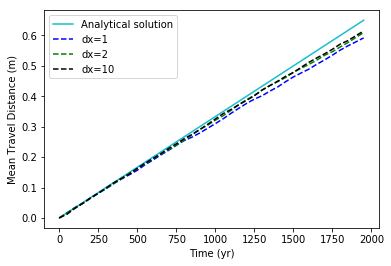

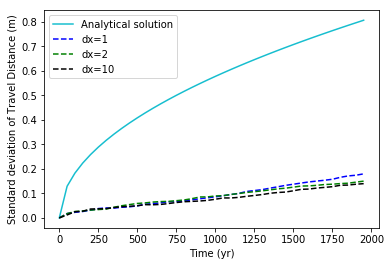

In [16]:
from datetime import datetime
startTime = datetime.now()

import numpy as np
from landlab.item_collection.clast_collection_DR import ClastCollection
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, LinearDiffuser
from landlab.plot import imshow_grid
from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, legend


# Grid 1
dx = 1.
dy=1.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.3
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)

## Flow Director
fa = FlowAccumulator(grid,
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')

## LinDif
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)

# Clasts:
nb_clast = 100
initial_rad = np.random.rand(nb_clast)

CC = ClastCollection(grid,
                     clast_x=np.ones(nb_clast)*2,
                     clast_y=np.ones(nb_clast)*2,
                     clast_elev=np.ones(nb_clast)*6,
                     clast_radius=np.ones(nb_clast)*0.5)

### RUN ##############
Si=1.2
#lambda_0=1.

# RUN
dt=50
runtime=2000

mean_trav_dist=[0]
std_trav_dist=[0]
# Analytical solution:
analytical_mean_trav_dist=[]
analytical_std_trav_dist=[]


for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                 Si=Si,
                                 kappa=kappa,
                                 uplift=None,
                                 hillslope_river__threshold=1e4,
                                 lateral_spreading='on',
                                 disturbance_fqcy=0.01,
                                 d_star=5.)

    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))

    analytical_mean_trav_dist.append(t/dt*np.mean(CC['lambda_0'].values)*(Si + S)/(Si - S))
    analytical_std_trav_dist.append(np.sqrt(t/dt*np.mean(CC['lambda_0'].values)*(Si+S)/(Si-S)))

figure(300)
plot(range(0,runtime,dt), analytical_mean_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--b', label="dx=1")
xlabel('Time (yr)')
ylabel('Mean Travel Distance (m)')
legend(loc='upper left')
#title("slope=%s, dx=%s, kappa=%s, l_0=%.2f, l_mean=%.2f" % (S, dx, kappa, np.mean(CC['lambda_0']), np.mean(CC['lambda_mean'])))

figure(3000)
plot(range(0,runtime,dt), analytical_std_trav_dist, 'tab:cyan', label="Analytical solution")
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--b', label="dx=1")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left')


##############################################################################

# Grid 2
dx = 2.
dy=2.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.3
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)

## Flow Director
fa = FlowAccumulator(grid,
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')

## LinDif
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)


# Clasts:
nb_clast = 100
initial_rad = np.random.rand(nb_clast)

CC = ClastCollection(grid,
                     clast_x=np.ones(nb_clast)*4,
                     clast_y=np.ones(nb_clast)*4,
                     clast_elev=np.ones(nb_clast)*6,
                     clast_radius=np.ones(nb_clast)*0.5)

### RUN ##############
Si=1.2
#lambda_0=1.

# RUN
dt=50
runtime=2000

mean_trav_dist=[0]
std_trav_dist=[0]

for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                 Si=Si,
                                 kappa=kappa,
                                 uplift=None,
                                 hillslope_river__threshold=1e4,
                                 lateral_spreading='on',
                                 disturbance_fqcy=0.01,
                                 d_star=5.)

    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))

figure(300)
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--g', label="dx=2")
xlabel('Time (yr)')
ylabel('Mean Travel Distance (m)')
legend(loc='upper left')

figure(3000)
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--g', label="dx=2")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left')

###############################################################################

# Grid 3
dx = 10.
dy=10.
grid = RasterModelGrid((5, 5), (dx, dy))

S=0.3
z = grid.node_y*S
_ = grid.add_field('node', 'topographic__elevation', z)
grid.set_closed_boundaries_at_grid_edges(bottom_is_closed=False,
                                                       left_is_closed=True,
                                                       right_is_closed=True,
                                                       top_is_closed=True)

## Flow Director
fa = FlowAccumulator(grid,
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')

## LinDif
kappa = 0.0001
ld = LinearDiffuser(grid, linear_diffusivity=kappa)

# Clasts:
nb_clast = 100
initial_rad = np.random.rand(nb_clast)

CC = ClastCollection(grid,
                     clast_x=np.ones(nb_clast)*20,
                     clast_y=np.ones(nb_clast)*20,
                     clast_elev=np.ones(nb_clast)*6,
                     clast_radius=np.ones(nb_clast)*0.5)

### RUN ##############
Si=1.2

# RUN
dt=50
runtime=2000

mean_trav_dist=[0]
std_trav_dist=[0]


for t in range(0,runtime,dt):
    #print(t)
    fa.run_one_step()
    ld.run_one_step(dt)
    CC.clast_solver_Exponential(dt=dt,
                                 Si=Si,
                                 kappa=kappa,
                                 uplift=None,
                                 hillslope_river__threshold=1e4,
                                 lateral_spreading='on',
                                 disturbance_fqcy=0.01,
                                 d_star=5.)

    mean_trav_dist.append(np.mean(CC['total_travelled_dist'].values))
    std_trav_dist.append(np.std(CC['total_travelled_dist'].values))

figure(300)
plot(range(0,runtime,dt), mean_trav_dist[0:-1], '--k', label="dx=10")
xlabel('Time (yr)')
ylabel('Mean Travel Distance (m)')
legend(loc='upper left')

figure(3000)
plot(range(0,runtime,dt), std_trav_dist[0:-1], '--k', label="dx=10")
xlabel('Time (yr)')
ylabel('Standard deviation of Travel Distance (m)')
legend(loc='upper left')



finishTime = datetime.now() - startTime
print('time to execute:%s' %finishTime)

_**Why is std dev so low?**_